In [ ]:
!pip install transformer_lens --quiet

In [ ]:
from transformer_lens import HookedTransformer
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

MAX_NUMBERS = 64
BATCH_SIZE = 128
NUM_EPOCHS = 5000
TRAIN_STEPS_PER_EPOCH = 100
D_MODEL = 512
N_HEADS = 4
N_LAYERS = 1


CTX_LENGTH = 2 * MAX_NUMBERS + 3
STARTSEQ = MAX_NUMBERS
STARTSORT = MAX_NUMBERS + 1
ENDSEQ = MAX_NUMBERS + 2
PAD = MAX_NUMBERS + 3
D_VOCAB = MAX_NUMBERS + 4


In [ ]:
# Modified generate_data function
def generate_data(batch_size, fixed_length=None):
    x = []
    y = []
    lengths = []

    for _ in range(batch_size):
        length = fixed_length if fixed_length else np.random.randint(2, MAX_NUMBERS + 1)
        #numbers = np.random.randint(0, MAX_NUMBERS, size=length)
        numbers = np.random.choice(MAX_NUMBERS, size=length, replace=False)
        sorted_numbers = np.sort(numbers)

        # Add ENDSEQ to sequences
        input_seq = [STARTSEQ] + list(numbers) + [STARTSORT]
        target_seq = [STARTSEQ] + list(numbers) + [STARTSORT] + list(sorted_numbers) + [ENDSEQ]

        # Pad sequences
        input_seq = input_seq + [PAD] * (CTX_LENGTH - len(input_seq))
        target_seq = target_seq + [PAD] * (CTX_LENGTH - len(target_seq))

        x.append(input_seq)
        y.append(target_seq)
        lengths.append(2 * length + 3)  # +2 for STARTSORT and ENDSEQ

    return (torch.tensor(x, dtype=torch.long, device=device),
            torch.tensor(y, dtype=torch.long, device=device),
            torch.tensor(lengths, dtype=torch.long, device=device))

In [ ]:
def custom_loss(logits, targets, lengths):
    batch_size = logits.shape[0]
    loss = 0
    total_tokens = 0

    for i in range(batch_size):
        # Only calculate loss up to the actual sequence length
        seq_logits = logits[i, :lengths[i]]
        seq_targets = targets[i, :lengths[i]]

        # Calculate cross entropy loss for this sequence
        loss += nn.CrossEntropyLoss(reduction='sum')(seq_logits, seq_targets)
        total_tokens += lengths[i]

    return loss / total_tokens

In [ ]:
# Update config with new vocab size
config = {
    'd_model': D_MODEL,
    'n_layers': N_LAYERS,
    'n_heads': N_HEADS,
    'd_head': D_MODEL // N_HEADS,
    'n_ctx': CTX_LENGTH,
    'd_vocab': D_VOCAB,
    'act_fn': 'relu',
    'attn_only': True,
}

model = HookedTransformer(config)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

optimizer = optim.Adam(model.parameters())

# Initialize lists to store history
history = {
    'loss': [],
    'accuracy': []
}

# Modified training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    total_accuracy = 0

    for _ in tqdm(range(TRAIN_STEPS_PER_EPOCH), desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        x, y, lengths = generate_data(BATCH_SIZE)

        optimizer.zero_grad()
        logits = model(x)
        loss = custom_loss(logits, y, lengths)
        loss.backward()
        optimizer.step()

        # Calculate accuracy only on non-padded tokens
        with torch.no_grad():
            predictions = logits.argmax(dim=-1)
            correct = 0
            total = 0
            for i in range(BATCH_SIZE):
                correct += (predictions[i, :lengths[i]] == y[i, :lengths[i]]).sum().item()
                total += lengths[i].item()
            accuracy = correct / total

        total_loss += loss.item()
        total_accuracy += accuracy

    avg_loss = total_loss / TRAIN_STEPS_PER_EPOCH
    avg_accuracy = total_accuracy / TRAIN_STEPS_PER_EPOCH
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}")

    history['loss'].append(avg_loss)
    history['accuracy'].append(avg_accuracy)

In [ ]:
torch.save(model.state_dict(), f'sorting_transformer_{N_HEADS}_heads_{N_LAYER}.pth')

In [ ]:
model.load_state_dict(torch.load('sorting_transformer_4_heads.pth'))

In [ ]:
model.eval()
accuracies = []
for length in range(2, 51):
    total_accuracy = 0
    for _ in range(100):
        x, y, lengths = generate_data(batch_size=1, fixed_length=length)
        with torch.no_grad():
            logits = model(x)
            correct = 0
            total = 0
            for i in range(1):
                correct += (logits[i, :lengths[i]].argmax(dim=-1) == y[i, :lengths[i]]).sum().item()
                total += lengths[i].item()
            accuracy = correct / total
        total_accuracy += accuracy
    accuracies.append(total_accuracy/100)
    print(f"Length {length}: Accuracy = {total_accuracy/100:.4f}")

Length 2: Accuracy = 1.0000
Length 3: Accuracy = 1.0000
Length 4: Accuracy = 1.0000
Length 5: Accuracy = 1.0000
Length 6: Accuracy = 1.0000
Length 7: Accuracy = 1.0000
Length 8: Accuracy = 1.0000
Length 9: Accuracy = 1.0000
Length 10: Accuracy = 0.9987
Length 11: Accuracy = 1.0000
Length 12: Accuracy = 1.0000
Length 13: Accuracy = 0.9972
Length 14: Accuracy = 0.9997
Length 15: Accuracy = 1.0000
Length 16: Accuracy = 1.0000
Length 17: Accuracy = 1.0000
Length 18: Accuracy = 0.9987
Length 19: Accuracy = 0.9995
Length 20: Accuracy = 1.0000
Length 21: Accuracy = 0.9996
Length 22: Accuracy = 0.9998
Length 23: Accuracy = 0.9976
Length 24: Accuracy = 0.9978
Length 25: Accuracy = 0.9991
Length 26: Accuracy = 0.9995
Length 27: Accuracy = 1.0000
Length 28: Accuracy = 0.9993
Length 29: Accuracy = 0.9993
Length 30: Accuracy = 0.9962
Length 31: Accuracy = 0.9918
Length 32: Accuracy = 0.9948
Length 33: Accuracy = 0.9970
Length 34: Accuracy = 0.9970
Length 35: Accuracy = 0.9984
Length 36: Accuracy = 

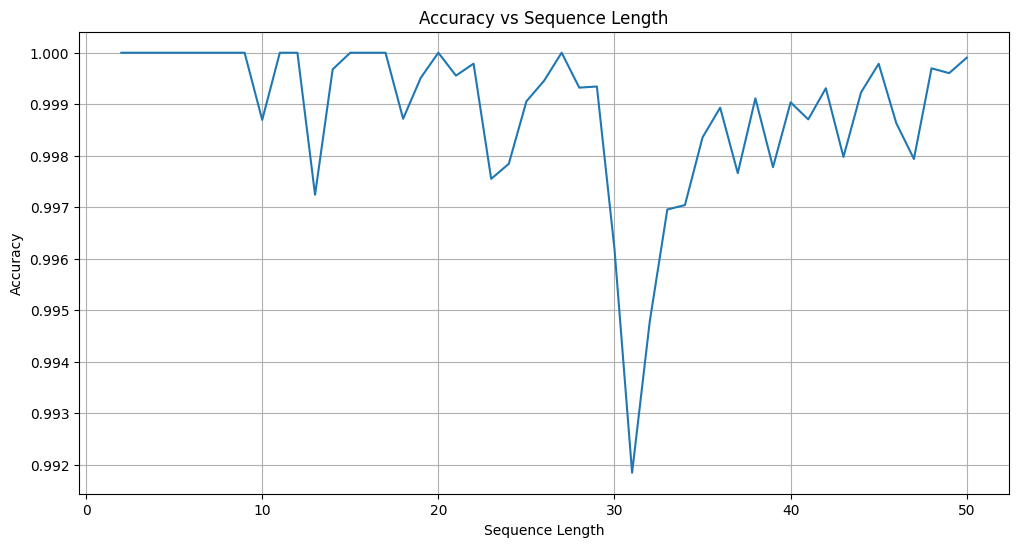

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(2, 51), accuracies)
plt.title('Accuracy vs Sequence Length')
plt.xlabel('Sequence Length')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('accuracy_vs_length_new.png')
plt.show()

Token embeddings shape: torch.Size([68, 512])
W_Q shape: torch.Size([4, 512, 128])
W_K shape: torch.Size([4, 512, 128])


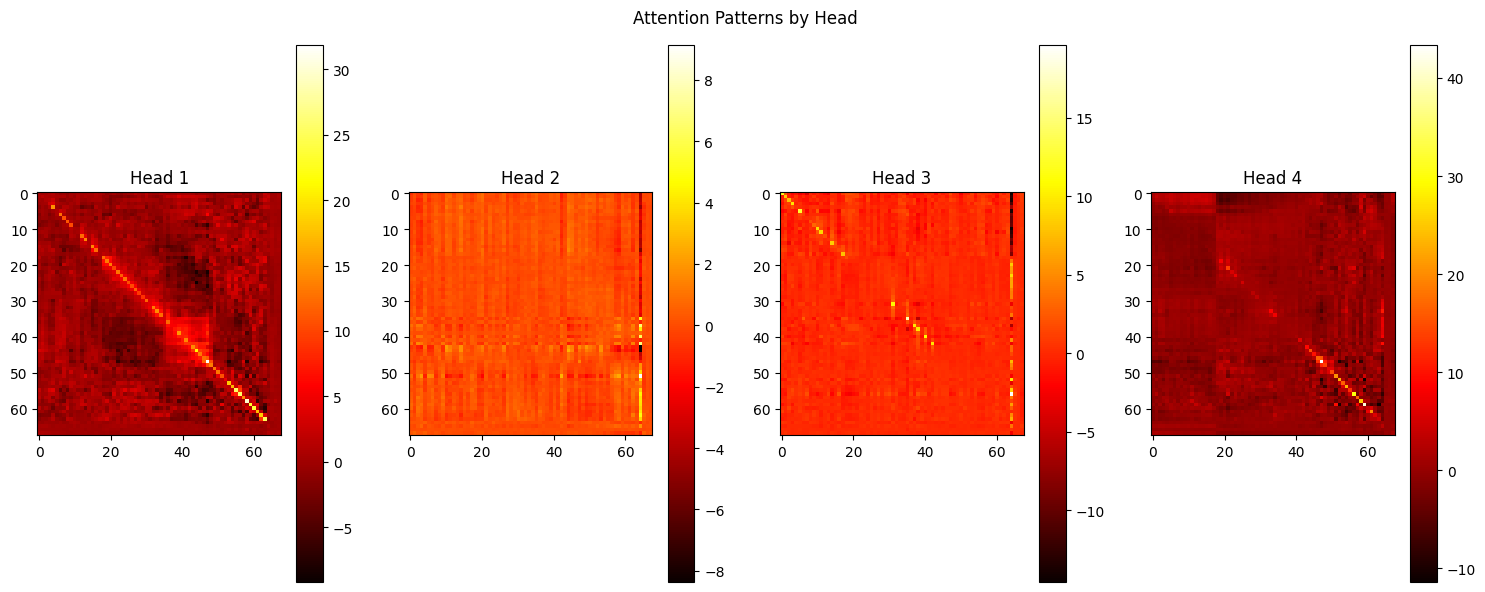

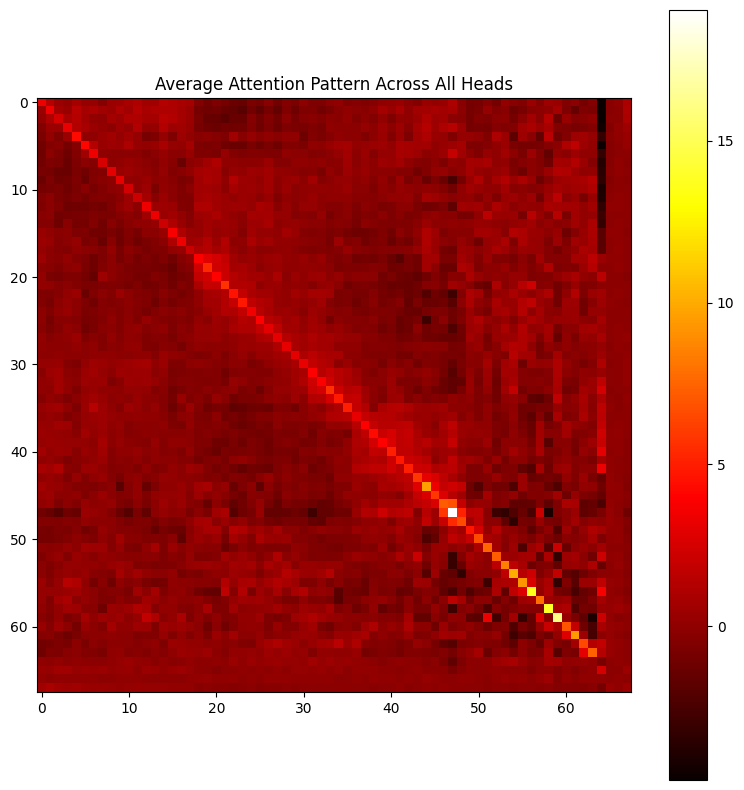

In [ ]:
import torch
from fancy_einsum import einsum
import matplotlib.pyplot as plt

# Get attention weights
attn = model.blocks[0].attn
W_Q = attn.W_Q
W_K = attn.W_K

# Get token embeddings
token_embeddings = model.embed.W_E

# Print shapes to debug
print("Token embeddings shape:", token_embeddings.shape)
print("W_Q shape:", W_Q.shape)
print("W_K shape:", W_K.shape)

# Calculate query and key embeddings
embeddings_key = einsum("v m, h m k -> h v k",
                       token_embeddings, W_K)
embeddings_query = einsum("v m, h m k -> h v k",
                         token_embeddings, W_Q)

# Calculate attention scores
attn_scores = einsum("h q k, h k v -> h q v",
                     embeddings_query, embeddings_key.transpose(-2, -1))

# Plot heatmaps for each attention head
fig, axes = plt.subplots(1, N_HEADS, figsize=(15, 6))
if N_HEADS == 1:
    axes = [axes]

for head in range(N_HEADS):
    attn_pattern = attn_scores[head].detach().cpu().numpy()
    im = axes[head].imshow(attn_pattern, cmap='hot', interpolation='nearest')
    axes[head].set_title(f'Head {head+1}')
    plt.colorbar(im, ax=axes[head])

plt.suptitle('Attention Patterns by Head')
plt.tight_layout()
plt.show()

#Plot average attention pattern across all heads
plt.figure(figsize=(8, 8))
avg_attn_pattern = attn_scores.mean(dim=0).detach().cpu().numpy()
im = plt.imshow(avg_attn_pattern, cmap='hot', interpolation='nearest')
plt.colorbar(im)
plt.title('Average Attention Pattern Across All Heads')
plt.tight_layout()
plt.show()

In [ ]:
logits, cache = model.run_with_cache(x)
cache

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_post', 'ln_final.hook_scale', 'ln_final.hook_normalized']

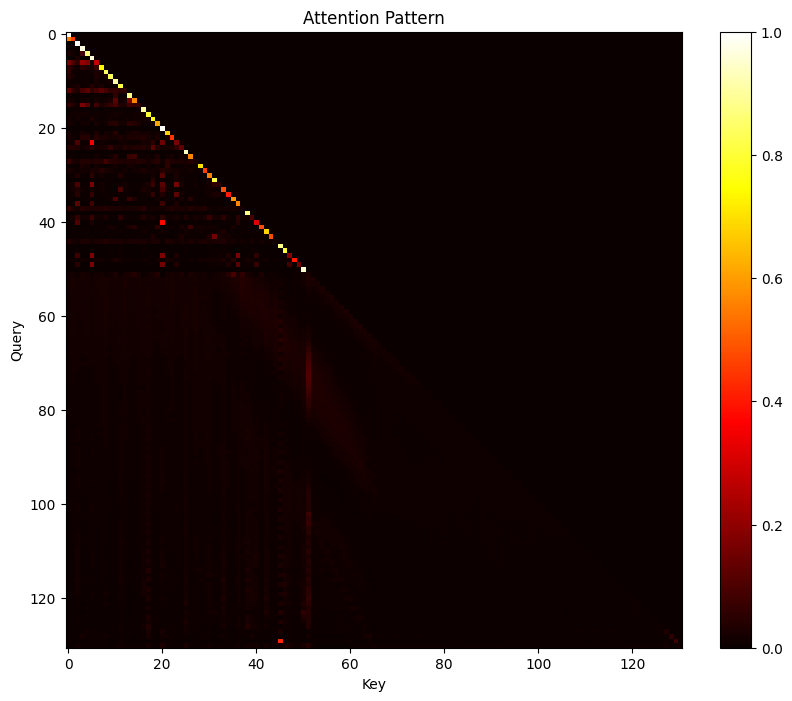

In [ ]:
attention_pattern = cache['blocks.0.attn.hook_pattern'][0, 0]  # Get the attention pattern for the first layer and head

plt.figure(figsize=(10, 8))
plt.imshow(attention_pattern.cpu().detach().numpy(), cmap='hot')
plt.colorbar()
plt.title('Attention Pattern')
plt.xlabel('Key')
plt.ylabel('Query')
plt.savefig('attention_pattern.png')
plt.show()

In [ ]:
#@title all 4 heads
def plot_attention_patterns(x, model):
    with torch.no_grad():
        logits, cache = model.run_with_cache(x)
        attention = cache['pattern', 0]  # Get attention from first (and only) layer
        predictions = logits.argmax(dim=-1)

    attention = attention.cpu().numpy()
    x = x.cpu().numpy()
    predictions = predictions.cpu().numpy()

    for b in range(len(x)):
        # Find the actual sequence length (excluding padding)
        seq = x[b]
        pred = predictions[b]
        seq_length = np.where(seq == PAD)[0][0] if PAD in seq else len(seq)

        # Create a figure with subplots for each head
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))  # 2x2 grid for 4 heads
        axes = axes.flatten()  # Flatten the array for easier iteration

        for head in range(N_HEADS):
            im = axes[head].imshow(attention[b, head, :seq_length, :seq_length], cmap='hot')
            axes[head].set_title(f'Head {head + 1} Attention Pattern')
            axes[head].set_xlabel('Key positions')
            axes[head].set_ylabel('Query positions')
            plt.colorbar(im, ax=axes[head])

            # Add token labels
            token_labels = [str(t) for t in seq[:seq_length]]
            axes[head].set_xticks(range(seq_length))
            axes[head].set_yticks(range(seq_length))
            axes[head].set_xticklabels(token_labels, rotation=45)
            axes[head].set_yticklabels(token_labels)


        # Print sequence information
        print("\nSequence Information:")
        print("Input sequence:", [i for i in seq if i != PAD])
        print("Predicted sequence:", [i for i in pred if i != PAD])

        plt.tight_layout()
        plt.show()


test_x, test_y, _ = generate_data(1, fixed_length=20) # Generate a single sequence of length 10
plot_attention_heatmap(test_x, model)

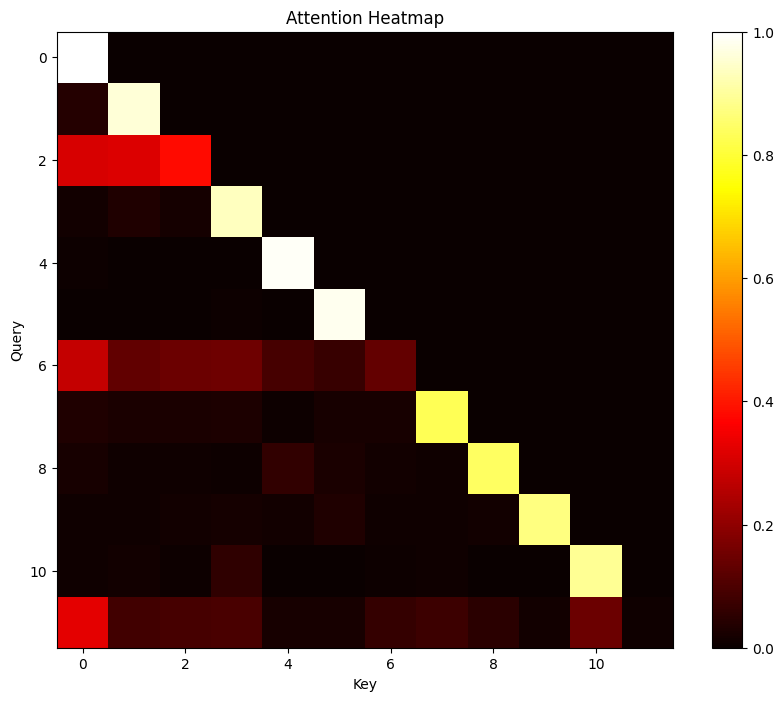

In [ ]:
test_x, test_y, _ = generate_data(1, fixed_length=10)
plot_attention_heatmap(test_x, model)
plot_attention_patterns(test_y, model)


Sequence Information:
Input sequence: [64, 45, 17, 4, 41, 29, 61, 35, 0, 50, 18, 65, 0, 4, 17, 18, 29, 35, 41, 45, 50, 61, 66]
Predicted sequence: [64, 45, 17, 4, 41, 29, 61, 35, 0, 50, 18, 65, 0, 4, 17, 18, 29, 35, 41, 45, 50, 61, 17, 0, 0, 4, 4, 17, 17, 18, 18, 29, 29, 29, 35, 35, 41, 41, 41, 45, 50, 61, 61, 61, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 61, 66, 66, 66, 66, 66, 66, 66, 66, 66, 63, 62, 63, 66]


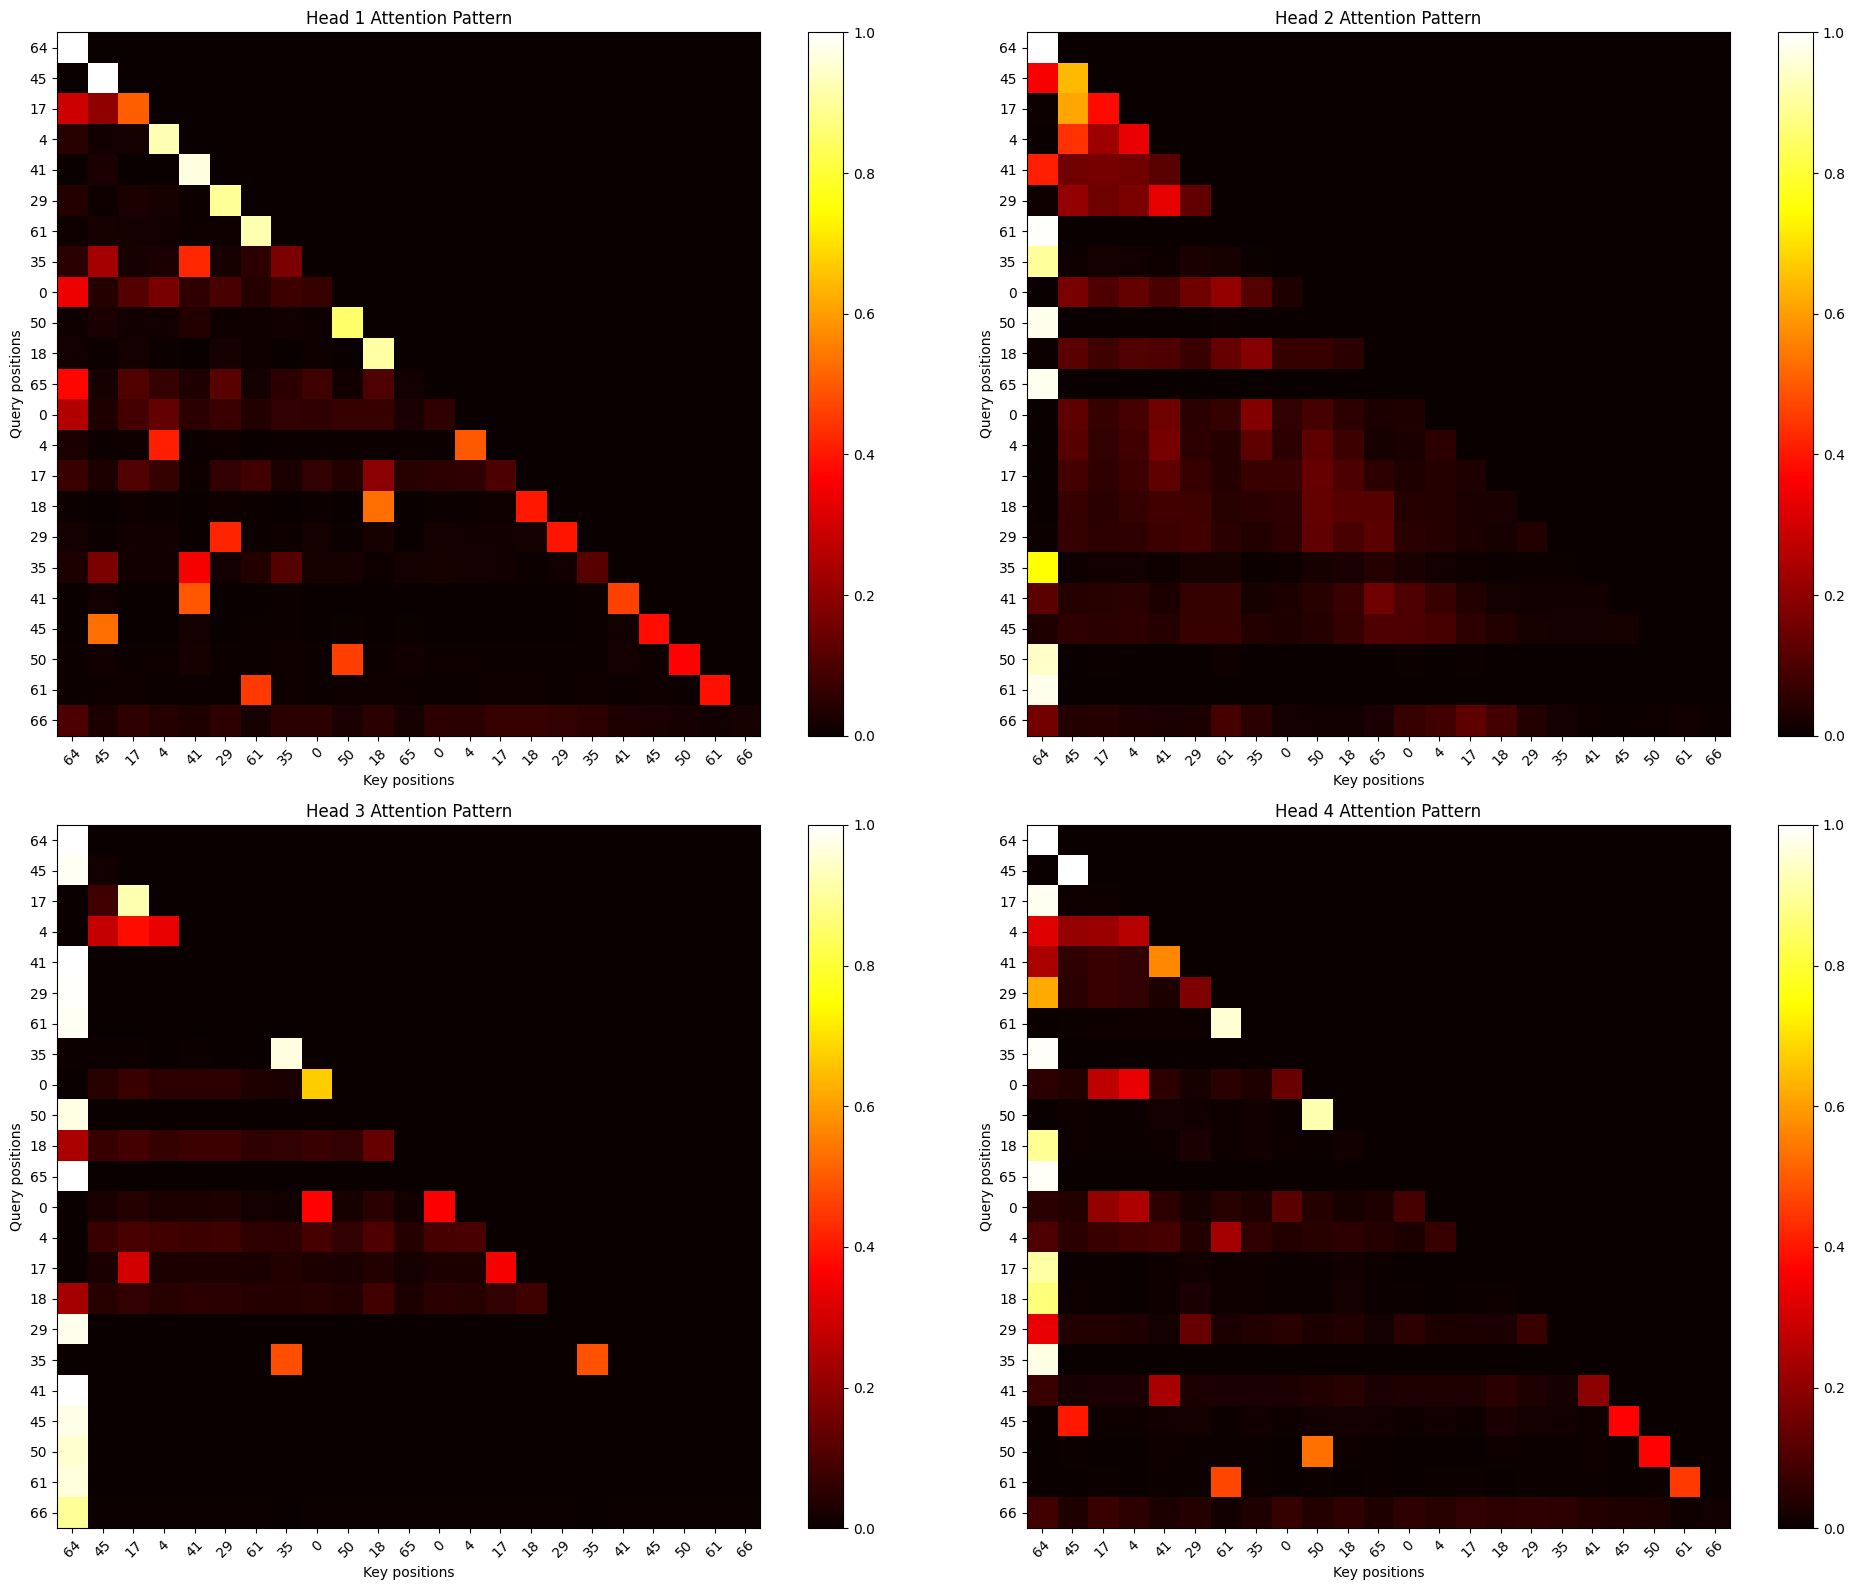


Sequence Information:
Input sequence: [64, 59, 44, 49, 54, 21, 63, 52, 57, 1, 6, 65, 1, 6, 21, 44, 49, 52, 54, 57, 59, 63, 66]
Predicted sequence: [64, 59, 44, 49, 54, 21, 63, 52, 57, 1, 6, 65, 1, 6, 21, 44, 49, 52, 54, 57, 59, 63, 21, 1, 1, 6, 6, 21, 21, 49, 44, 49, 49, 49, 49, 52, 57, 59, 59, 63, 63, 63, 63, 63, 66, 63, 66, 63, 66, 63, 66, 63, 66, 63, 66, 66, 66, 66, 66, 63, 66, 63, 66, 63, 66, 63, 66, 63, 66, 63, 66, 63, 66, 63, 66, 63, 66, 66, 66, 63, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 63, 66, 63, 66, 63, 66, 63, 66, 63, 66, 66, 66, 66, 66, 66, 66, 63, 66, 63, 66, 66, 66, 66, 66, 66, 66, 63, 62, 63, 66]


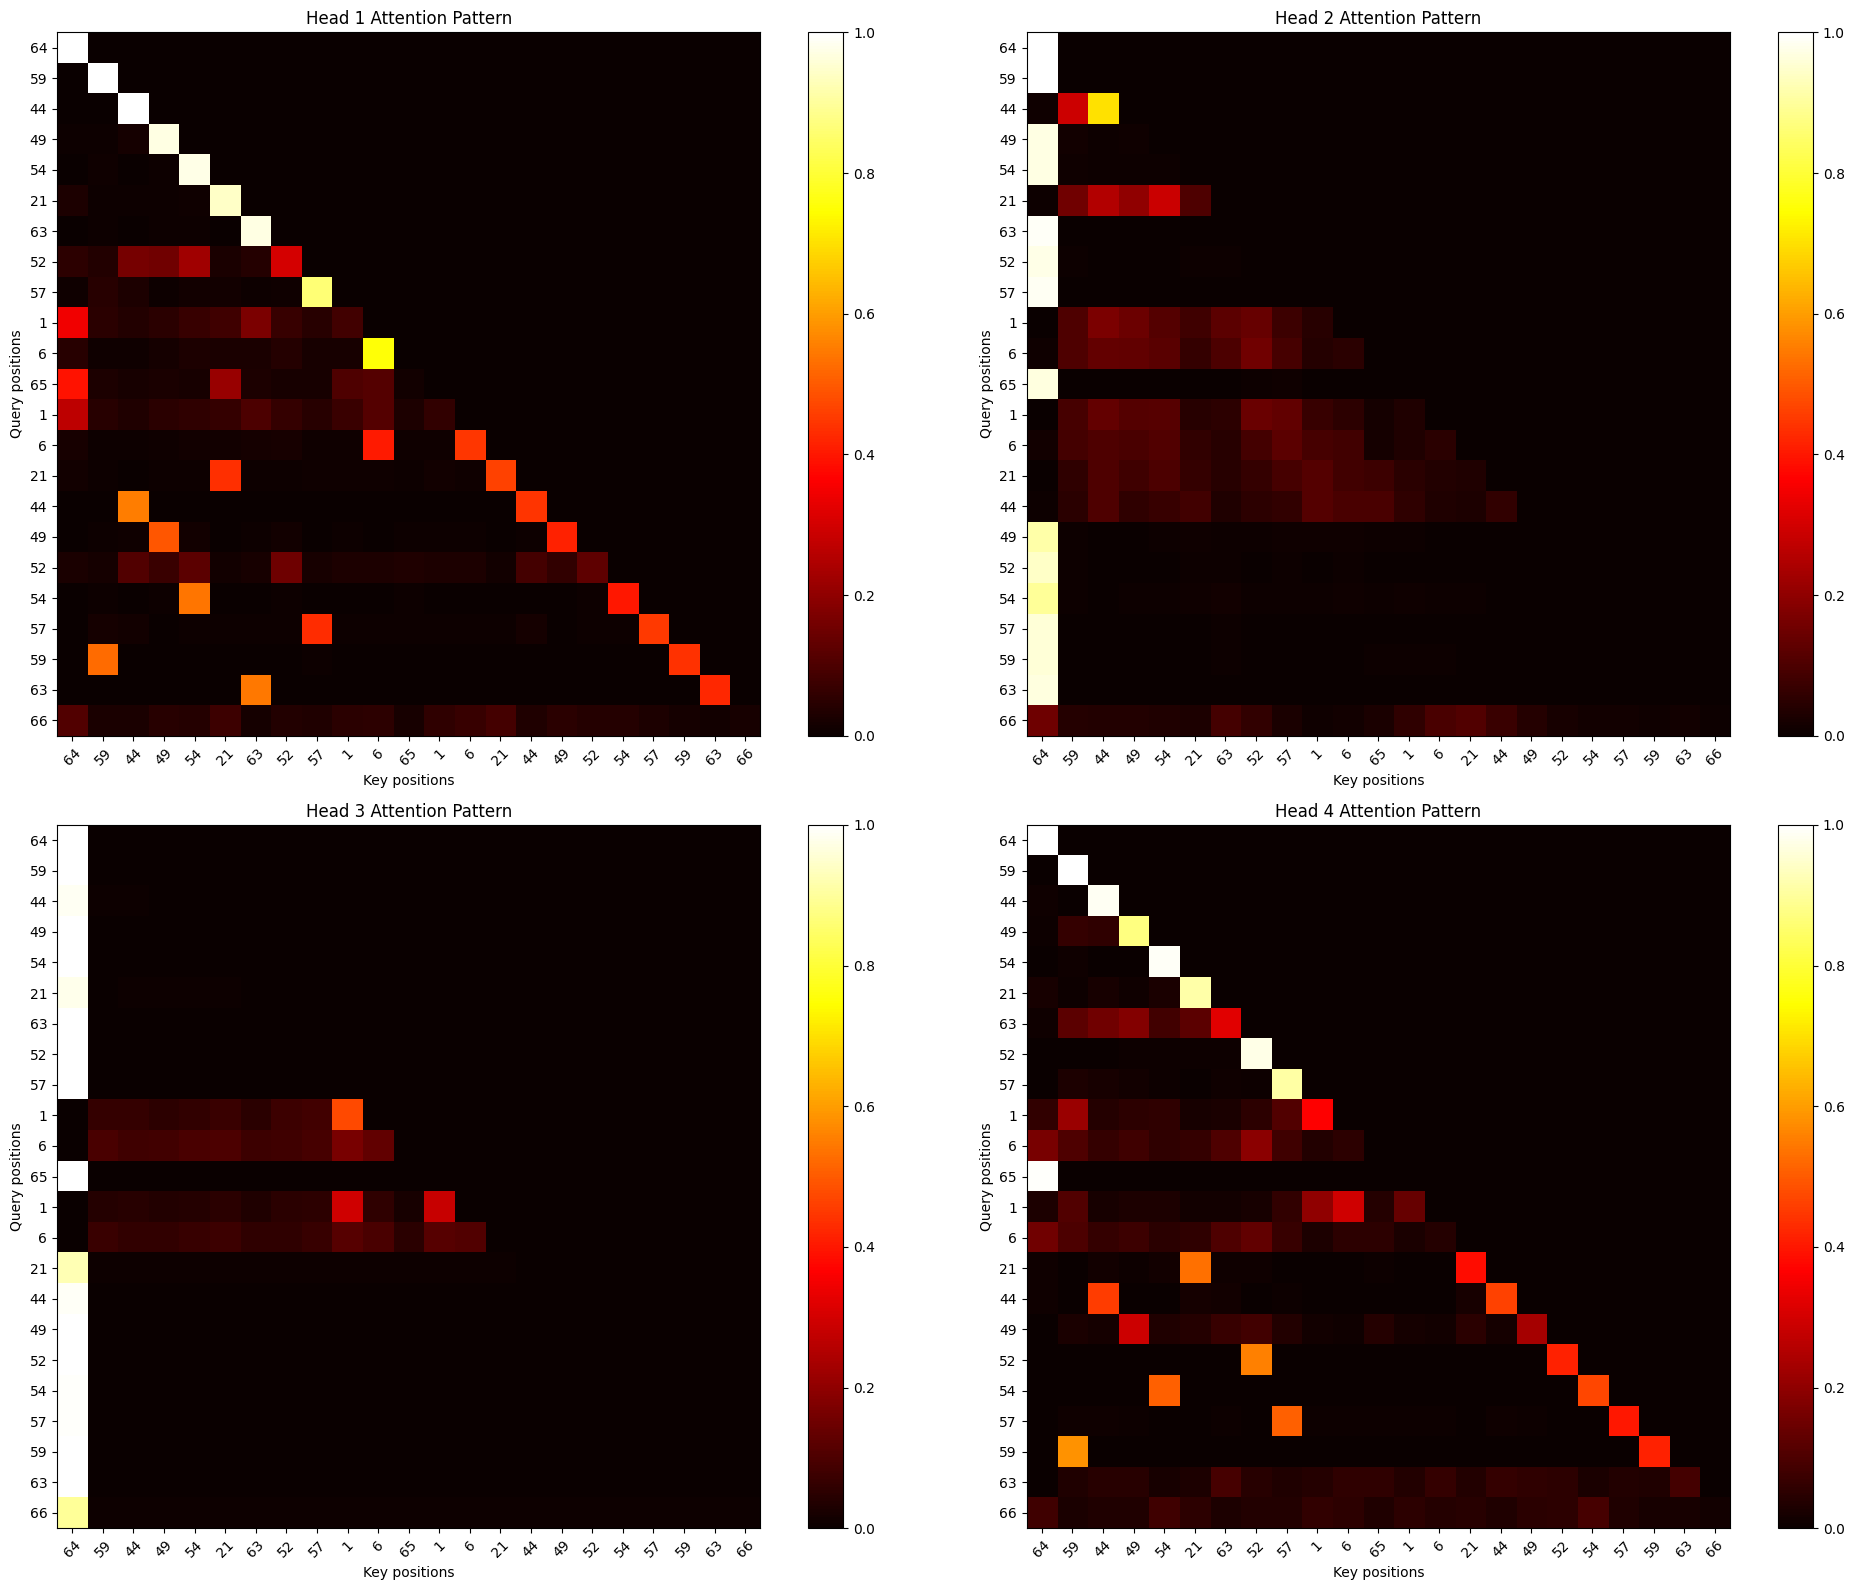


Sequence Information:
Input sequence: [64, 3, 46, 14, 48, 57, 32, 24, 10, 53, 16, 65, 3, 10, 14, 16, 24, 32, 46, 48, 53, 57, 66]
Predicted sequence: [64, 3, 46, 14, 48, 57, 32, 24, 10, 53, 16, 65, 3, 10, 14, 16, 24, 32, 46, 48, 53, 57, 14, 3, 3, 10, 10, 14, 14, 16, 16, 24, 24, 32, 32, 32, 46, 46, 46, 48, 53, 57, 57, 57, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 62, 62, 63, 66]


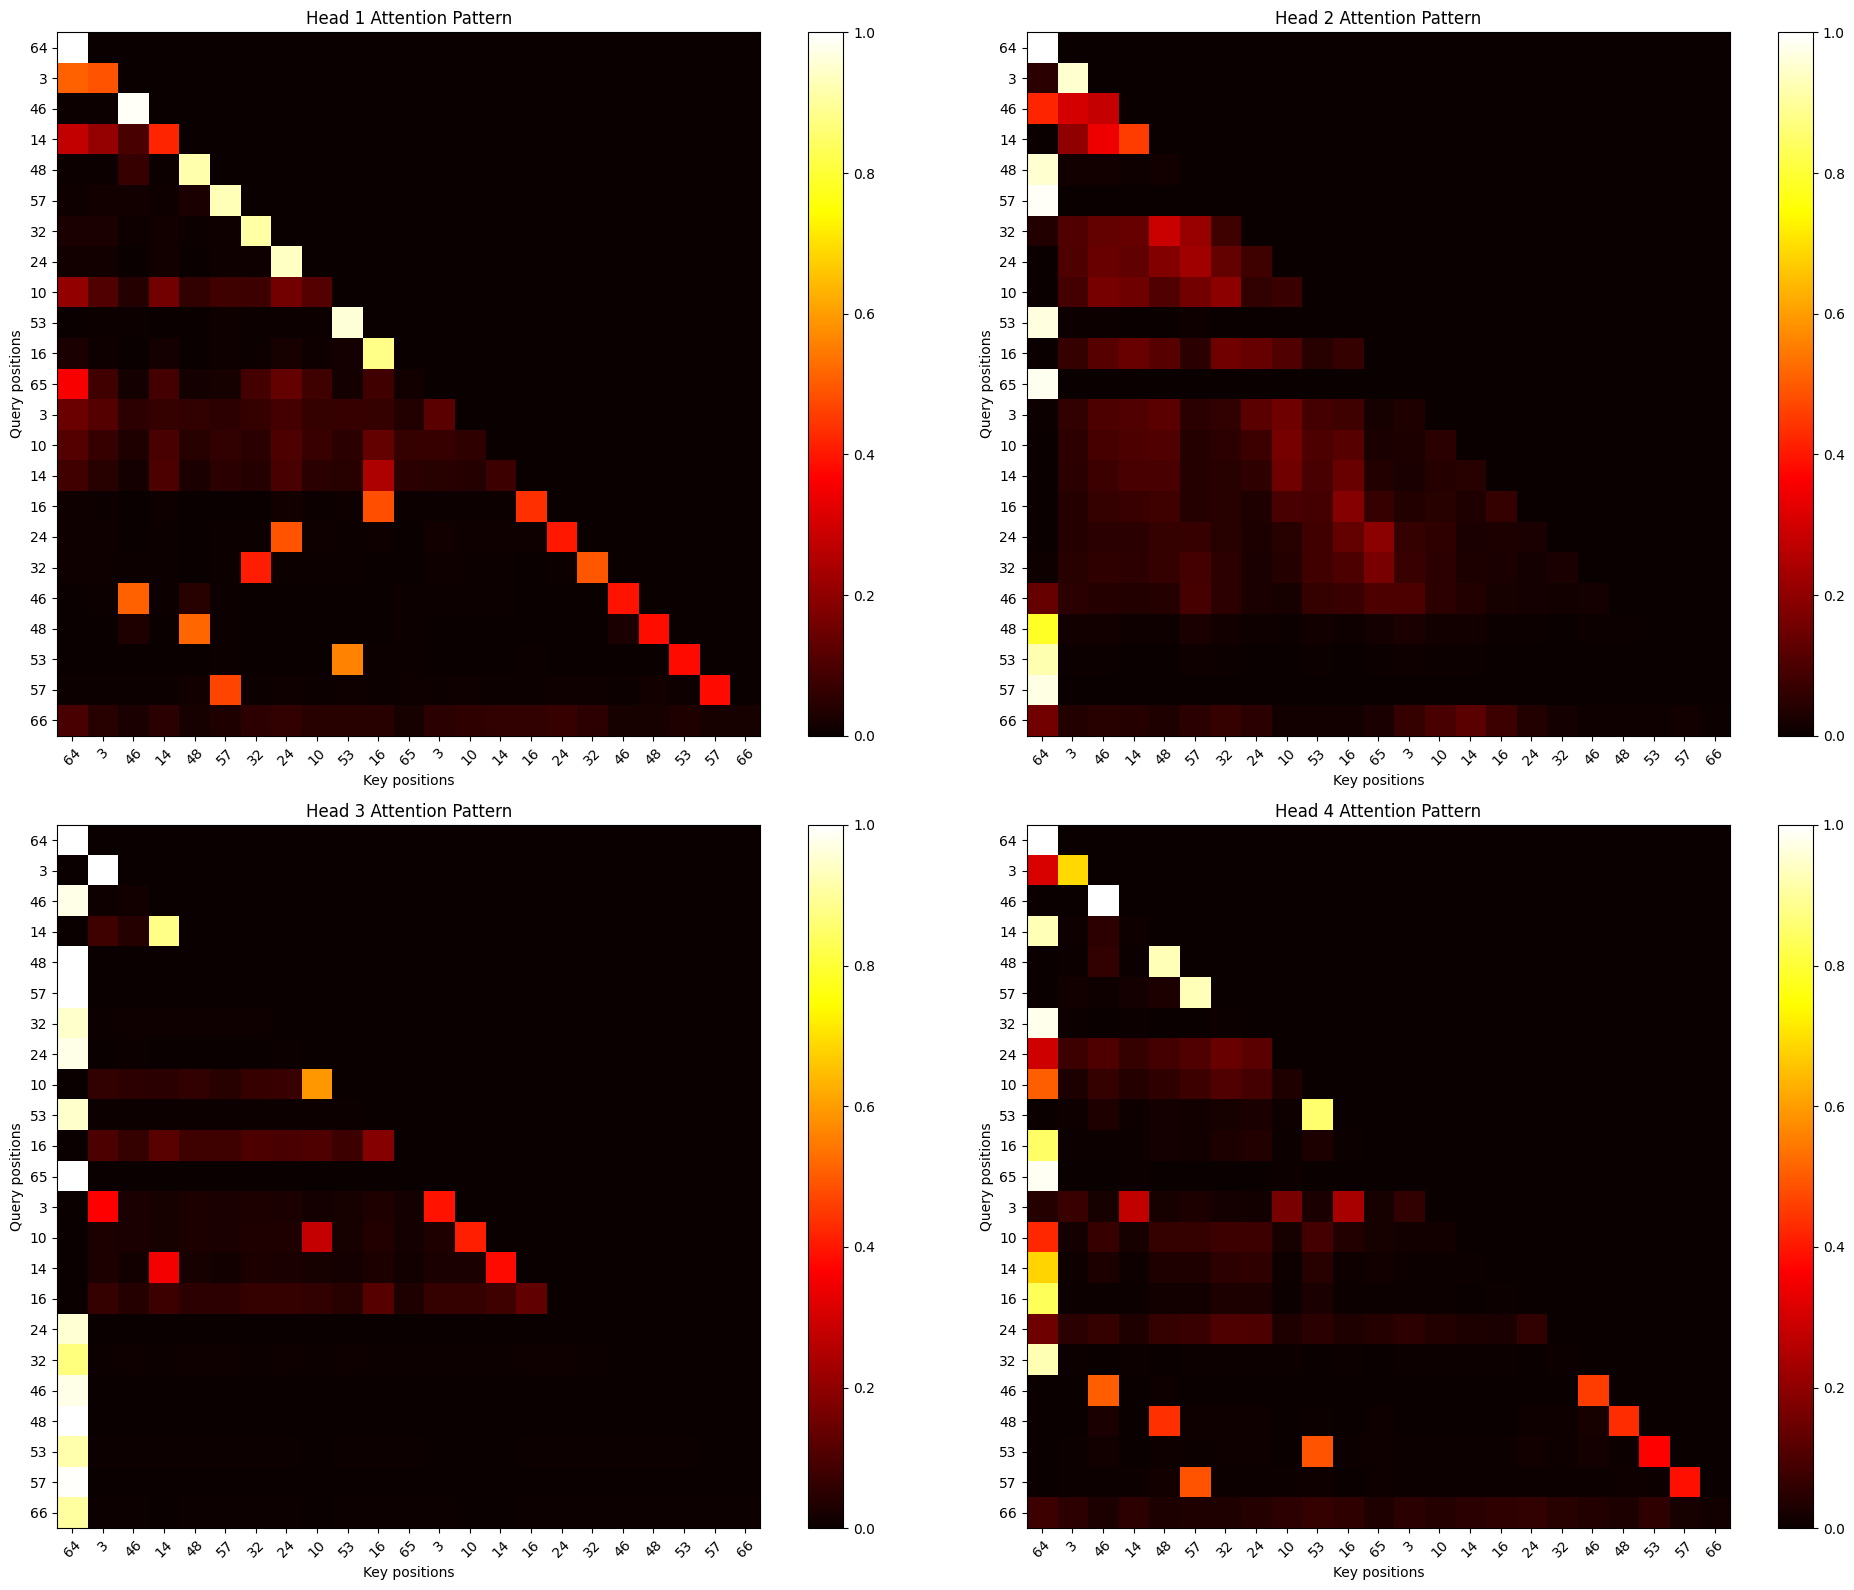

In [ ]:
plot_attention_patterns(test_y, model)


Unablated sample sequence:
Input: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65  0  1 26 33 37 41 43
 44 47 49 54 55 58 60 62 66 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Predicted: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65  0  1 26 33 37 41 43
 44 47 49 54 55 58 60 62 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66


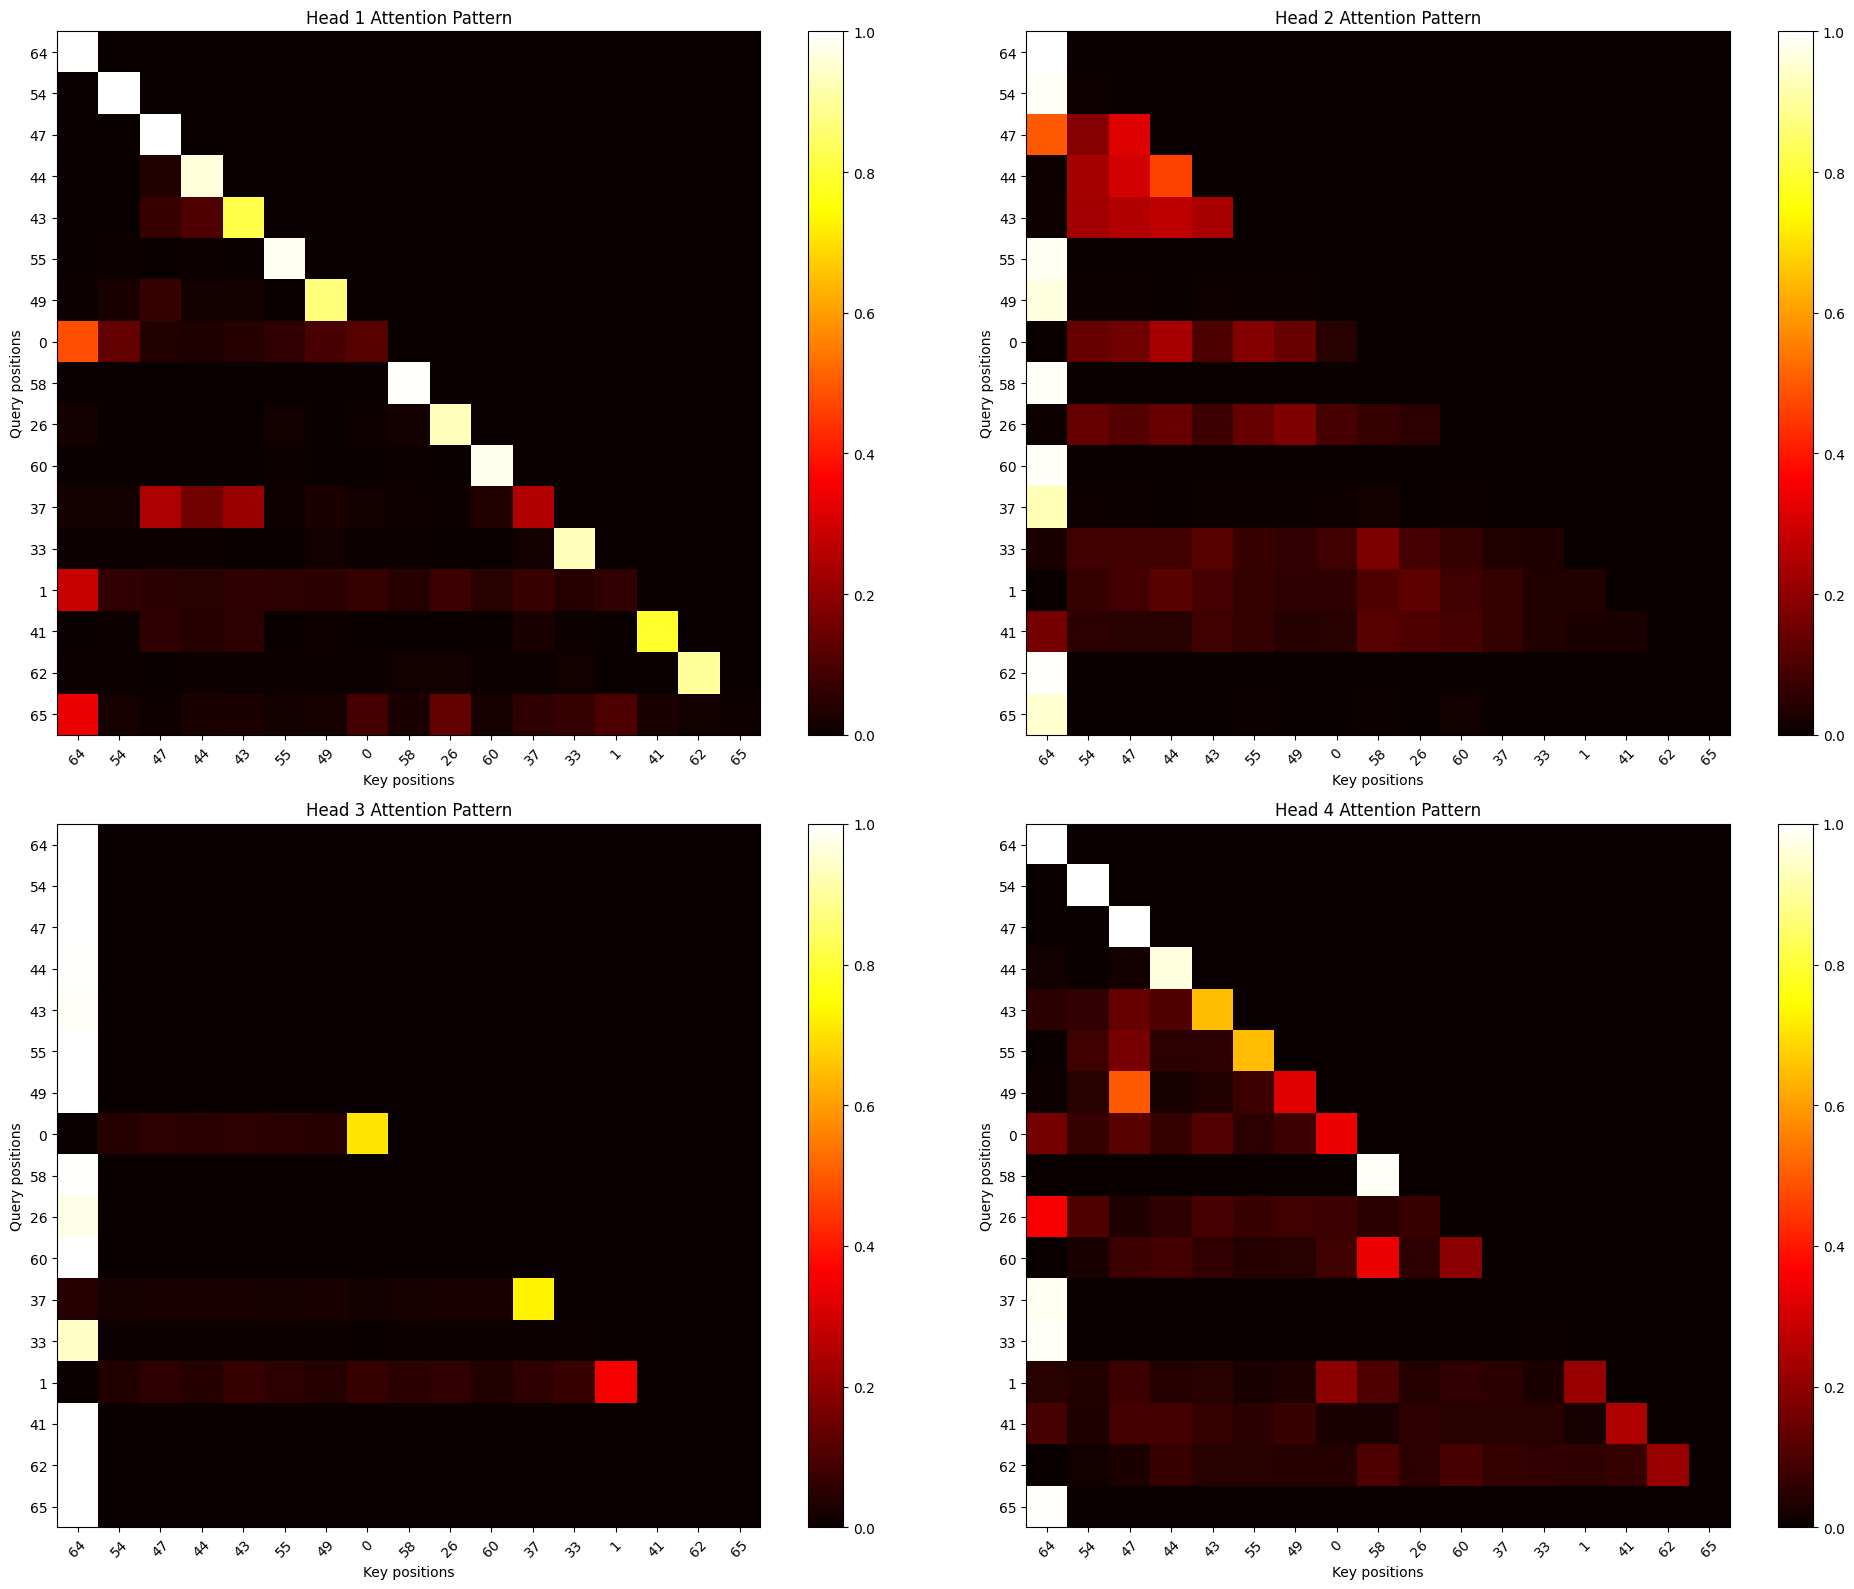


Testing ablation of heads: [0]

Sequence Information:
Input sequence: [64, 54, 47, 44, 43, 55, 49, 0, 58, 26, 60, 37, 33, 1, 41, 62, 65]
Predicted sequence: [42, 54, 46, 41, 43, 56, 48, 0, 58, 36, 57, 37, 36, 1, 41, 57, 42, 0, 43, 41, 41, 43, 43, 44, 49, 54, 54, 55, 58, 58, 60, 62, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 63, 62, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 62, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 66, 62, 66, 63, 63, 66, 66, 66, 66, 62, 66, 62, 66, 62, 66, 62, 66, 66, 66, 66, 66, 66, 66, 63, 63, 63, 66]


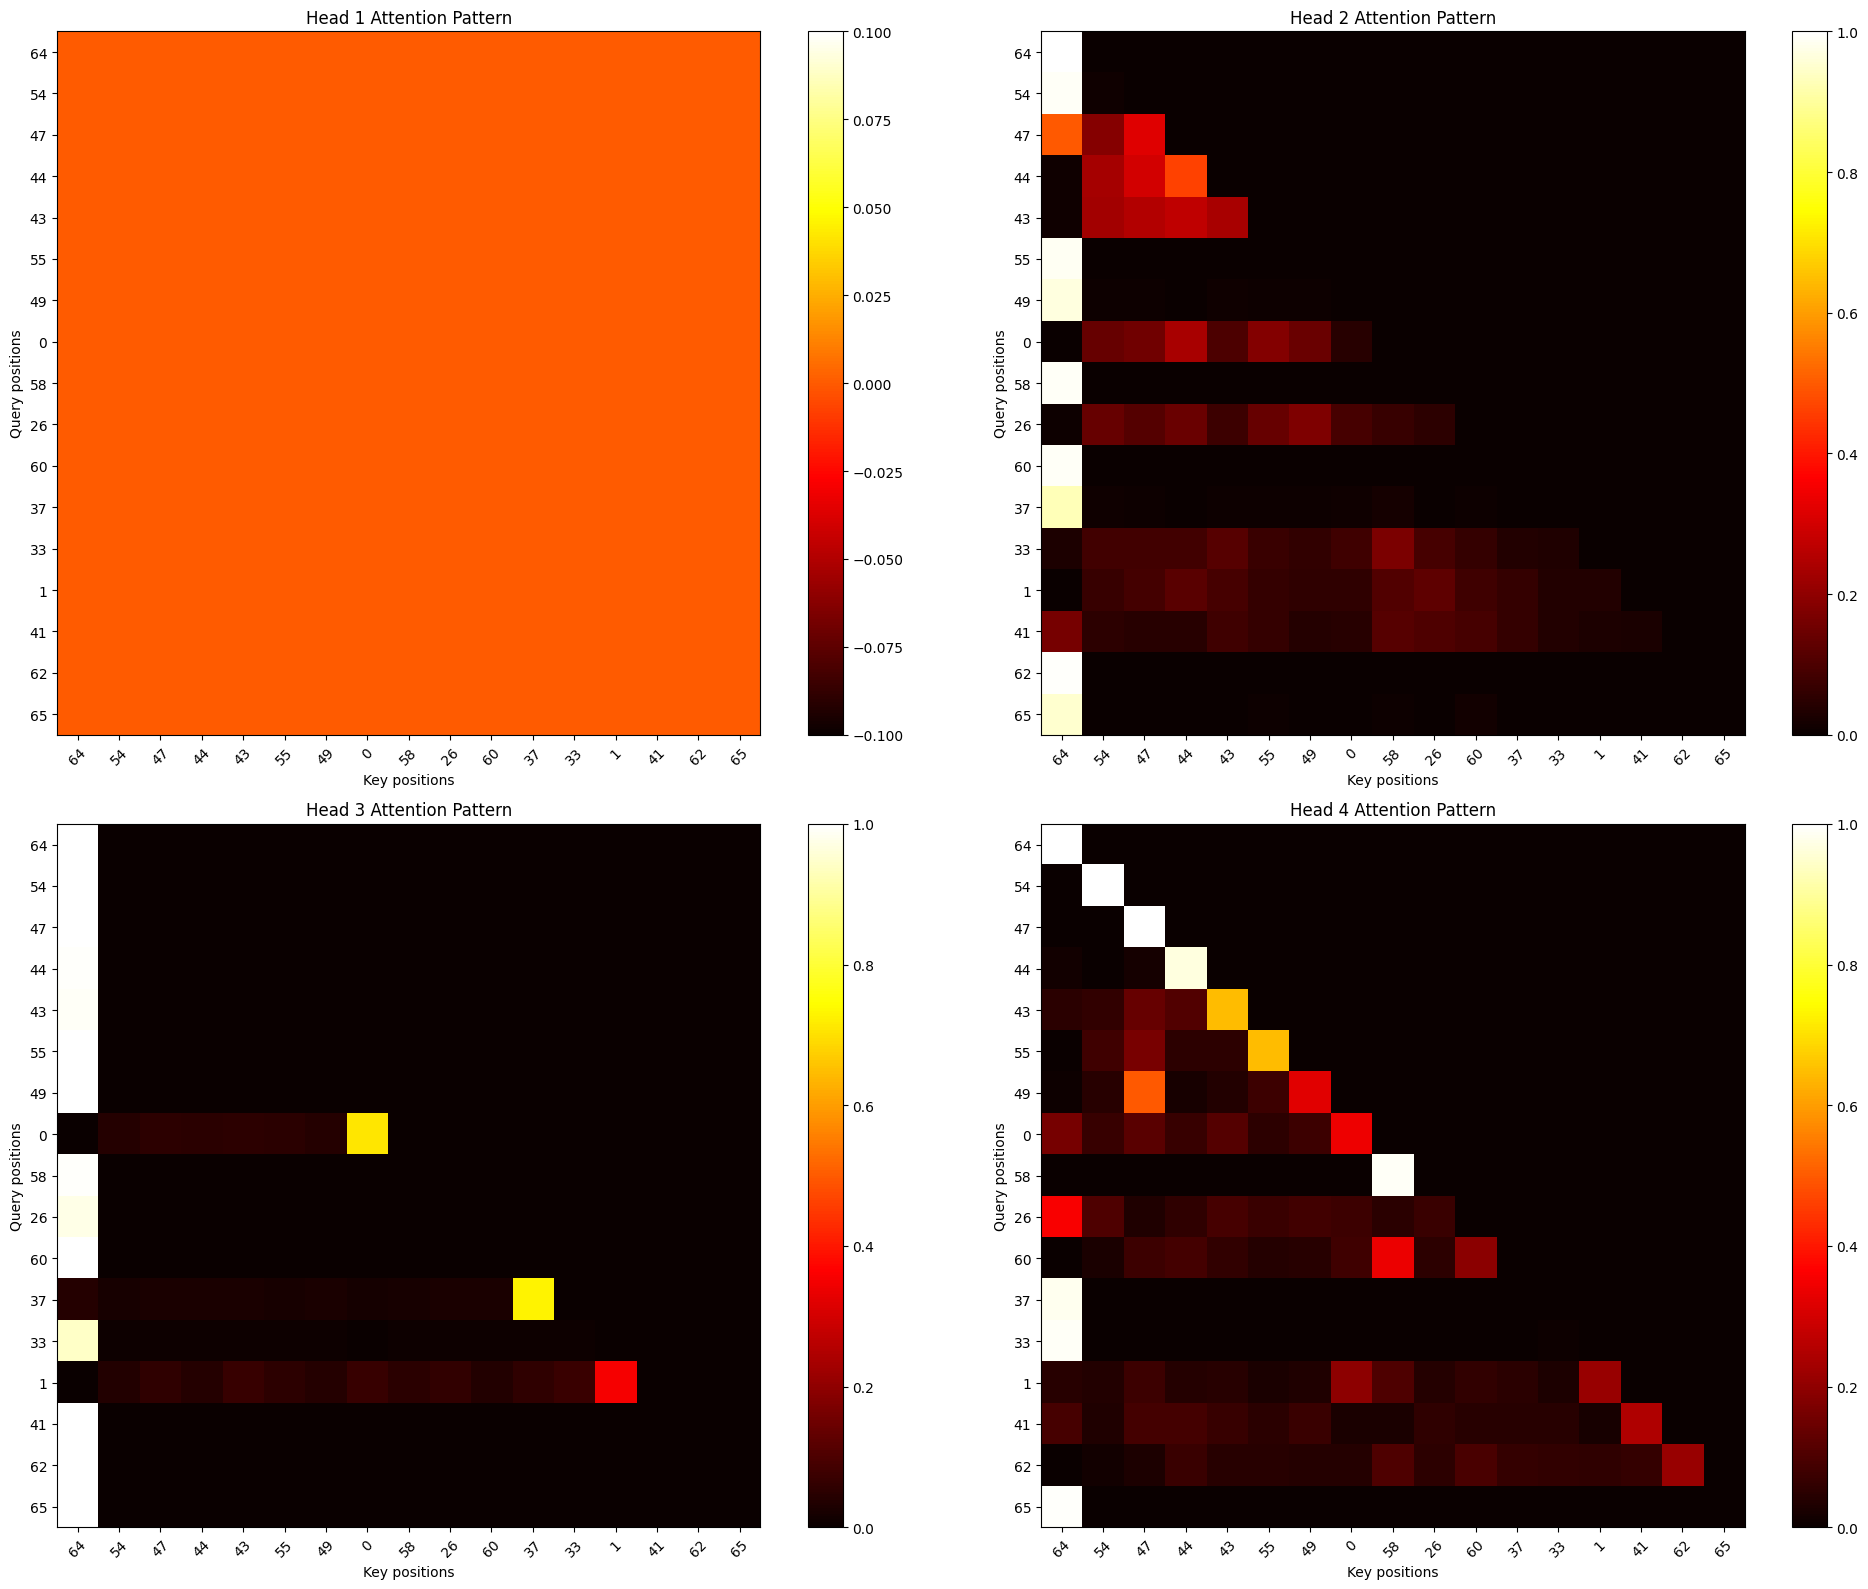


Sample sequence:
Input: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65  0  1 26 33 37 41 43
 44 47 49 54 55 58 60 62 66 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Predicted: [42 54 46 41 43 56 48  0 58 36 57 37 36  1 41 57 42  0 43 41 41 43 43 44
 49 54 54 55 58 58 60 62 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63
 63 63 63 

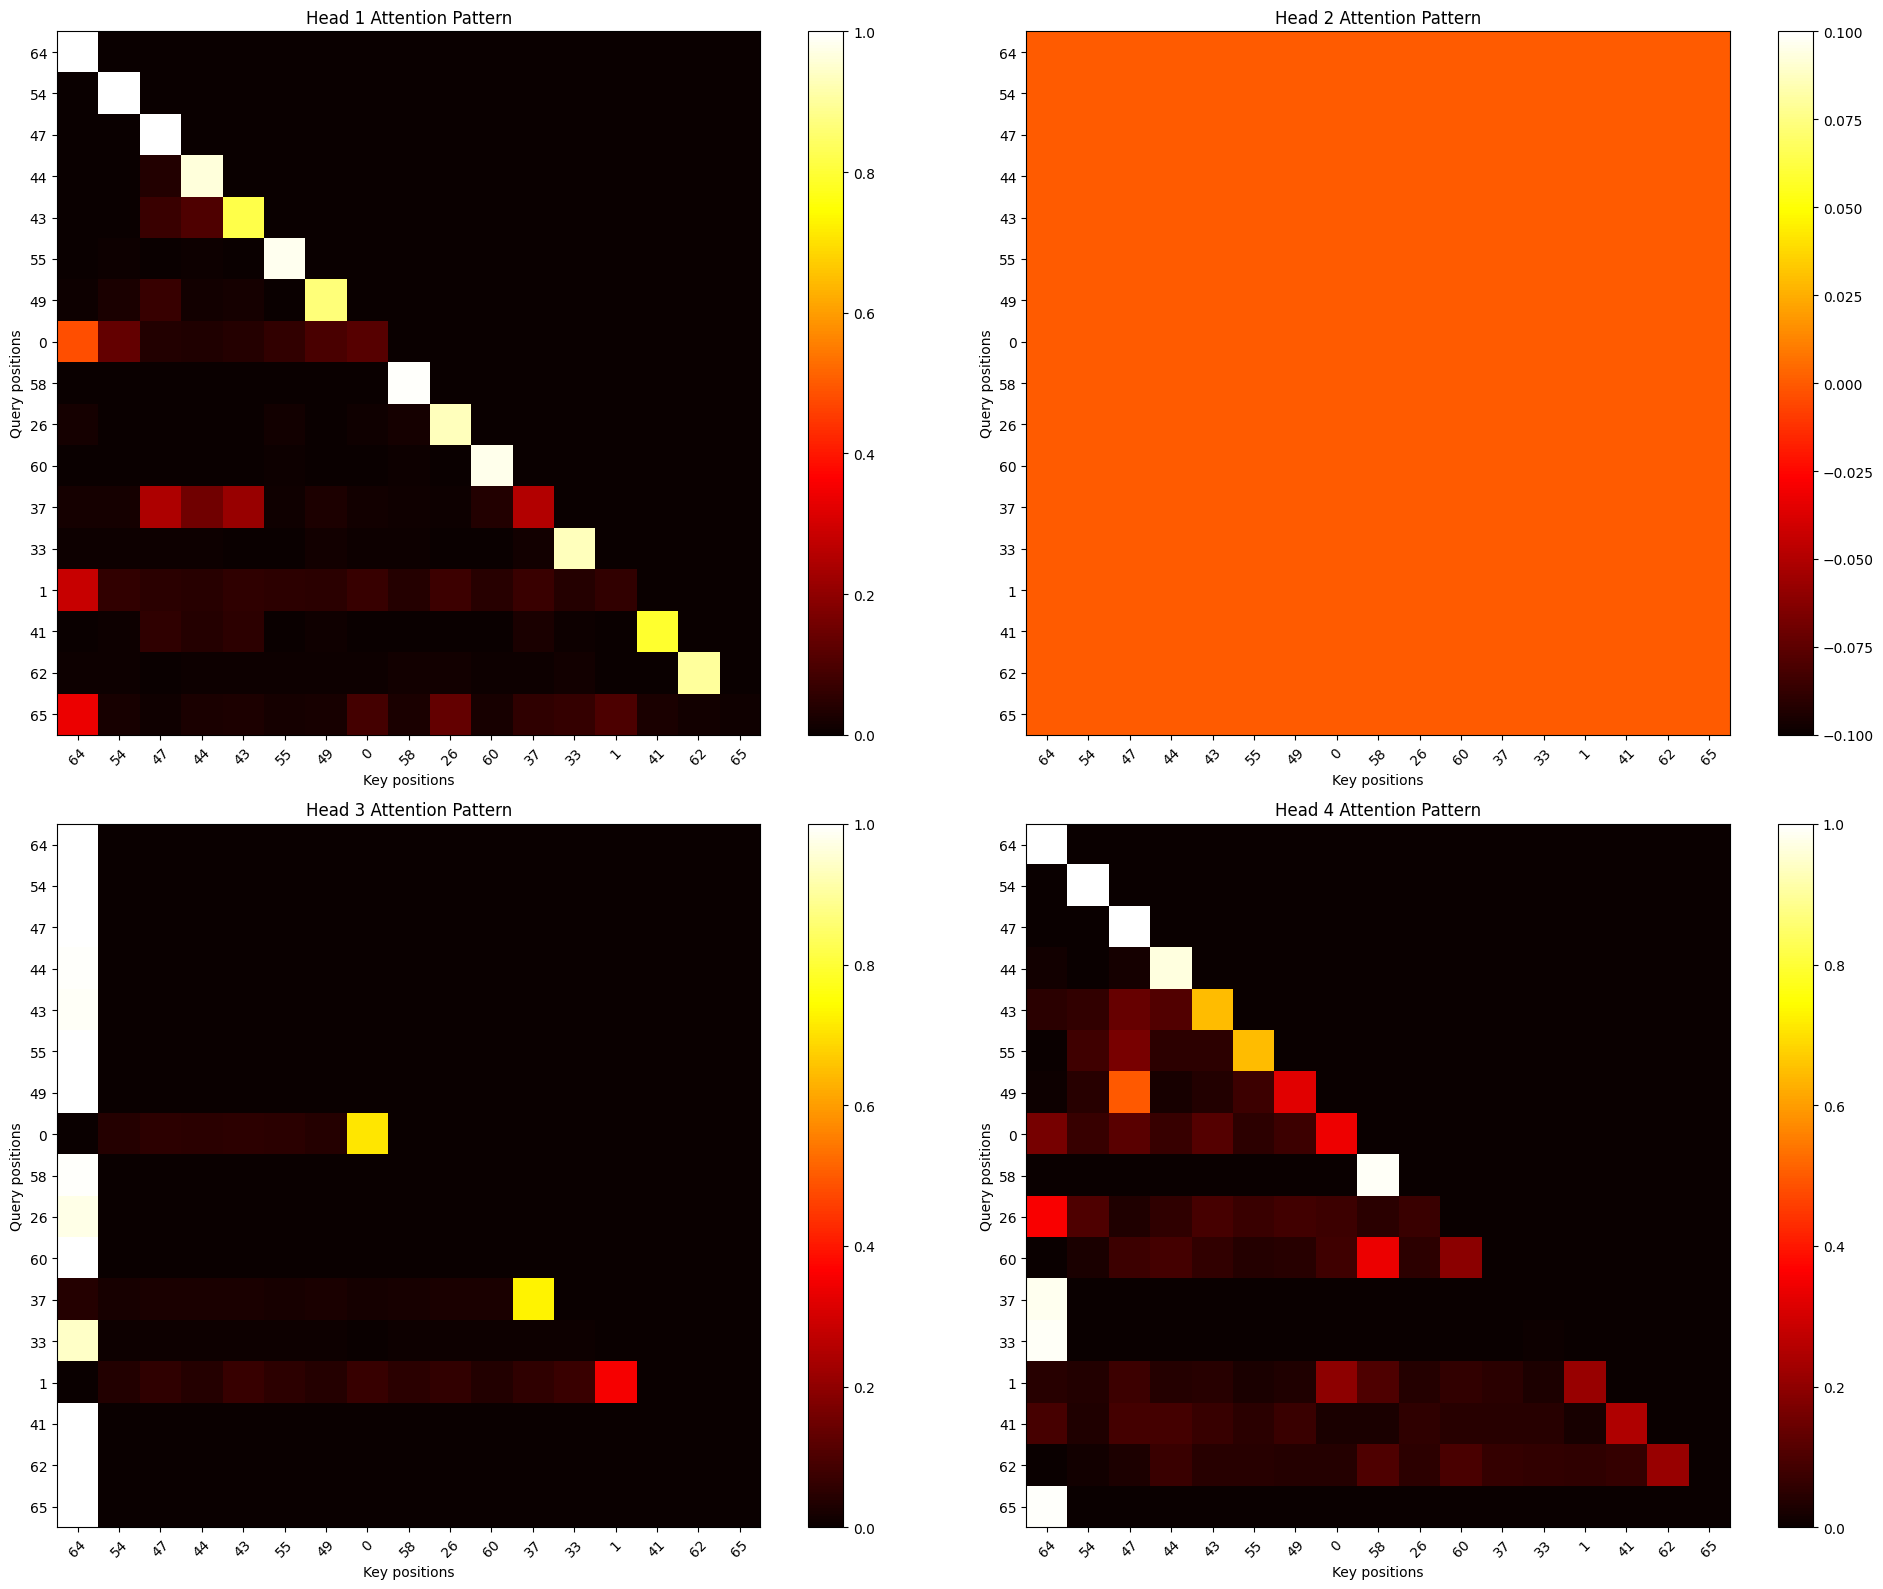


Sample sequence:
Input: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65  0  1 26 33 37 41 43
 44 47 49 54 55 58 60 62 66 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Predicted: [15 54 47 44 43 55 49  0 58 56 60 37 33  1 41 62 65  0  1 26 41 41 41 43
 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43
 43 43 43 

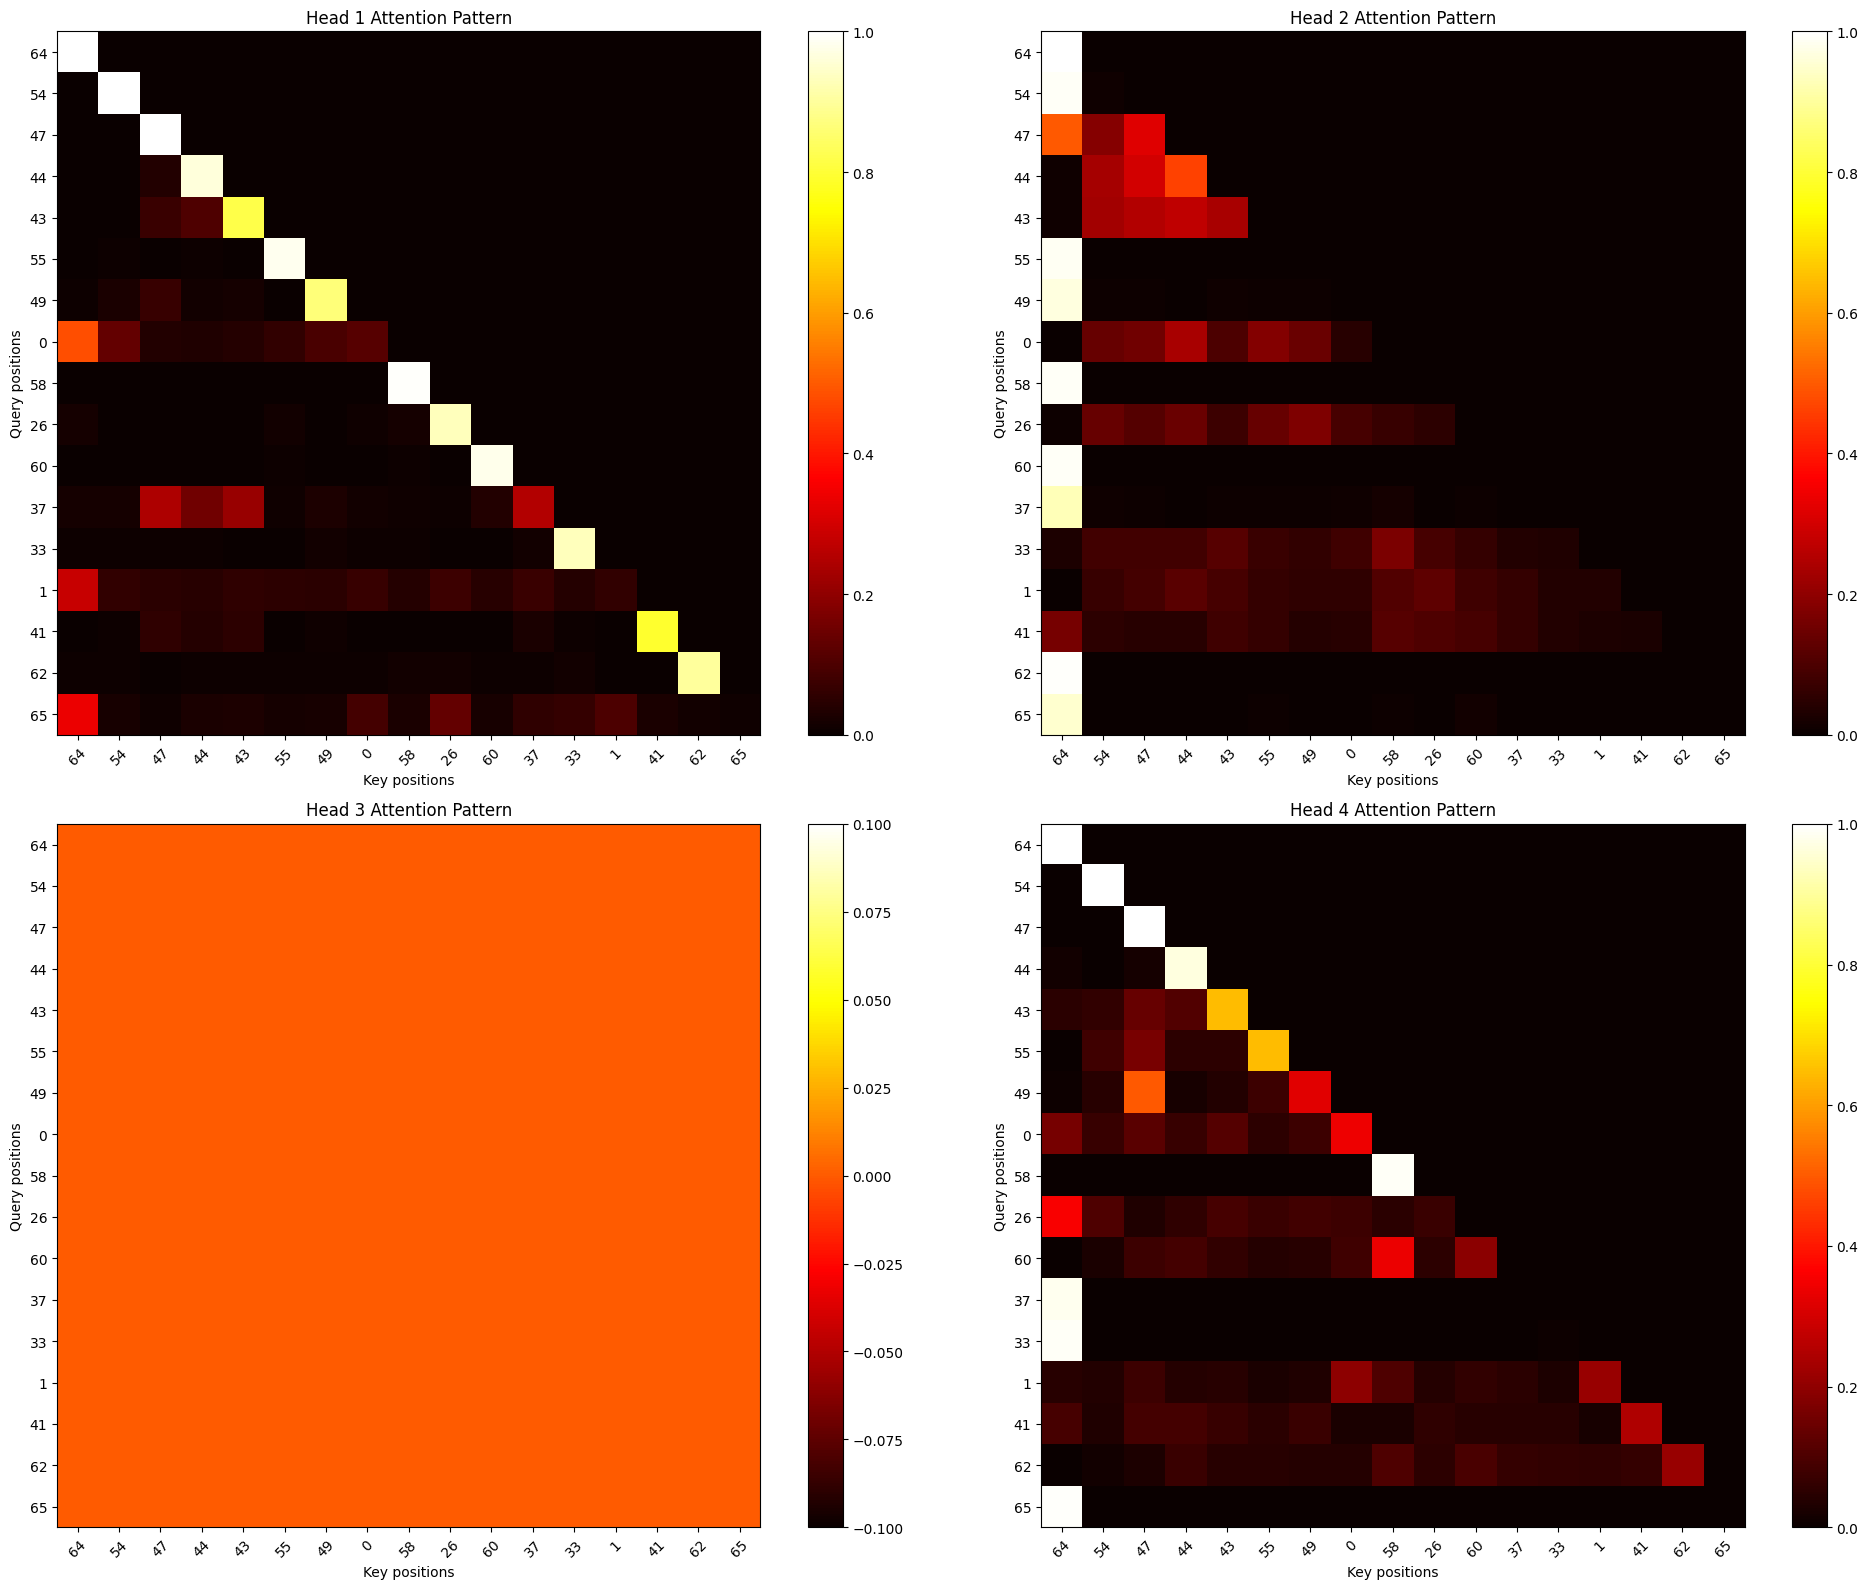


Sample sequence:
Input: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65  0  1 26 33 37 41 43
 44 47 49 54 55 58 60 62 66 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Predicted: [14 54 47 44 43 55 49  0 58 26 60 65 33  0 41 62 65  1  2 16 20 26 30 33
 36 38 41 46 51 54 57 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66
 66 66 66 

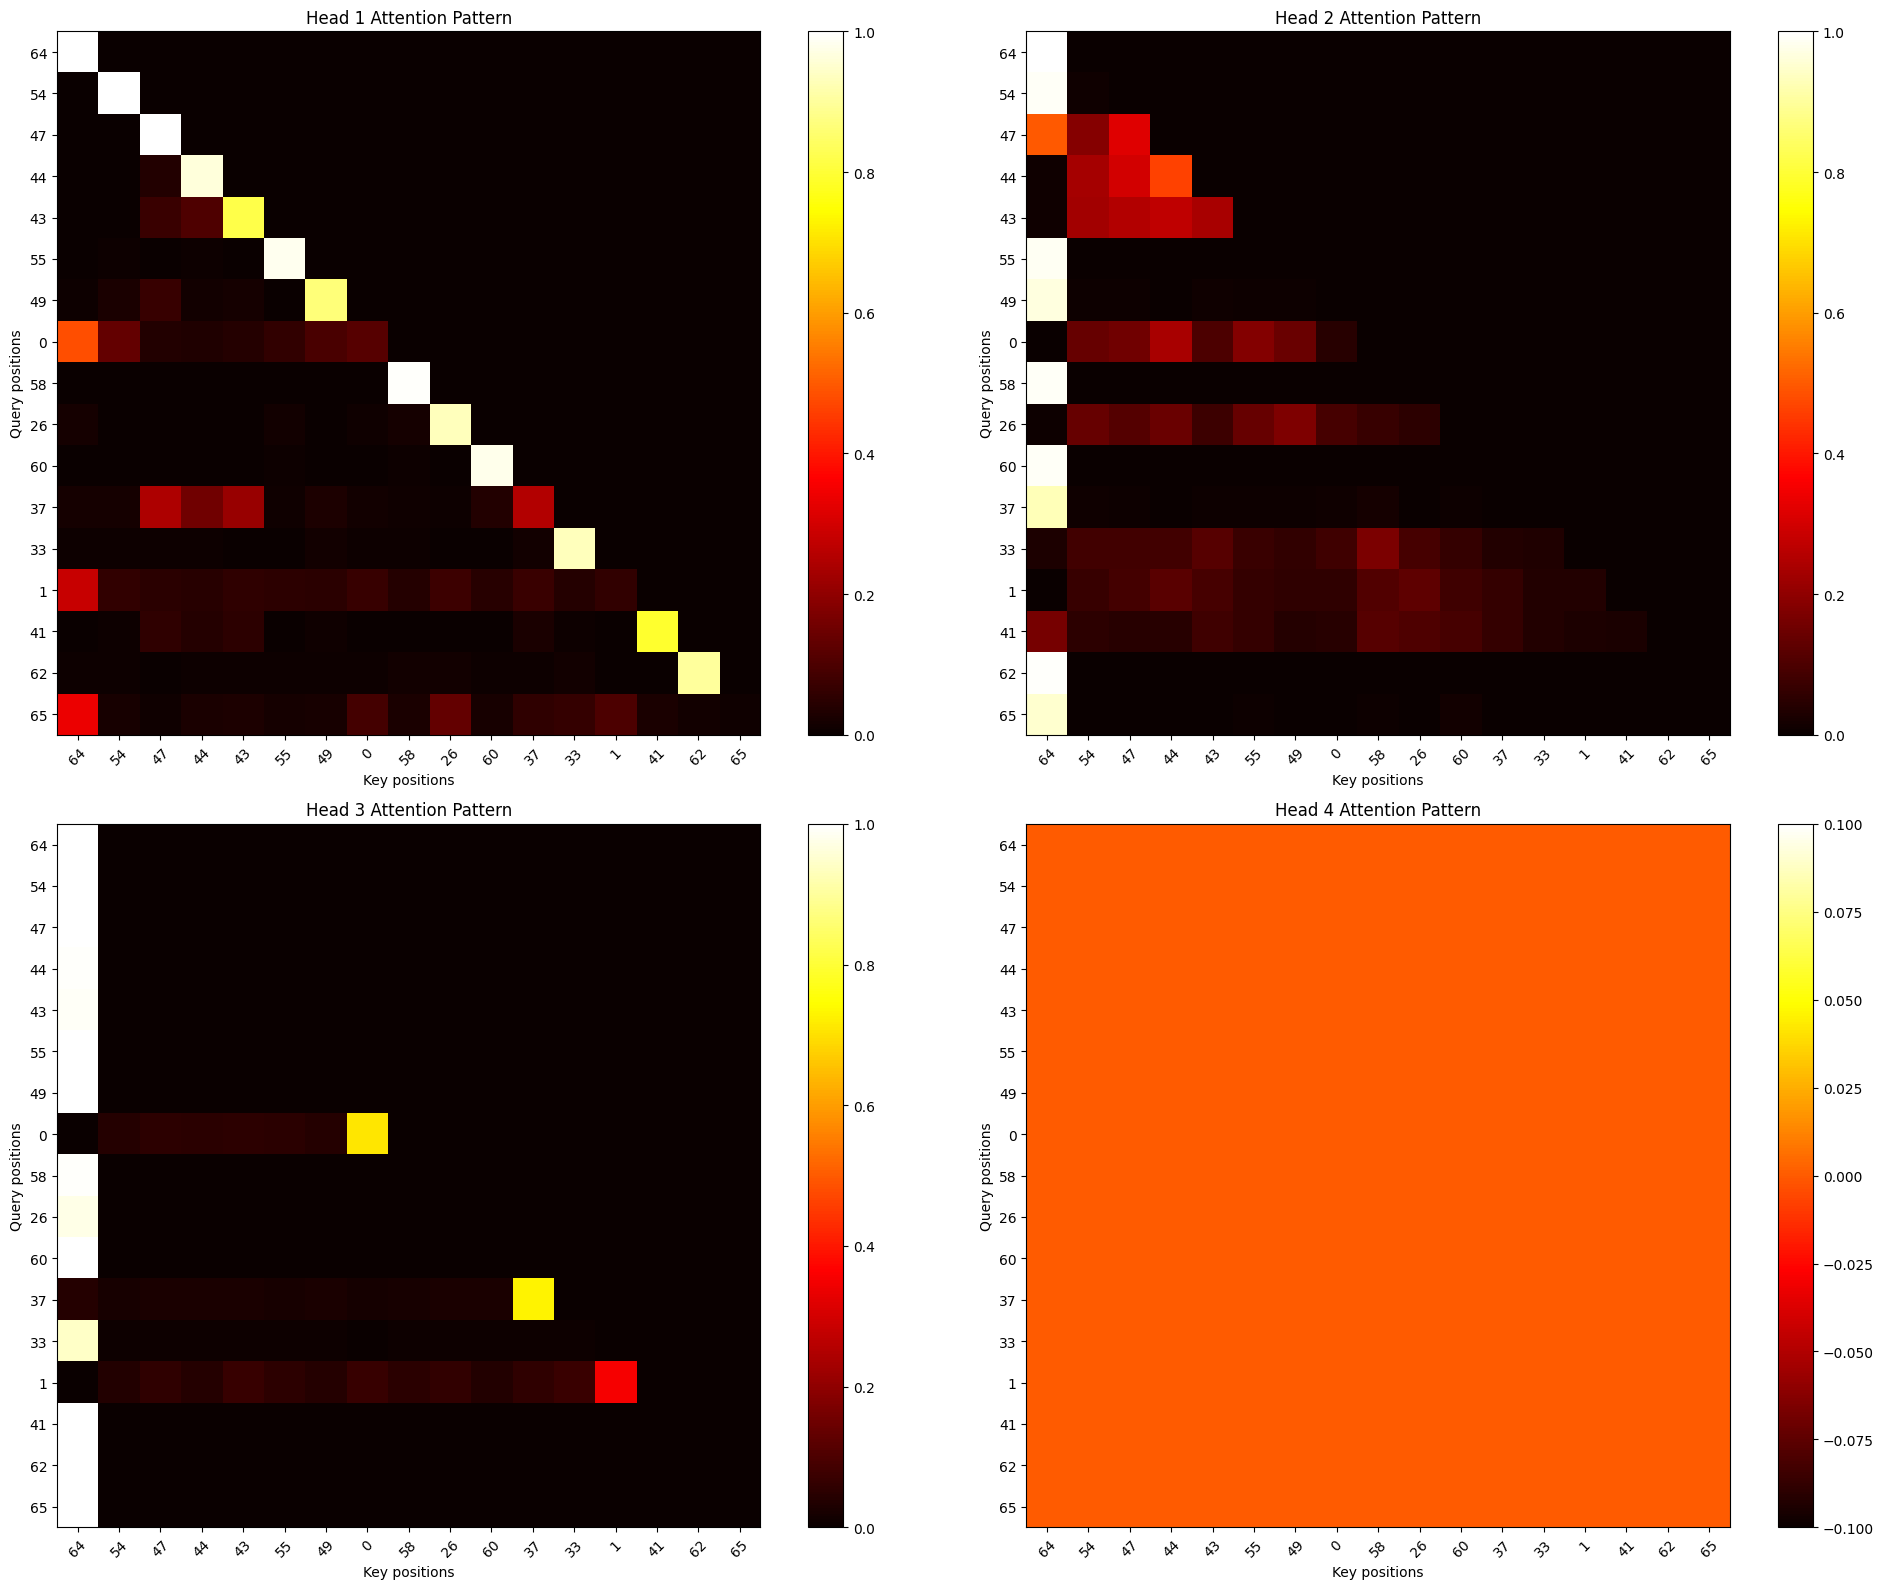


Sample sequence:
Input: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65  0  1 26 33 37 41 43
 44 47 49 54 55 58 60 62 66 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Predicted: [ 7 54 47 44 43 55 49  8 58 26 60 37 33  8 41 62 64  1  0  0  0 43 44 54
 55 55 55 58 60 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66
 66 66 66 

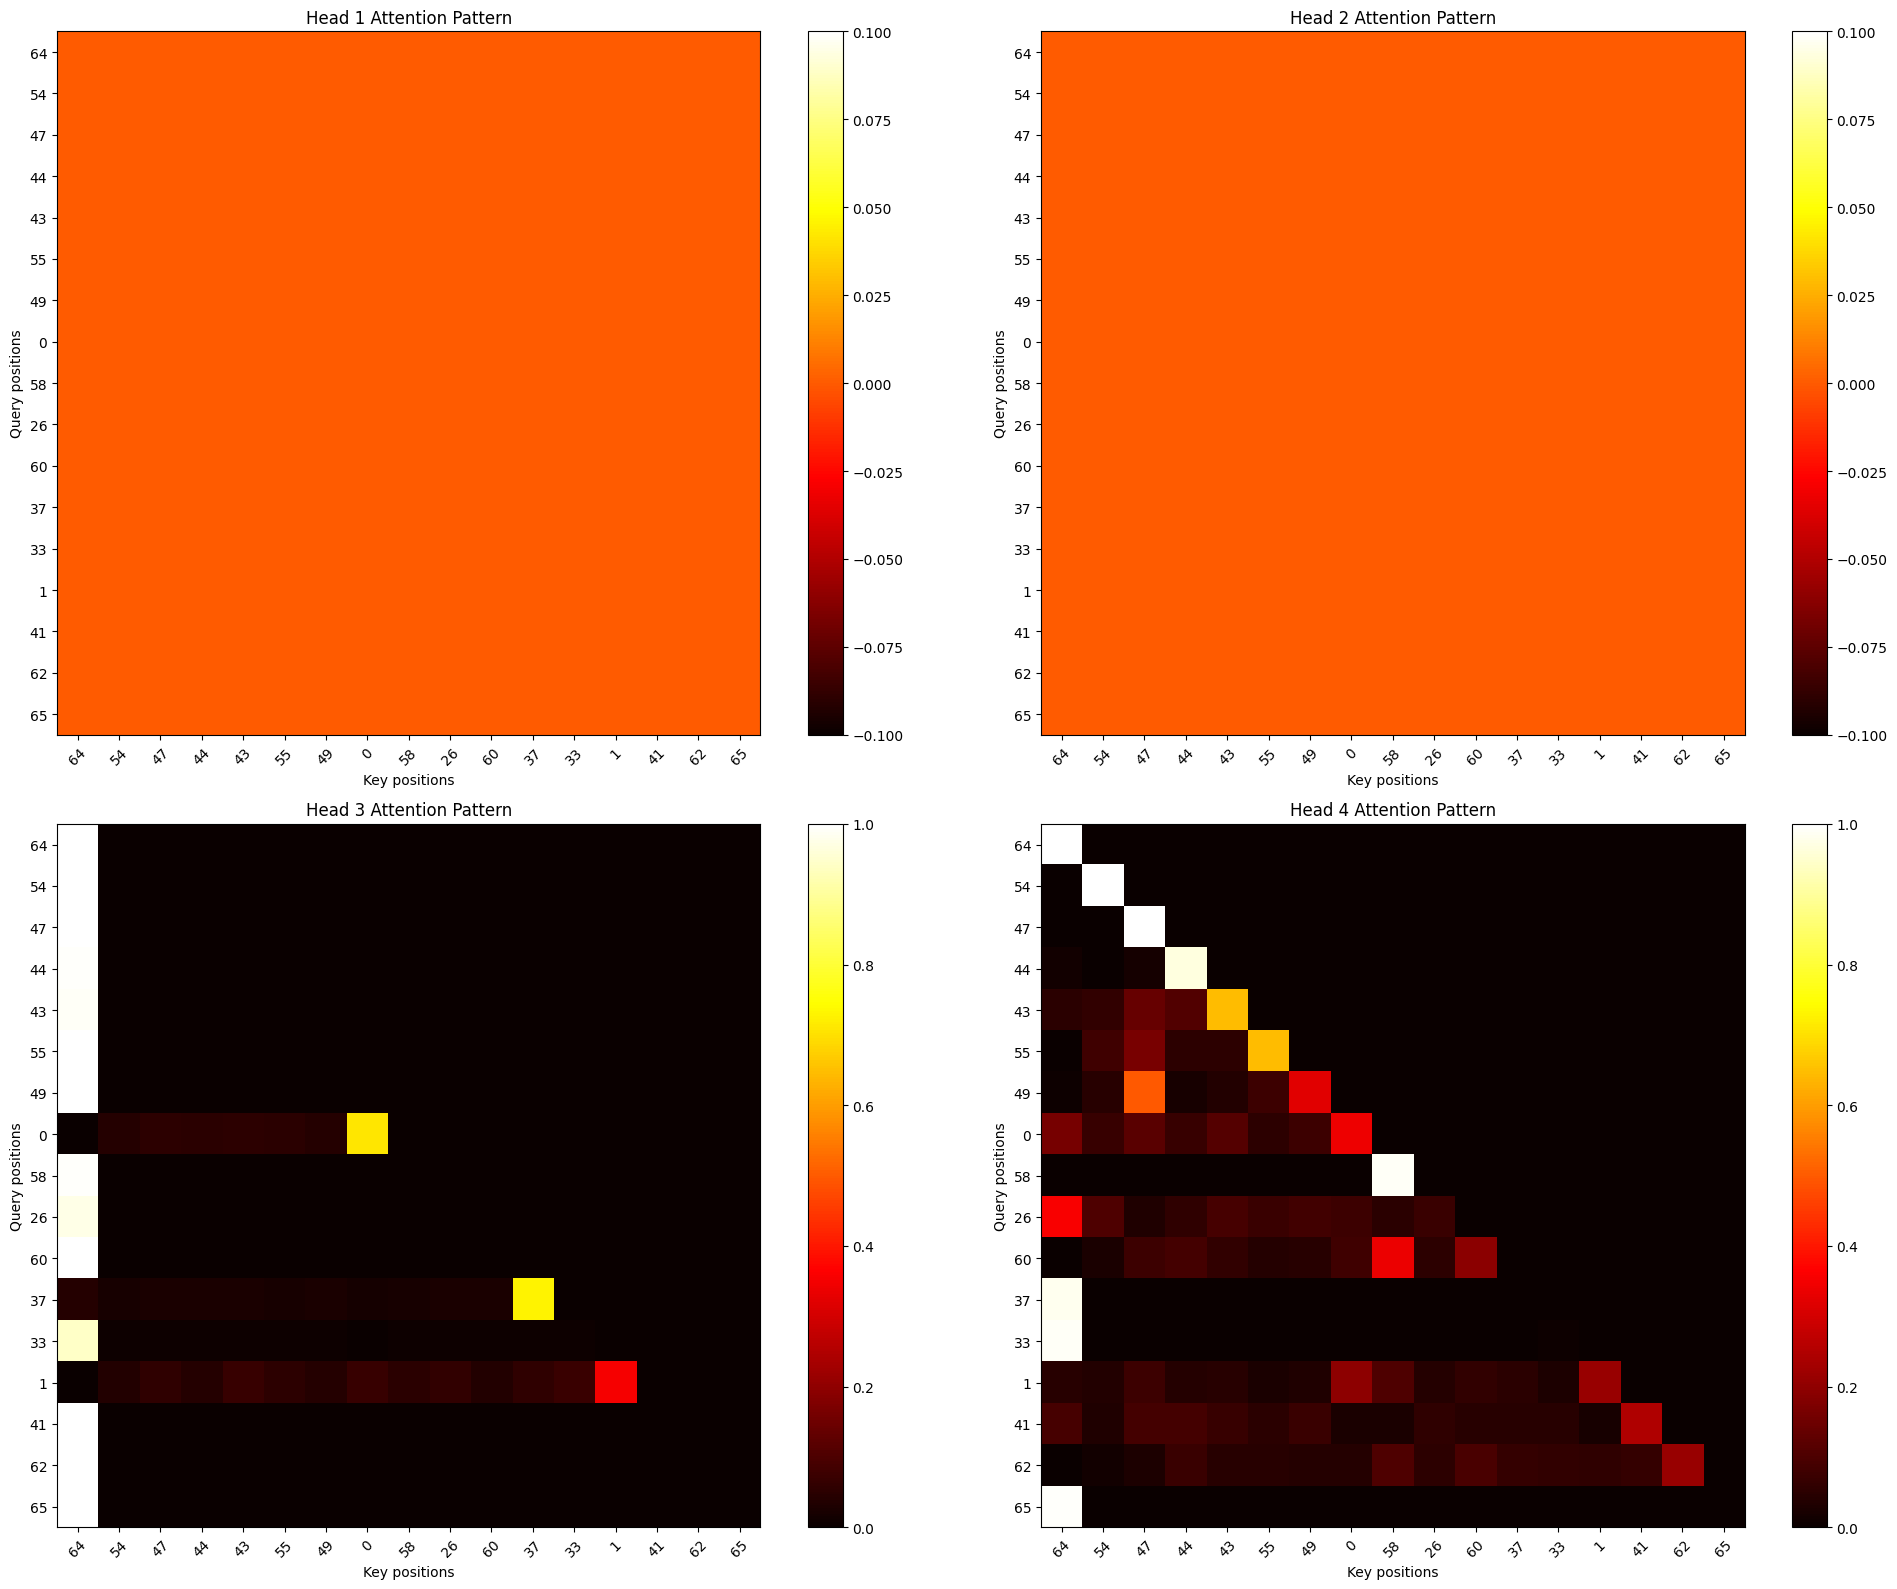


Sample sequence:
Input: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65  0  1 26 33 37 41 43
 44 47 49 54 55 58 60 62 66 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Predicted: [39 54 48 46 46 48 48  0 58 48 57 37 39  0 46 48 39  0 60 60 44 44 44 44
 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44
 44 44 44 

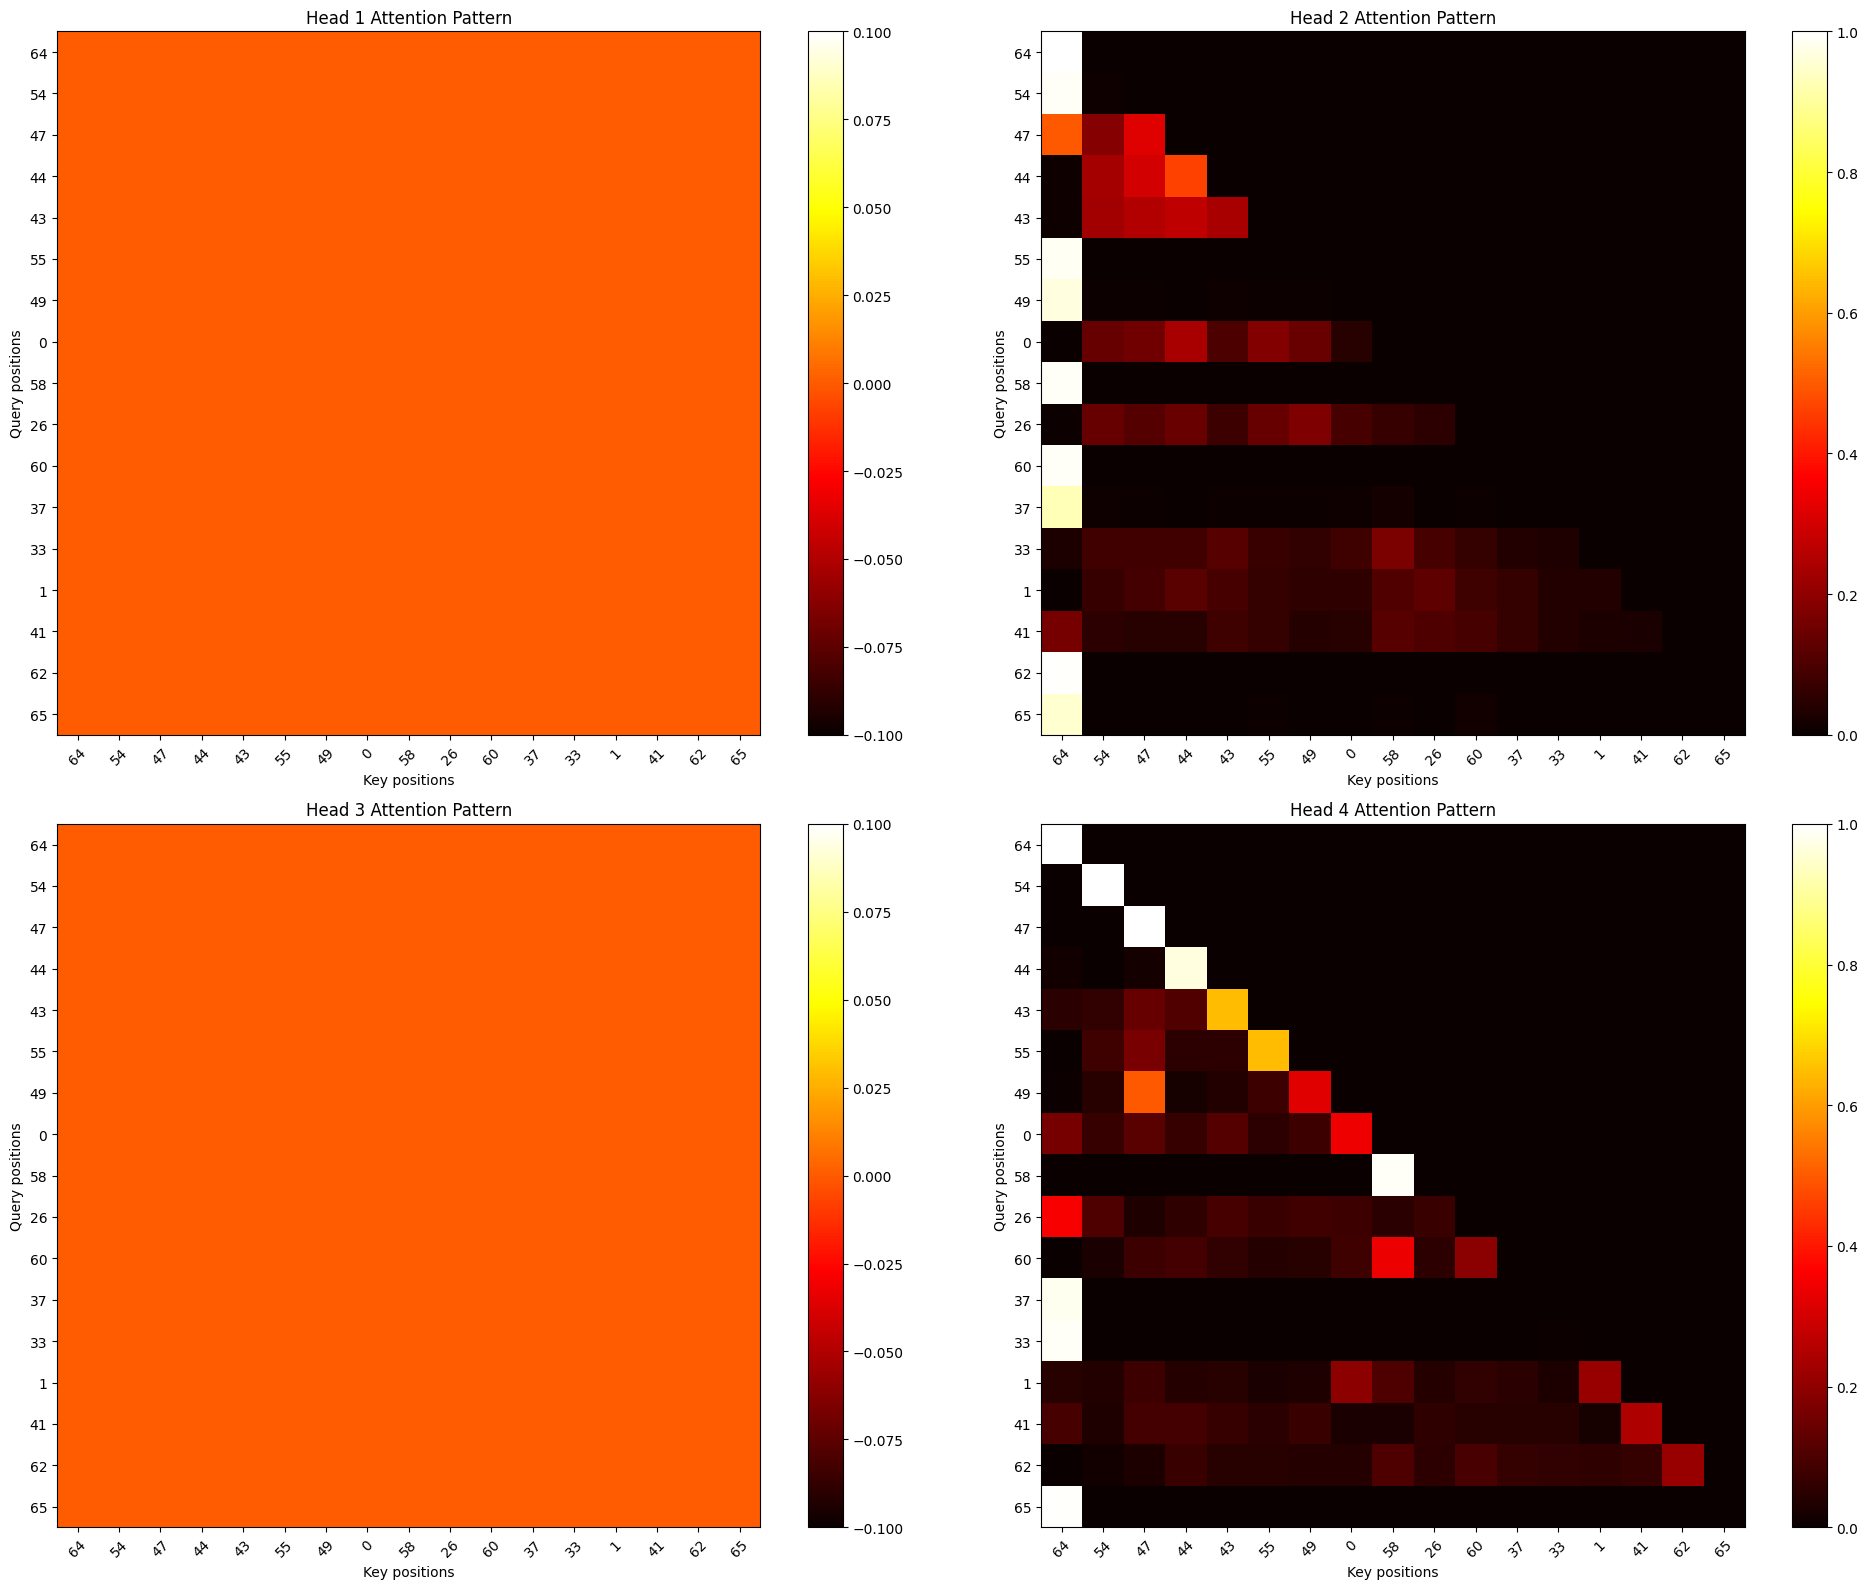


Sample sequence:
Input: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65  0  1 26 33 37 41 43
 44 47 49 54 55 58 60 62 66 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Predicted: [65 54 47 40 28 55 48  0 58 31  0 65 36  0 37  0 65  1 18 20 21 23 23 24
 24 24 52 54 55 56 58 61 61 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63
 63 63 63 

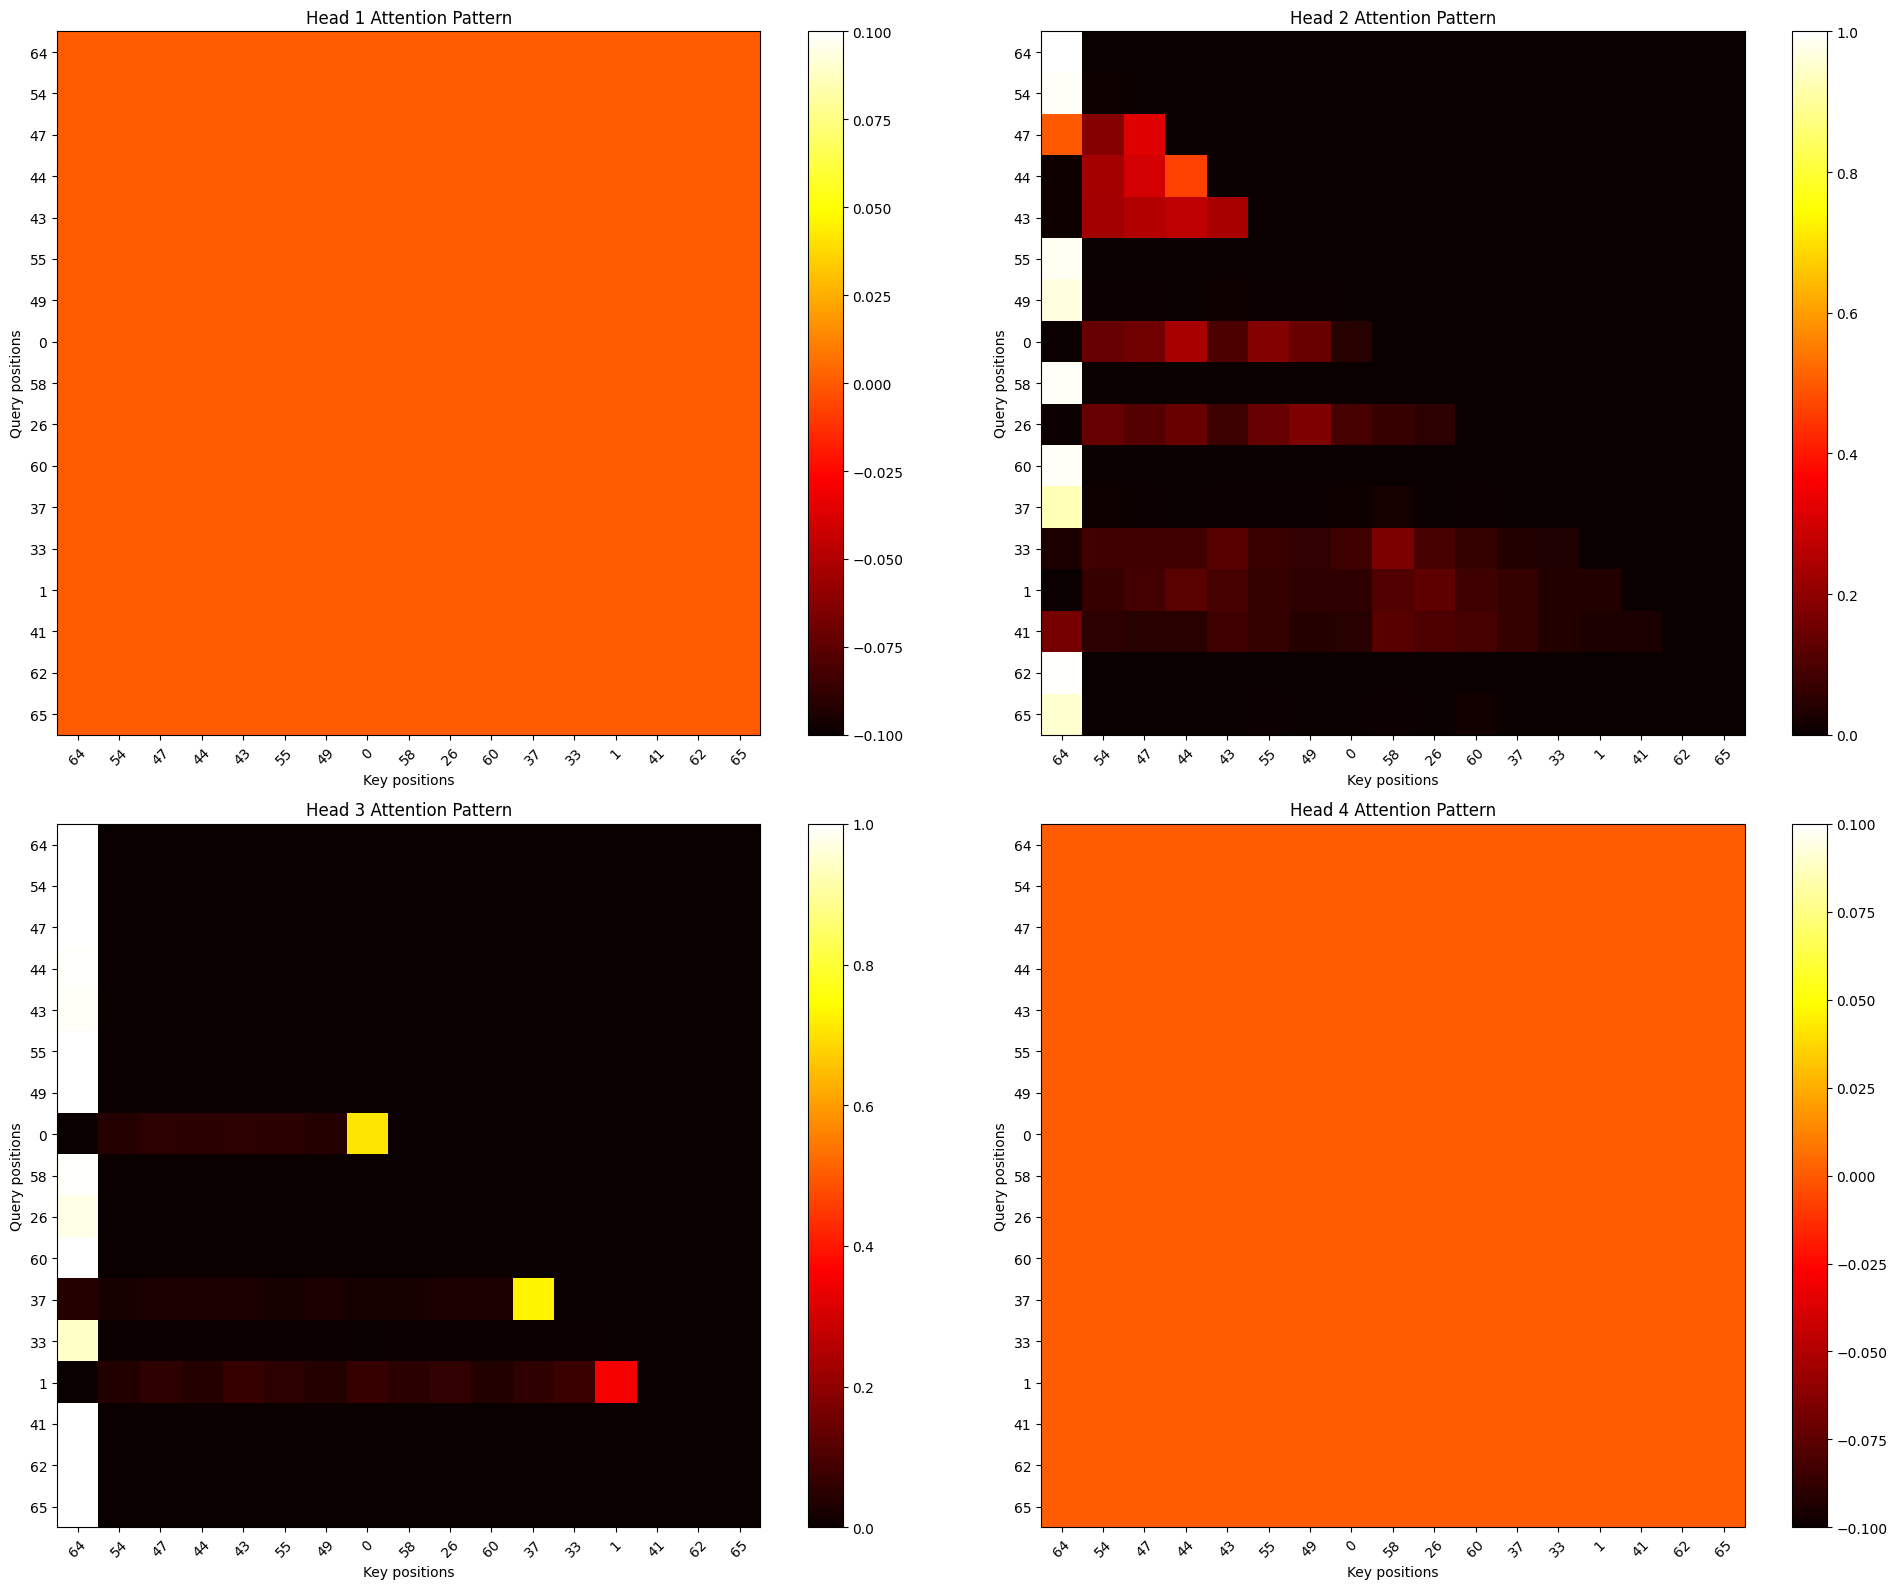


Sample sequence:
Input: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65  0  1 26 33 37 41 43
 44 47 49 54 55 58 60 62 66 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Predicted: [56 52 41 36 36 52 52  8 52 34 52 37 34  8 36 52 52 43 44 44 60 60 60 58
 58 58 58 58 60 62 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66
 66 66 66 

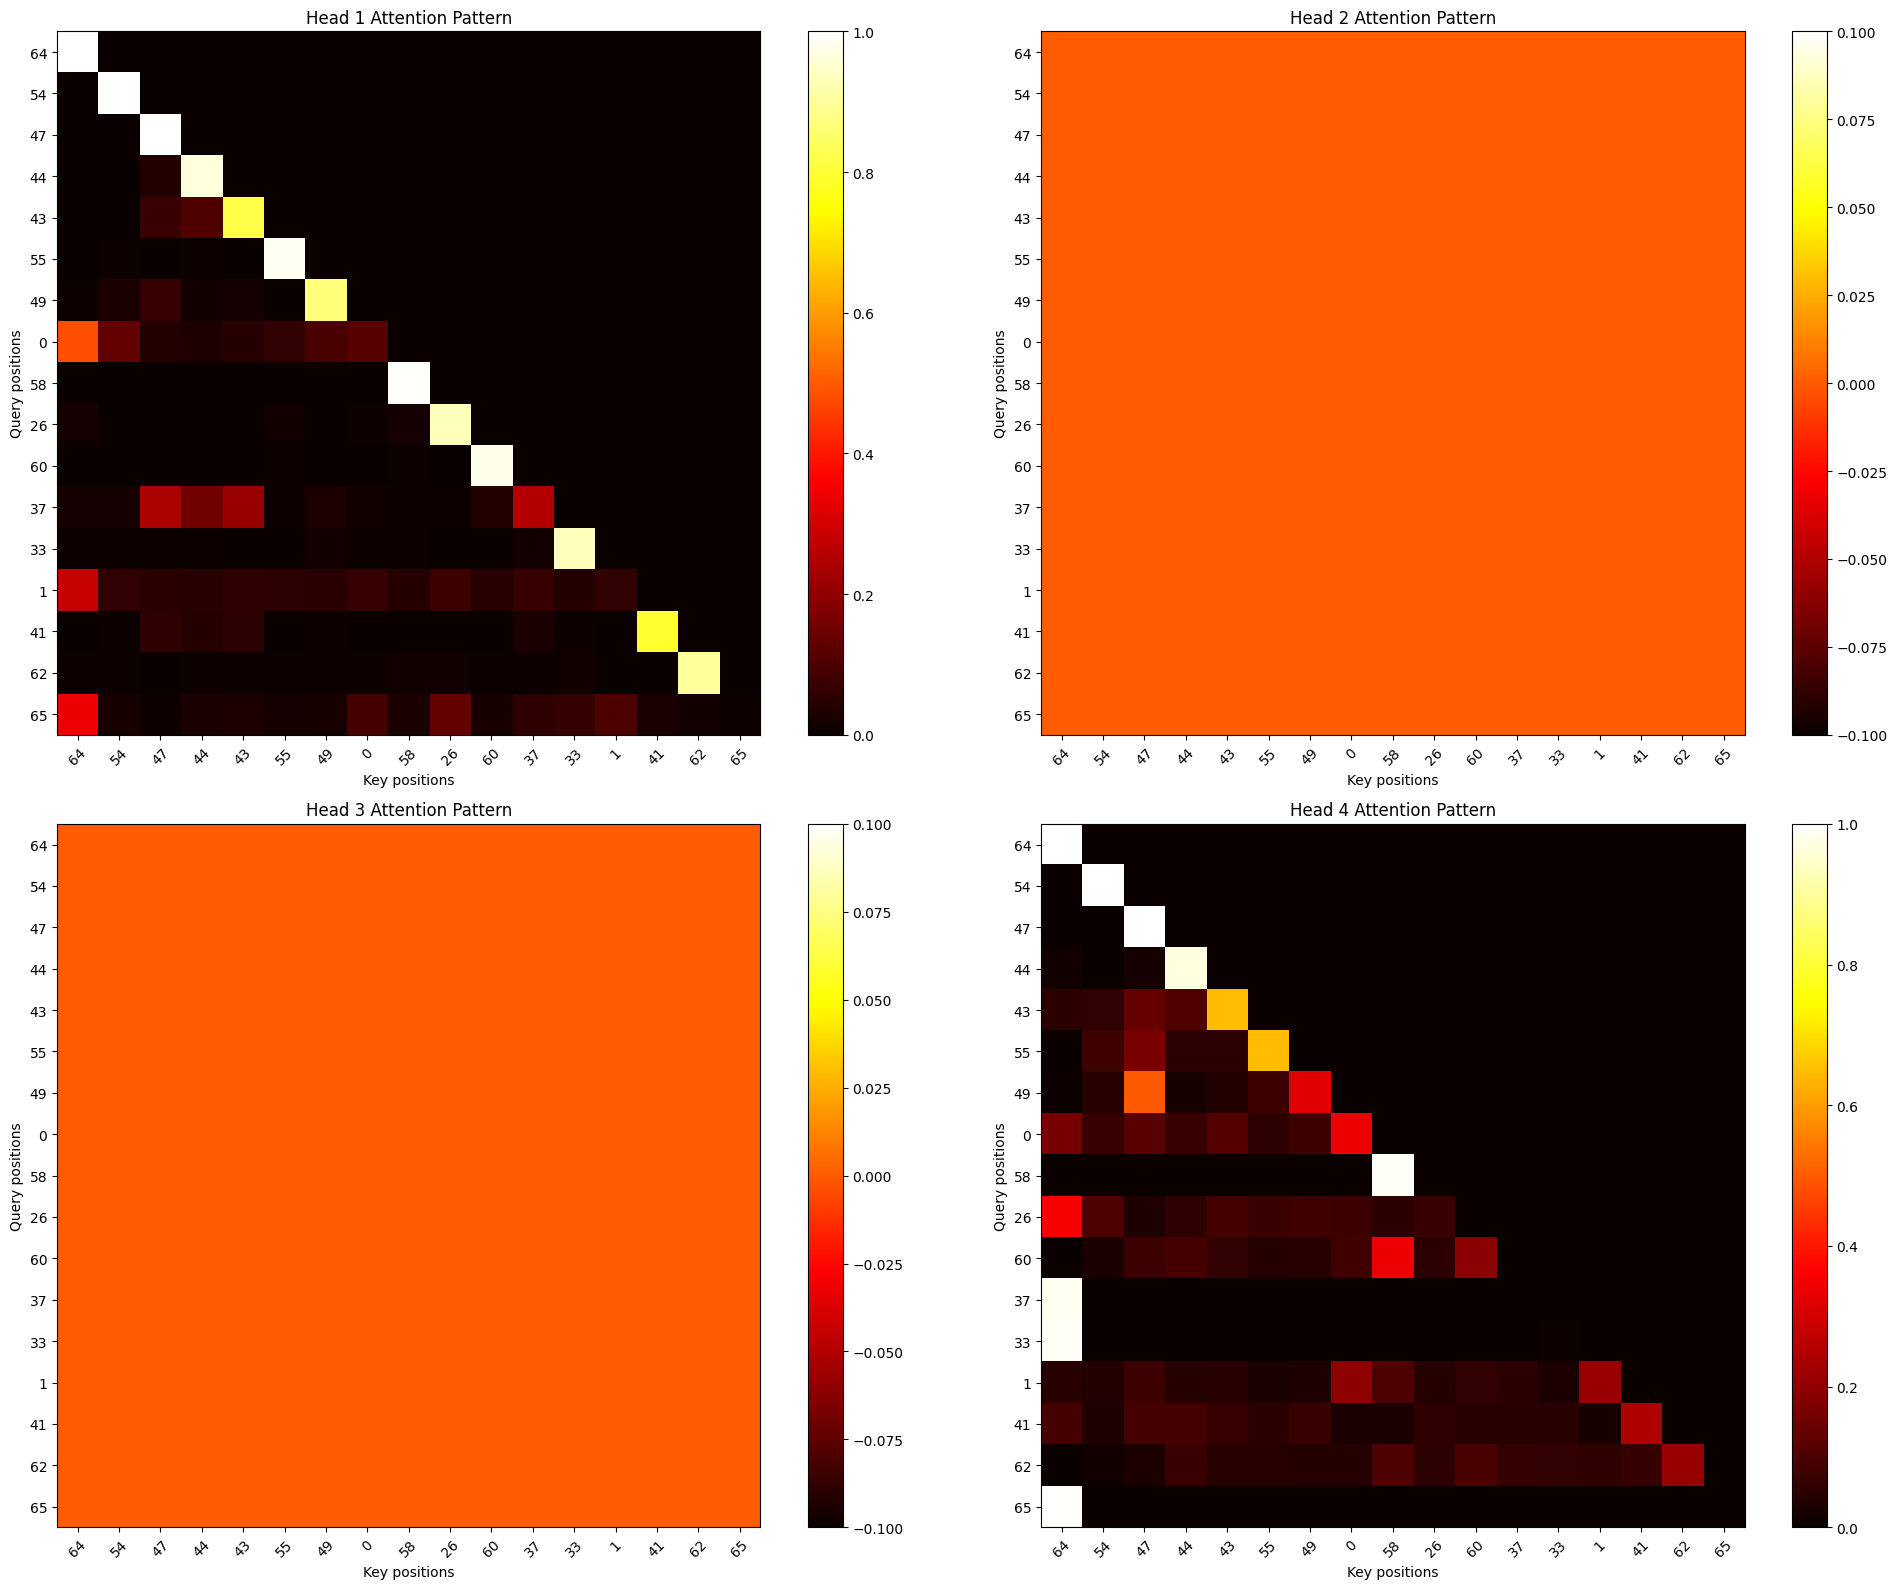


Sample sequence:
Input: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65  0  1 26 33 37 41 43
 44 47 49 54 55 58 60 62 66 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Predicted: [14 54 47 44 43 55 49  0 58 26 60 65 65  0 41 62 18  0  1 15 19 26 31 33
 35 35 36 37 37 38 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 

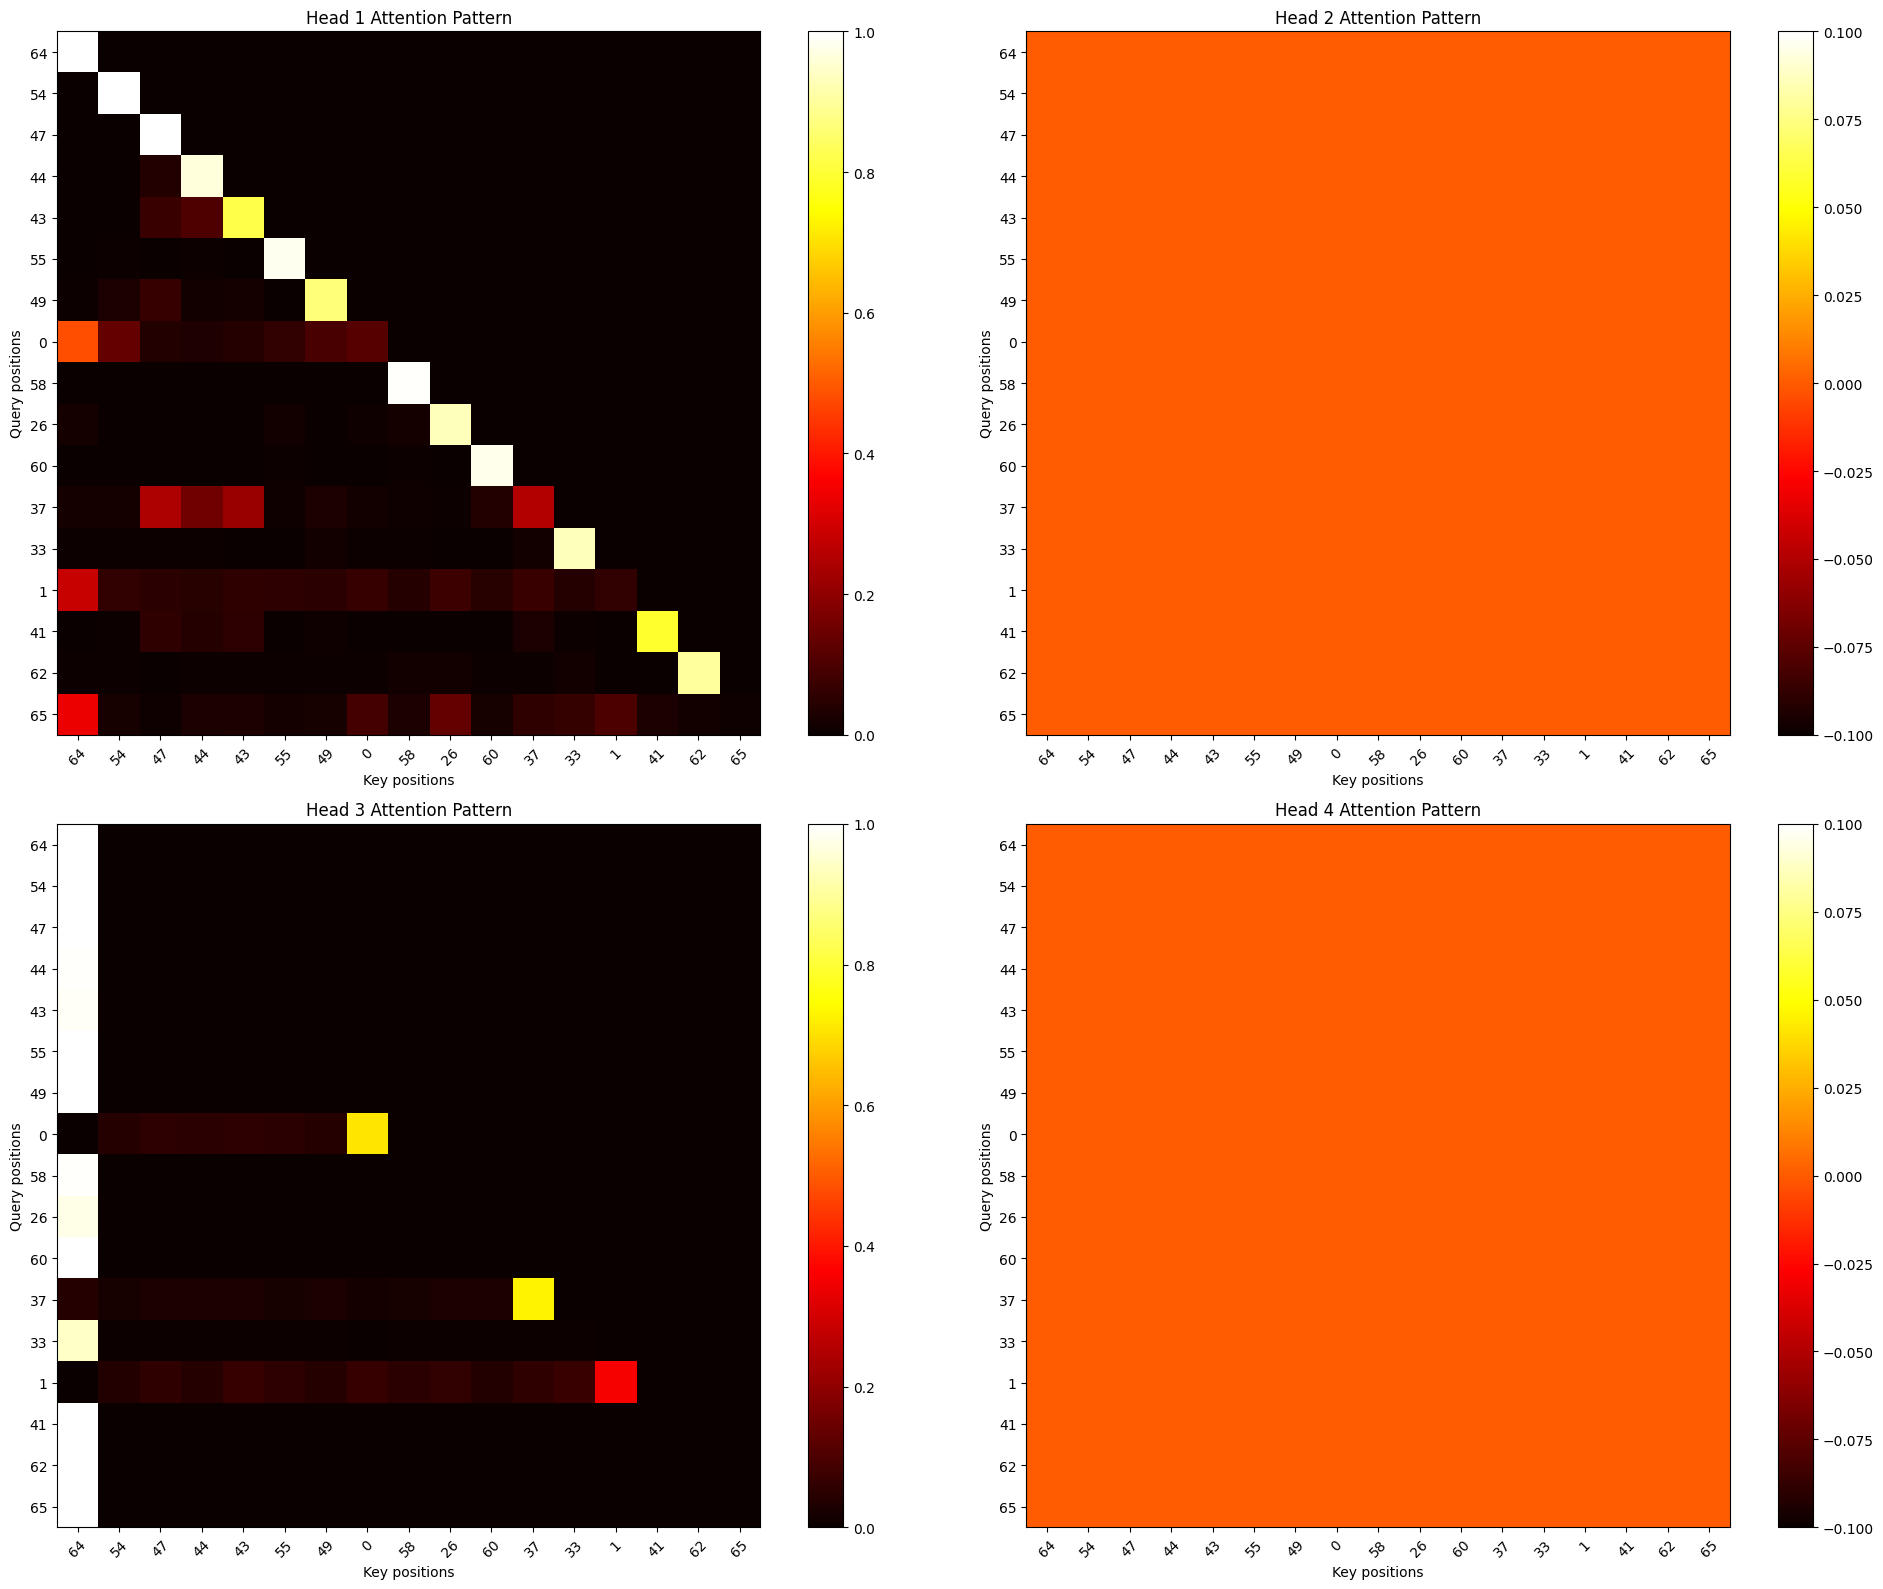


Sample sequence:
Input: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65  0  1 26 33 37 41 43
 44 47 49 54 55 58 60 62 66 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Predicted: [ 8 54 47 44 43 55 49  0 58 56 60 37 56  8 41 62 14  0  0  0 66 66 66 66
 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66
 66 66 66 

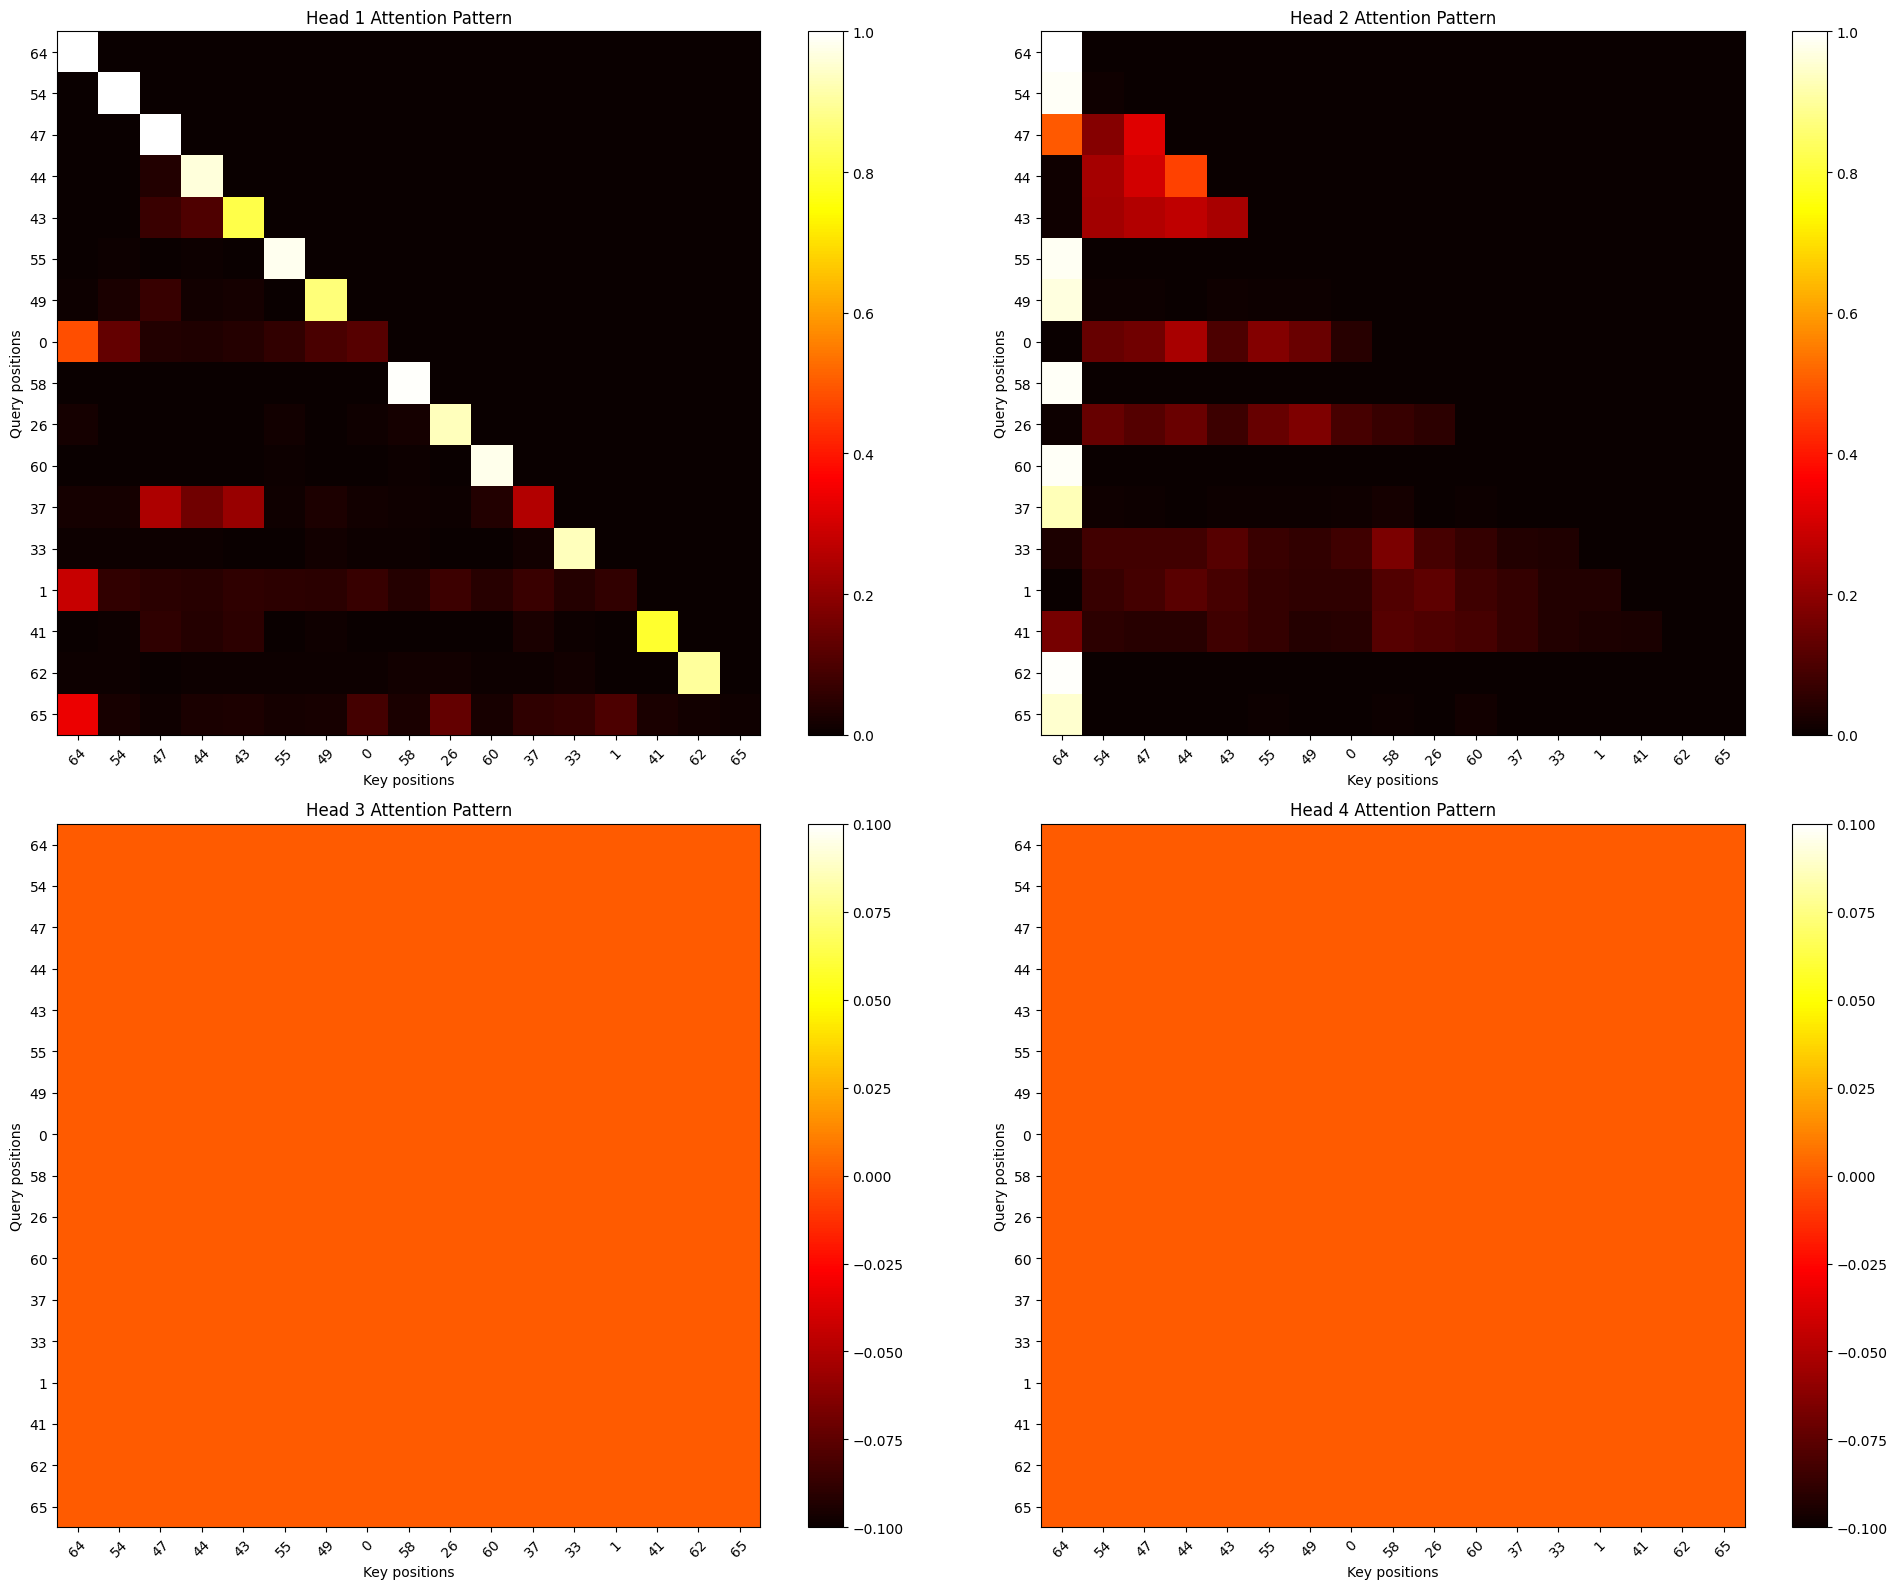


Sample sequence:
Input: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65  0  1 26 33 37 41 43
 44 47 49 54 55 58 60 62 66 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Predicted: [ 5 54 47 16 17 55 49  9 58 18 60 52 18 10 18 62  8  9  5  1  0  0  0  0
  0 54 54 55 57 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66
 66 66 66 

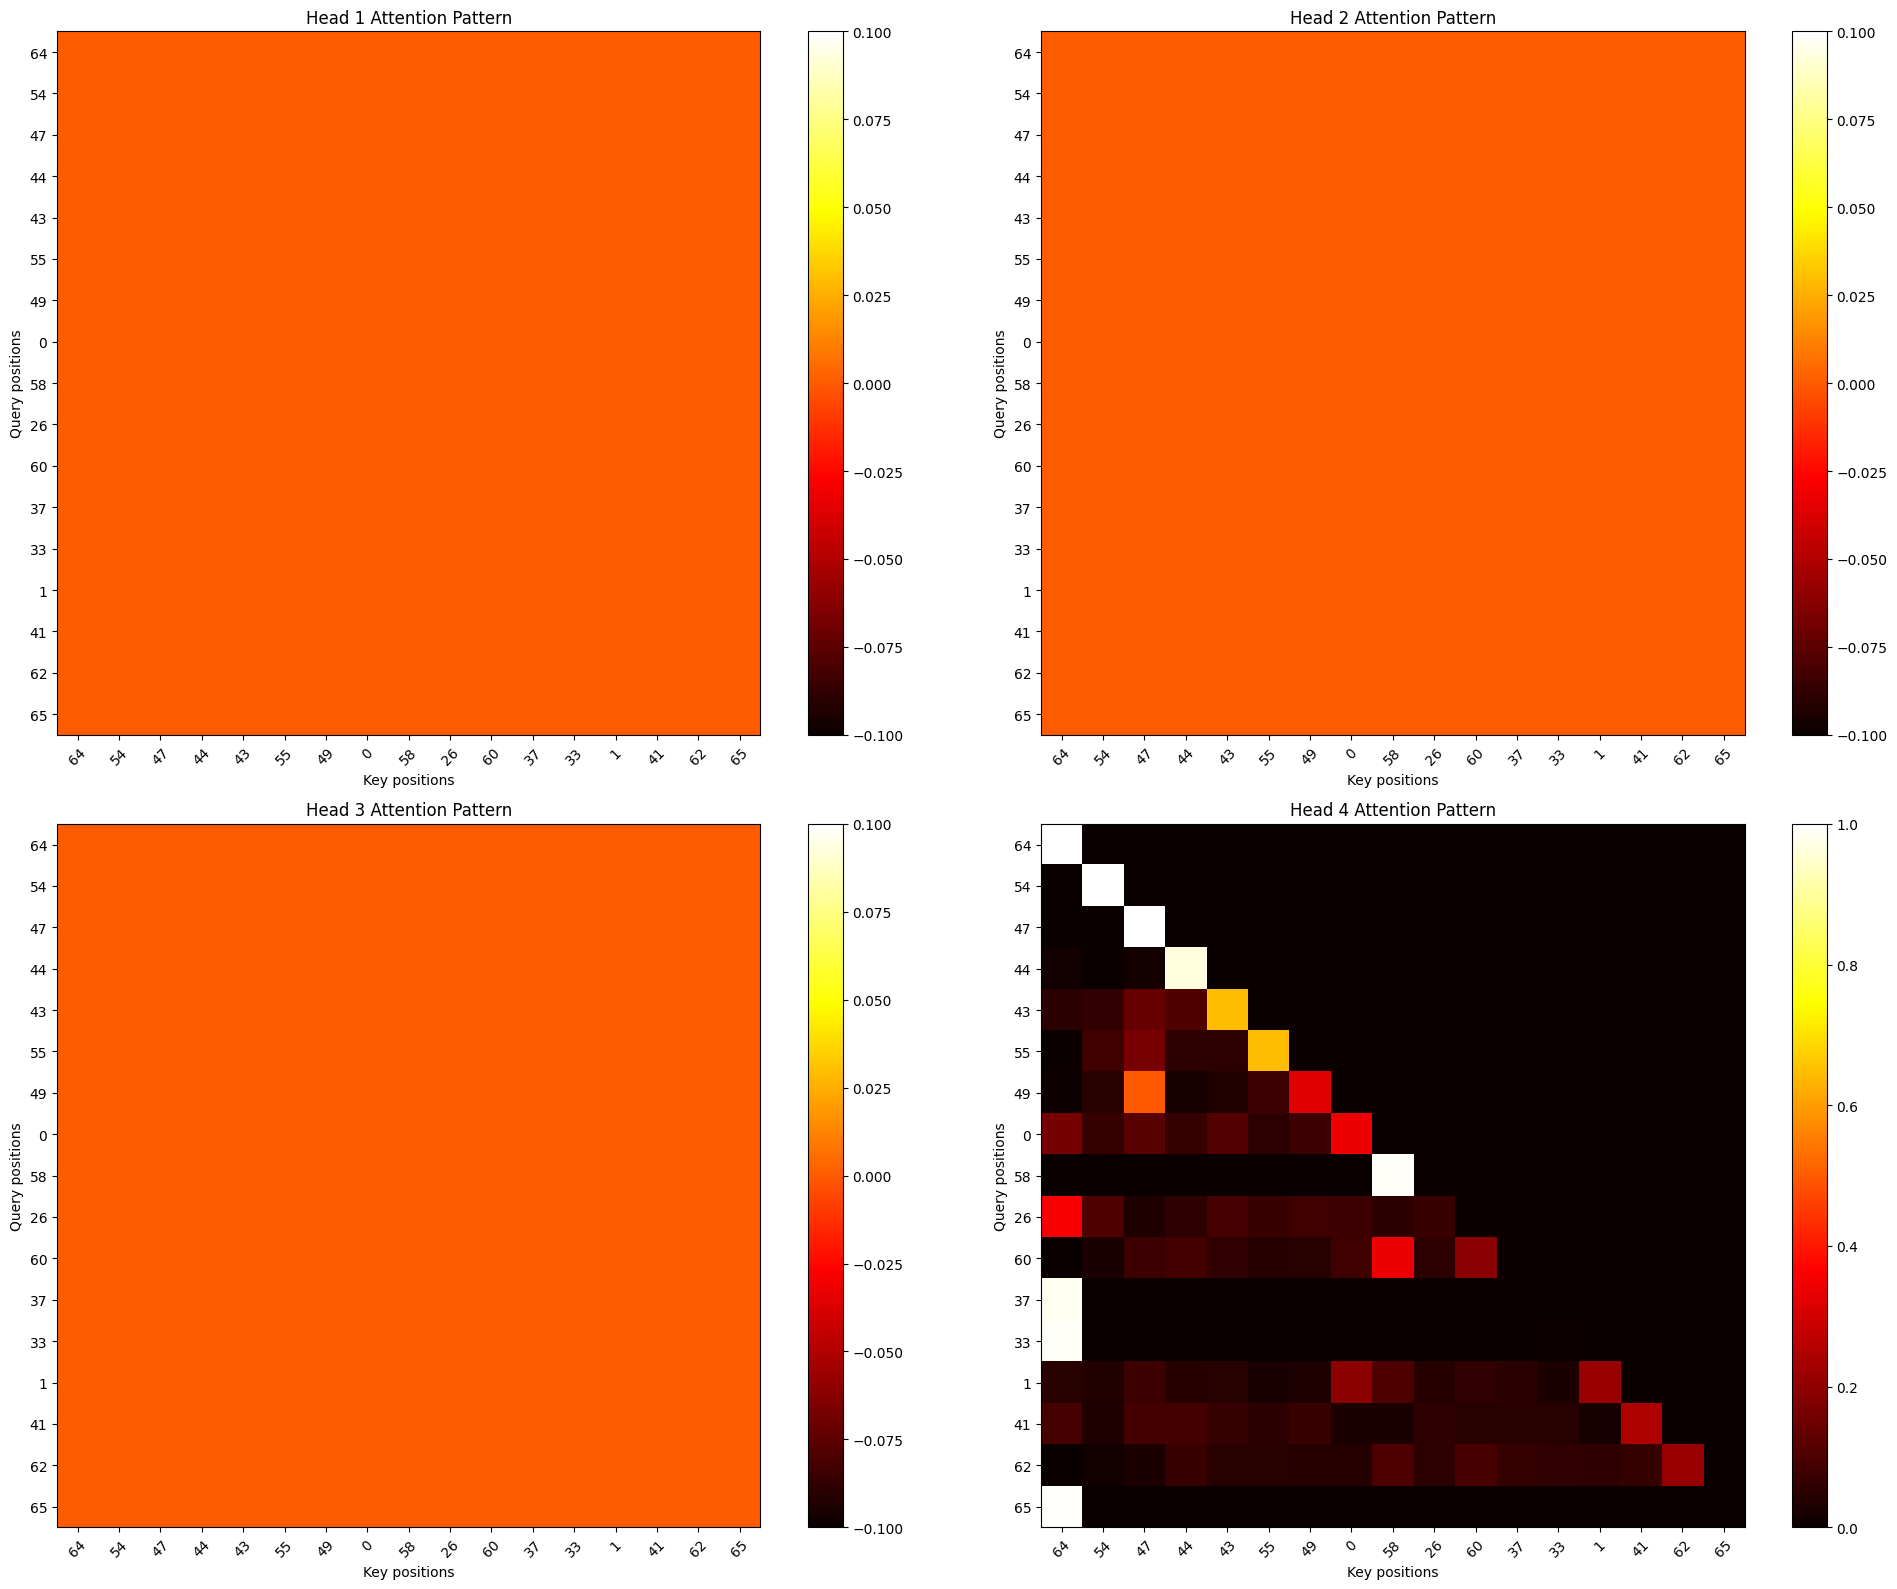


Sample sequence:
Input: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65  0  1 26 33 37 41 43
 44 47 49 54 55 58 60 62 66 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Predicted: [36 54 47 44 46 55 47  0  0 44  0 65 65  0 45  0 65  0  1 20 21 21 23 23
 23 23 23 23 23 23 23 23 23 23 23 23 23 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 

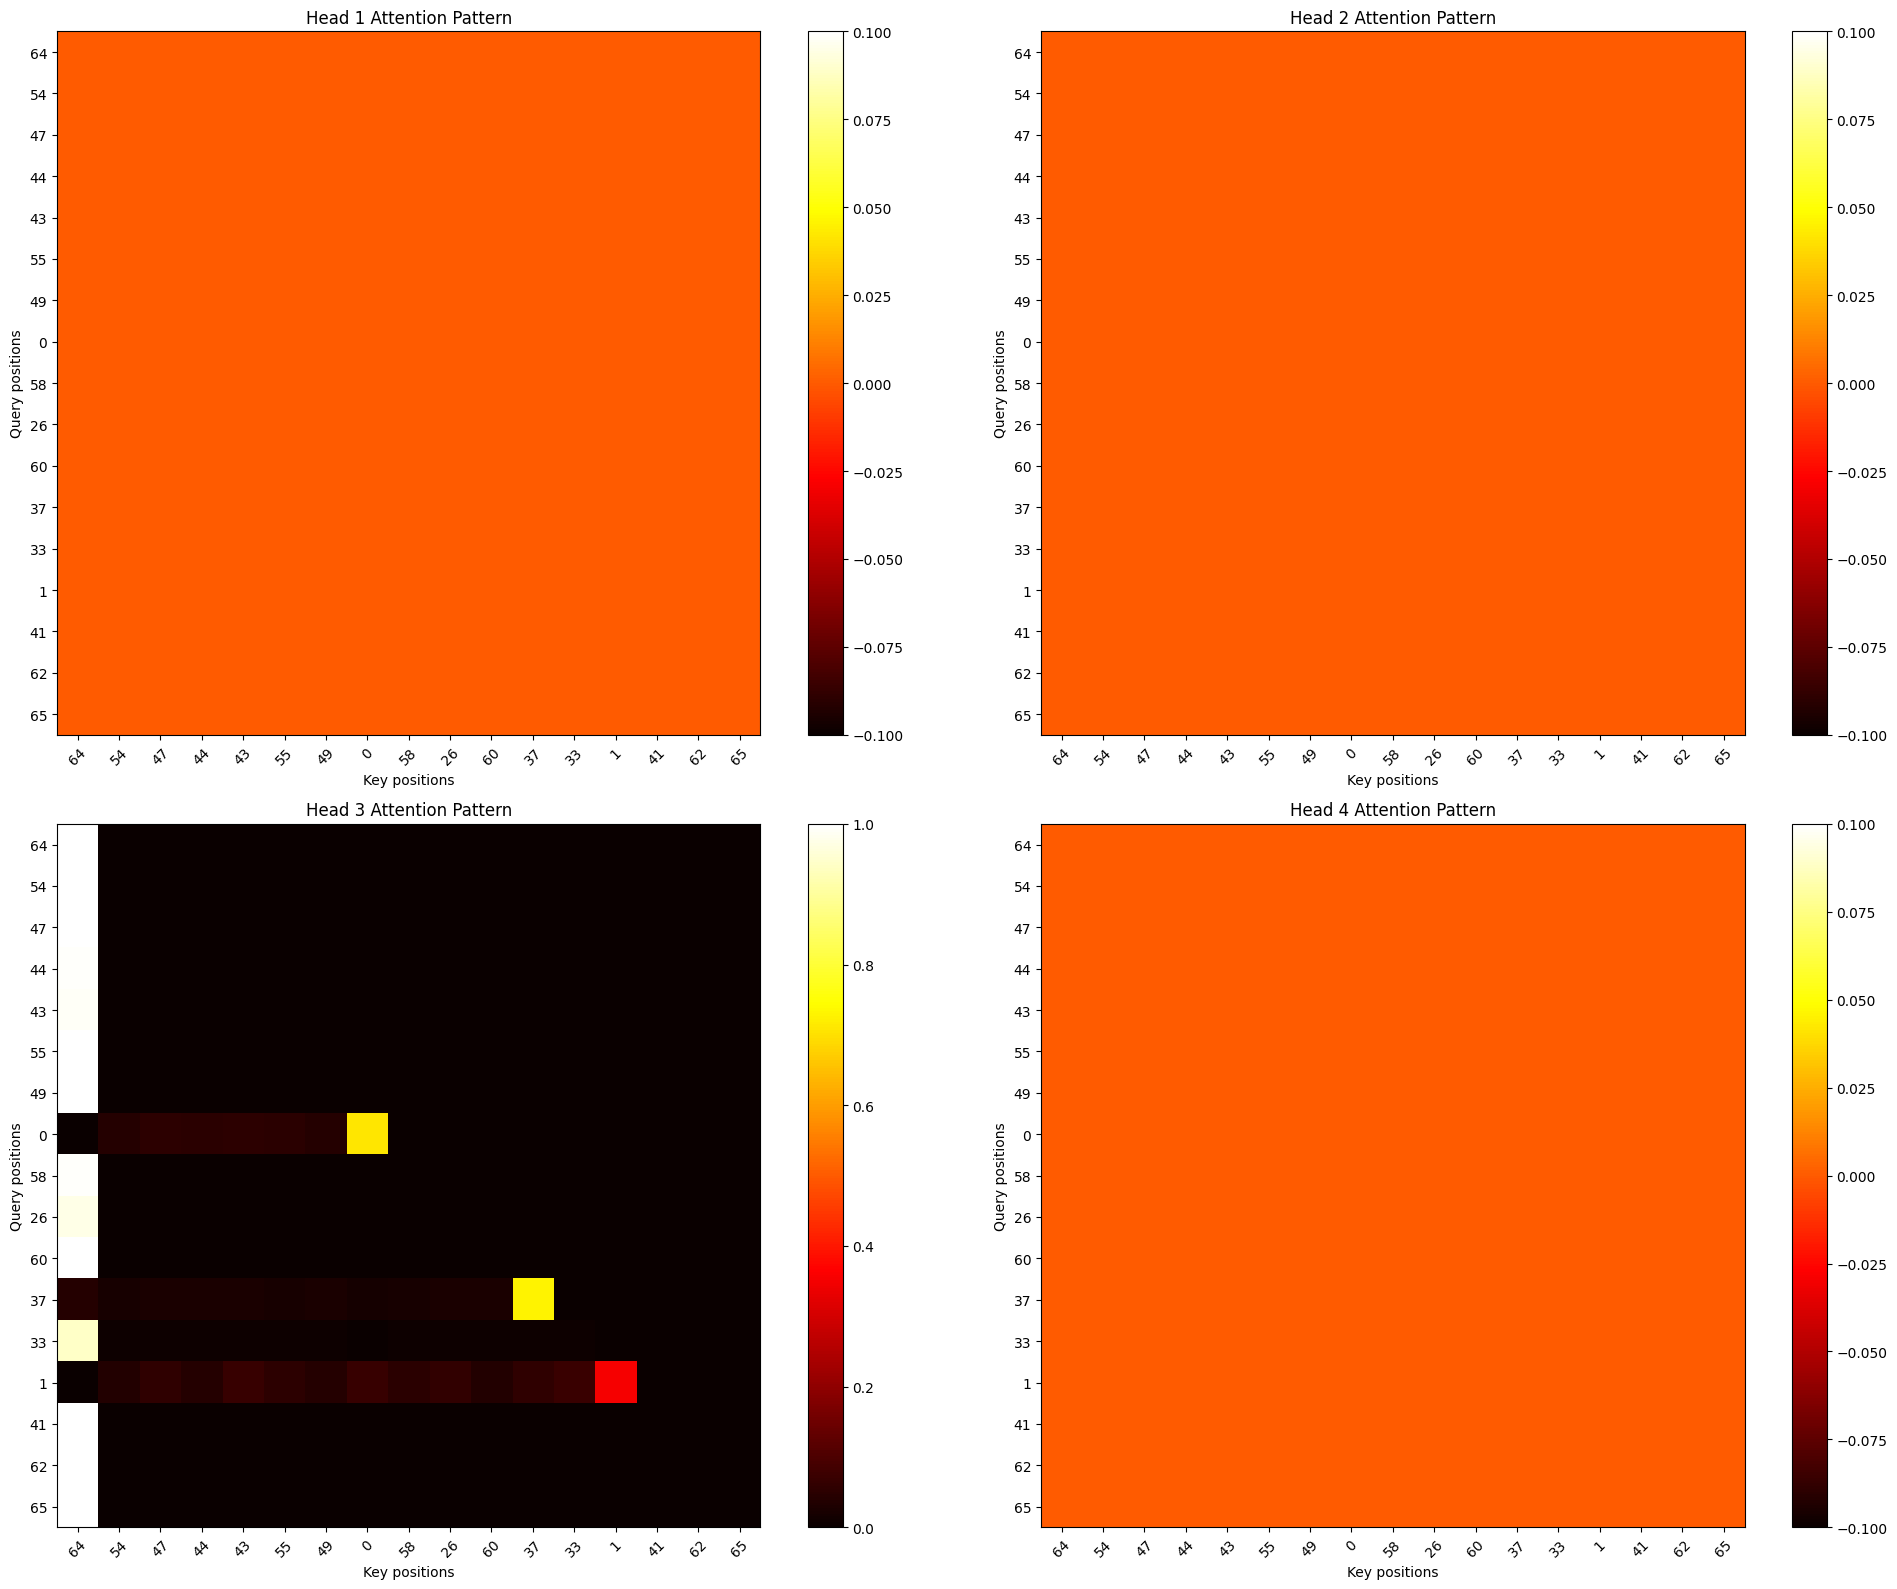


Sample sequence:
Input: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65  0  1 26 33 37 41 43
 44 47 49 54 55 58 60 62 66 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Predicted: [48 48 48 48 48 48 48  0 48 48 48 37 50  1 48 48 48 66 66 60 60 62 62 62
 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62
 62 62 62 

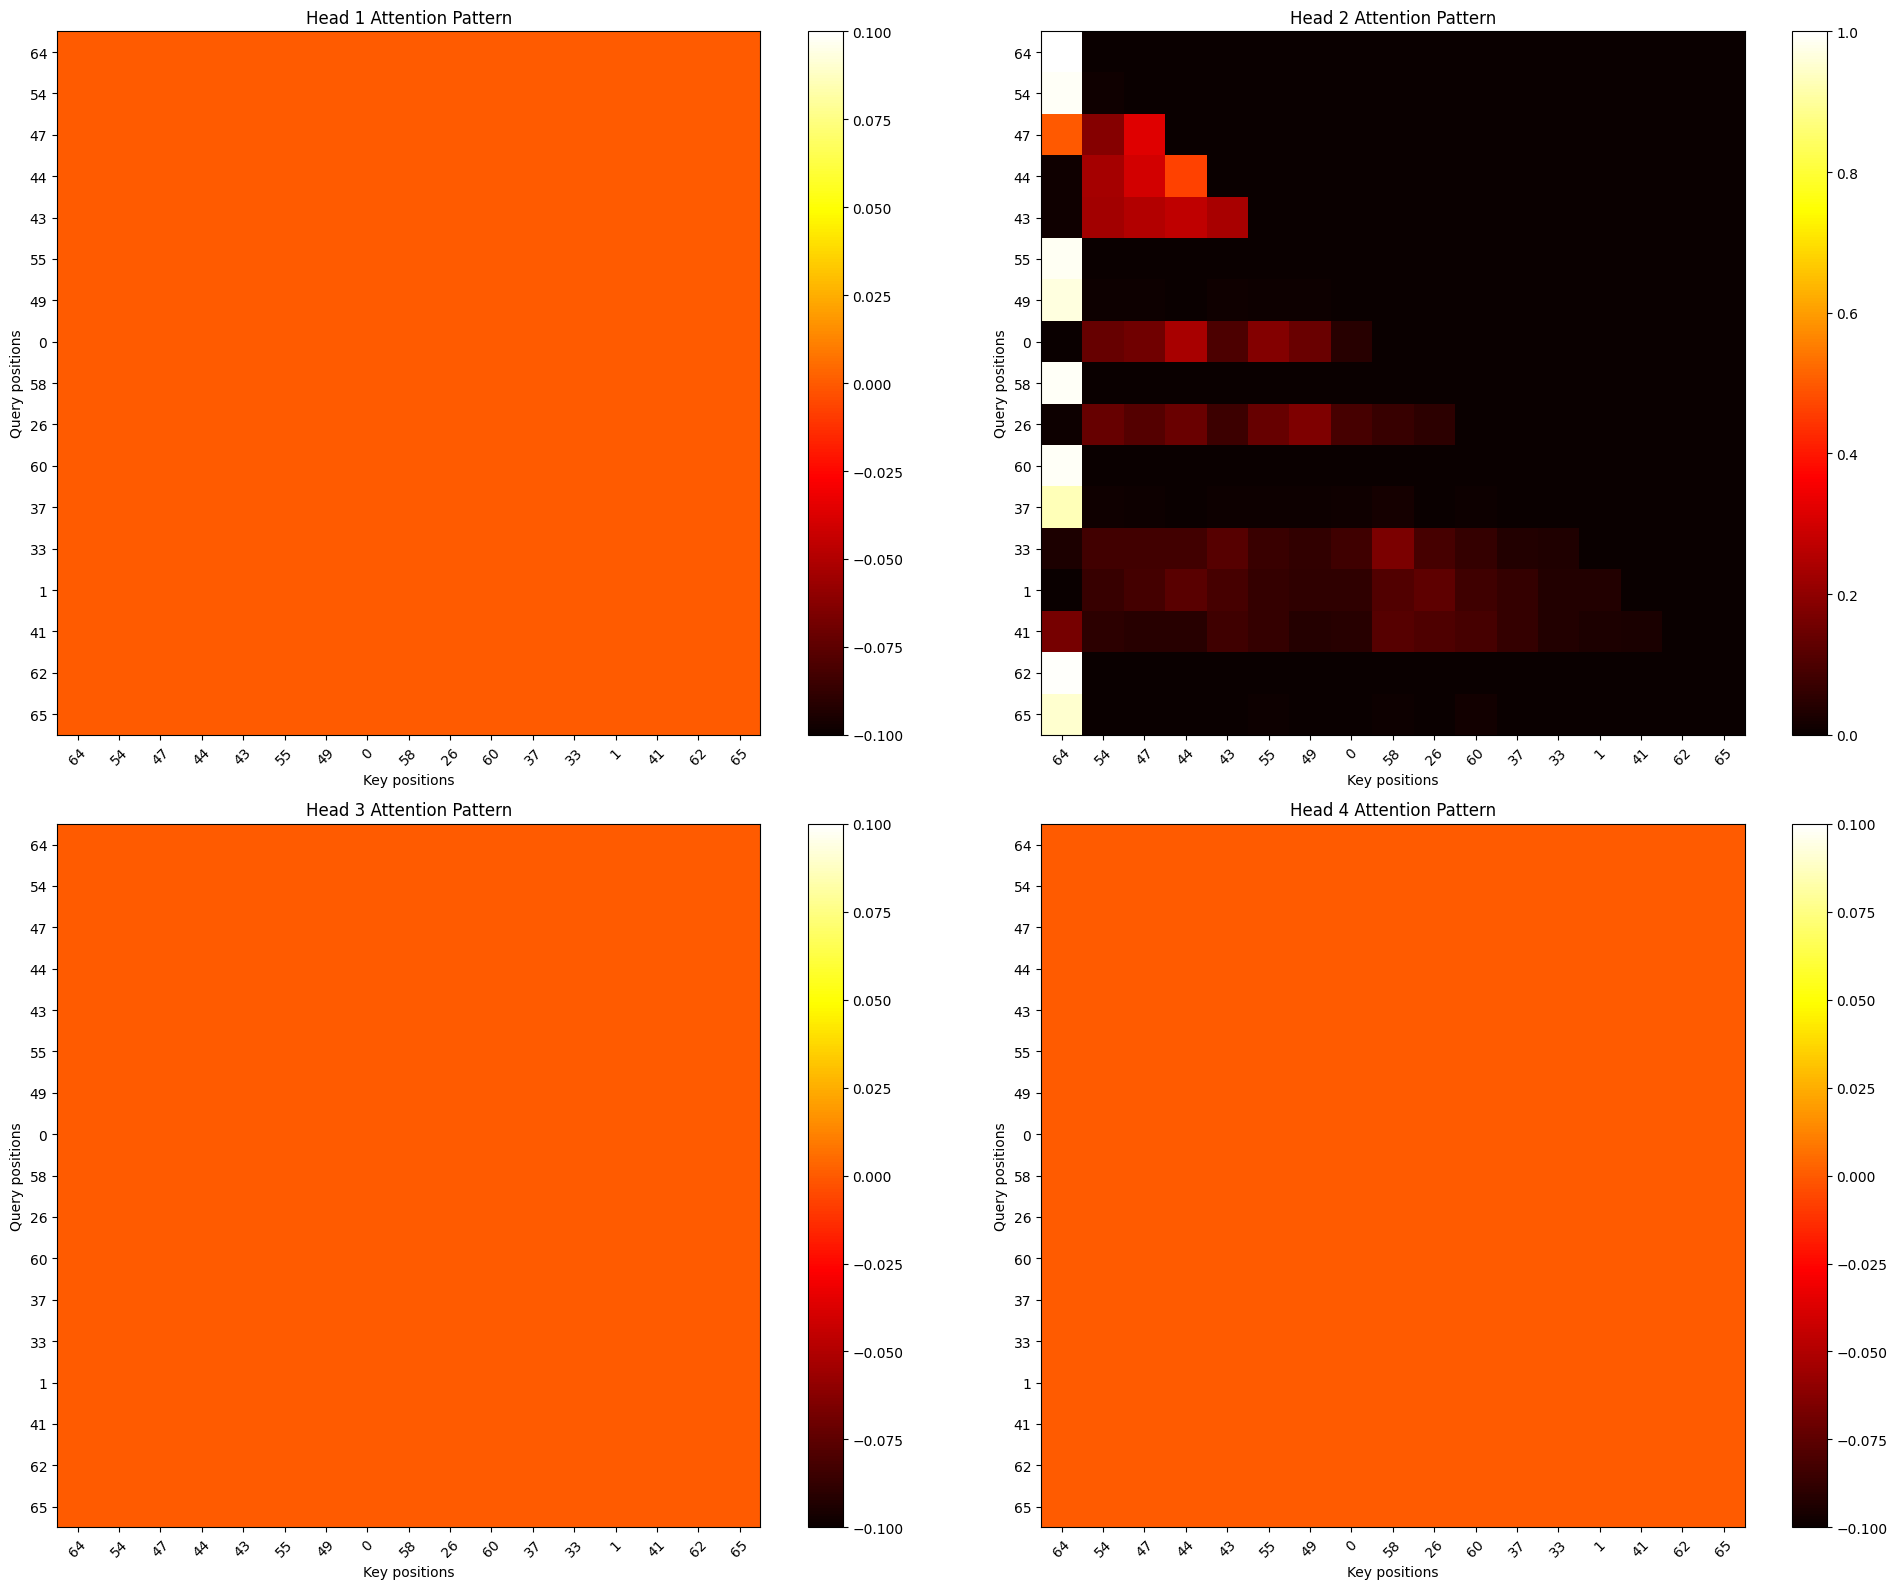


Sample sequence:
Input: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65  0  1 26 33 37 41 43
 44 47 49 54 55 58 60 62 66 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Predicted: [58 59 37 27 24 59 57 25 58 26 59 57 25 24 26 59 57 25 25 26 24 27 27 53
 54 55 55 57 58 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66
 66 66 66 

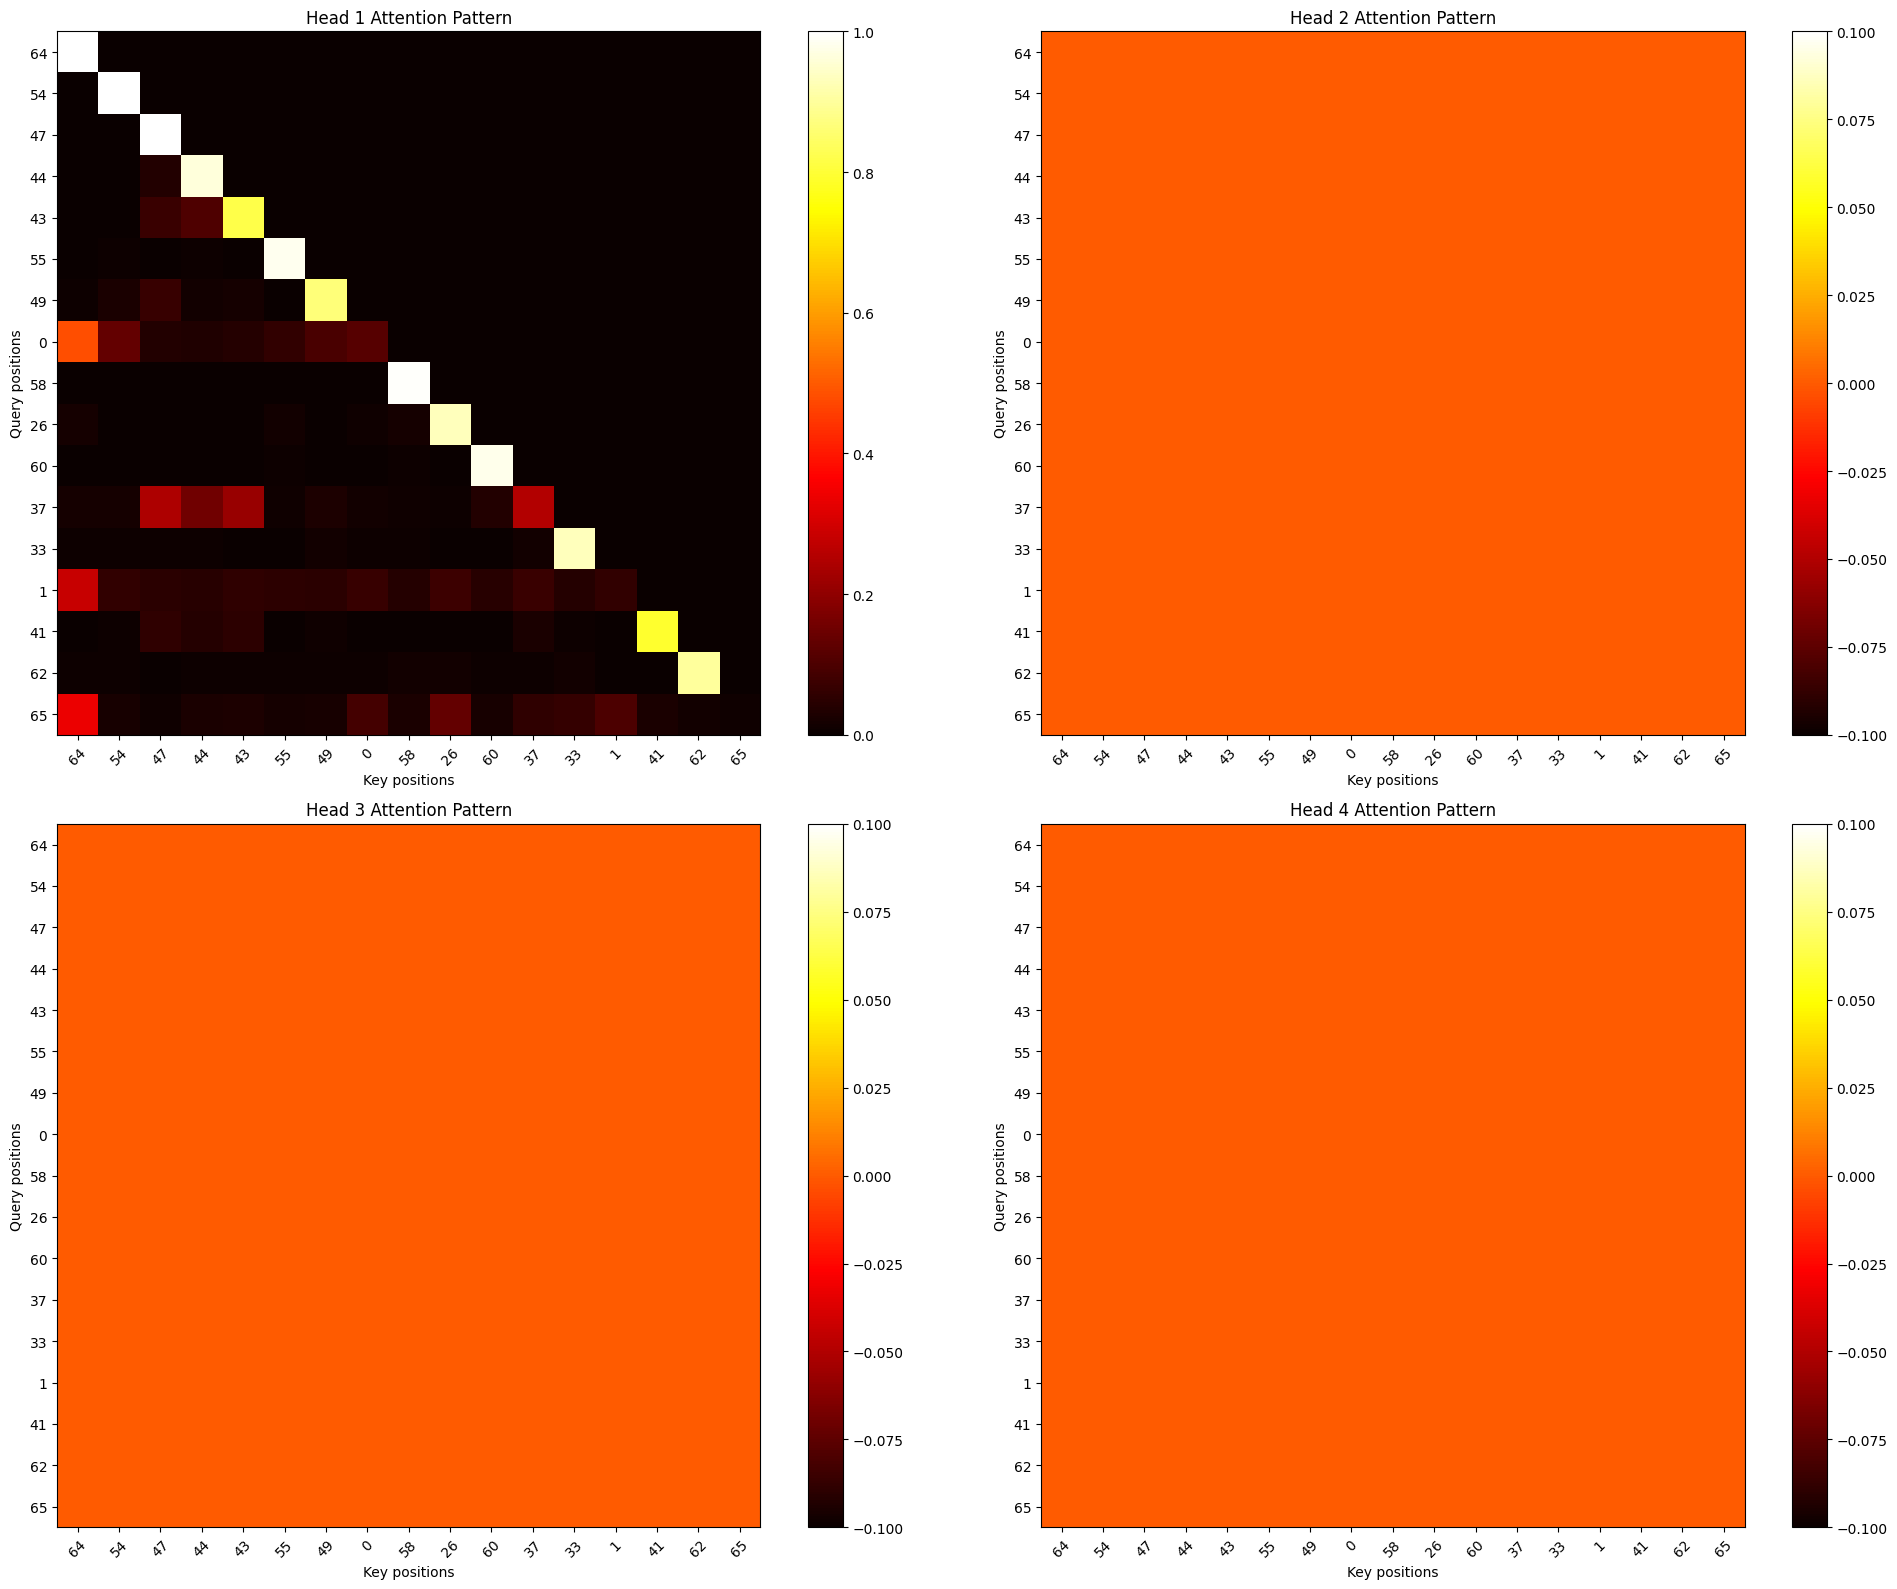


Sample sequence:
Input: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 54 47 44 43 55 49  0 58 26 60 37 33  1 41 62 65  0  1 26 33 37 41 43
 44 47 49 54 55 58 60 62 66 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Predicted: [ 5 54 47 16 15 55 49  7 58 17 60 16 17  9 17 62  9  5  1  0  0  0  0  0
  0 39 39 40 40 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 

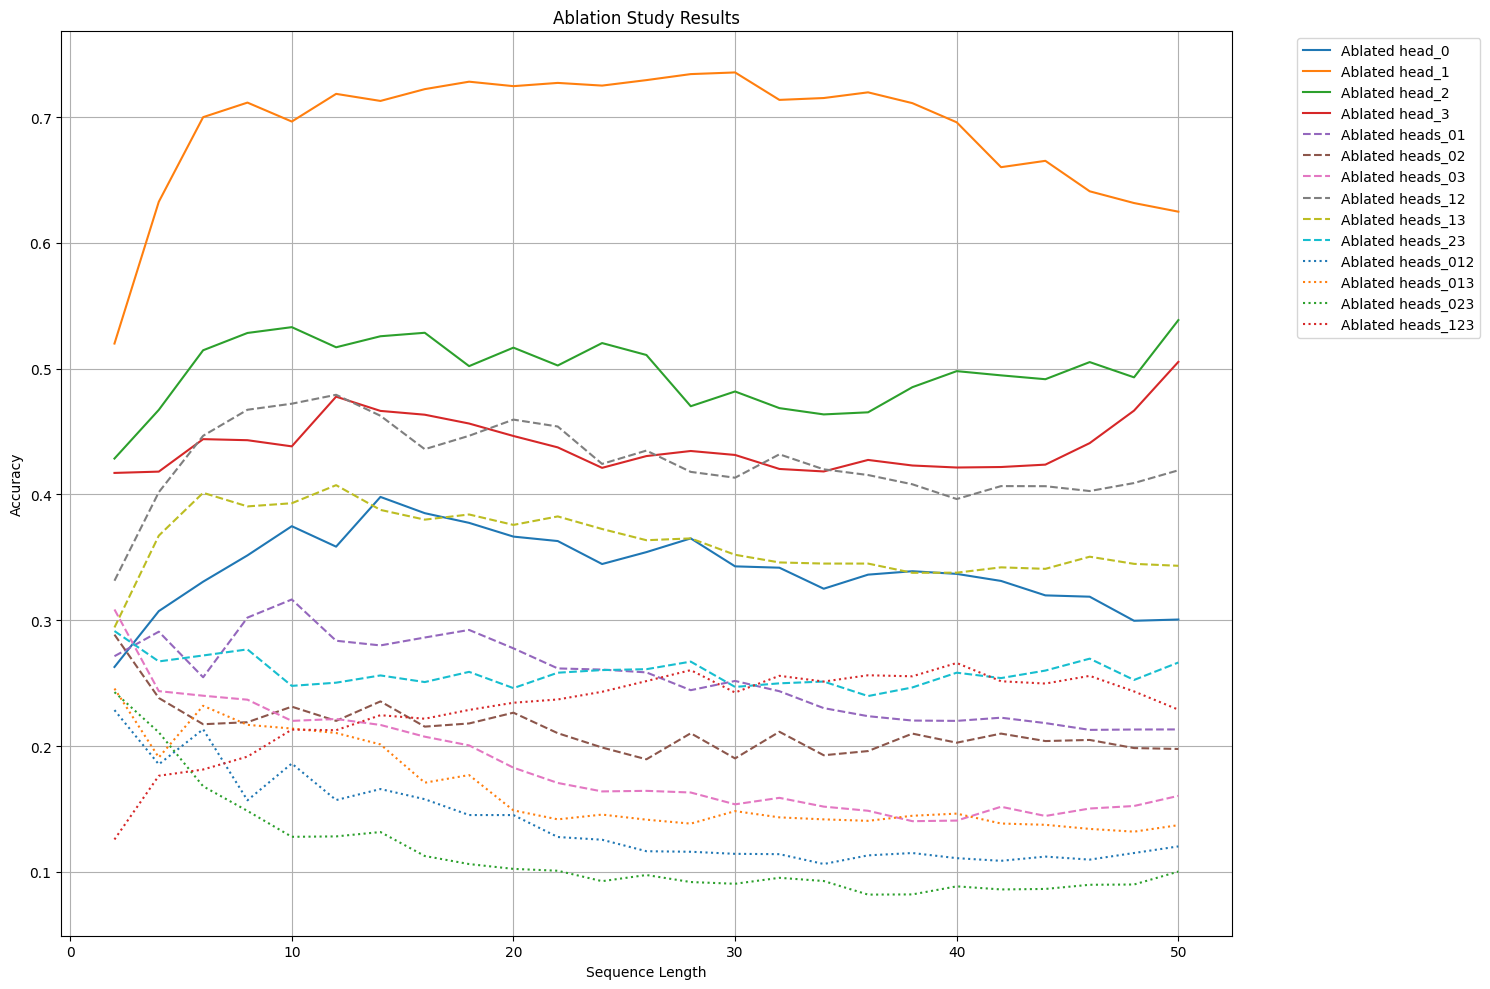

In [ ]:
#@title Ablation Studies
def ablate_heads(model, heads_to_ablate):
    """
    Temporarily sets attention weights to 0 for specified heads
    heads_to_ablate: list of head indices to ablate
    """
    def hook_fn(attn, hook):
        attn[:, heads_to_ablate] = 0
        return attn
    return hook_fn

def evaluate_ablation(model, heads_to_ablate, test_x, name=""):
    """
    Evaluates model performance with specified heads ablated
    """
    print(f"\nTesting ablation of heads: {heads_to_ablate}")

    with model.hooks(fwd_hooks=[('blocks.0.attn.hook_pattern', ablate_heads(model, heads_to_ablate))]):
        # Plot attention patterns
        plot_attention_patterns(test_x, model)

        # Show prediction
        logits = model(test_x)
        pred = logits.argmax(dim=-1)
        print("\nSample sequence:")
        print("Input:", test_x[0].cpu().numpy())
        print("Target:", test_y[0].cpu().numpy())
        print("Predicted:", pred[0].cpu().numpy())

    # Evaluate on different lengths
    lengths_to_test = list(range(2, 51, 2))  # Testing every other length for efficiency
    accuracies = []
    for length in lengths_to_test:
        total_accuracy = 0
        for _ in range(50):  # Fewer samples for speed
            x, y, lengths = generate_data(batch_size=1, fixed_length=length)
            with torch.no_grad():
                with model.hooks(fwd_hooks=[('blocks.0.attn.hook_pattern', ablate_heads(model, heads_to_ablate))]):
                    logits = model(x)
                    correct = (logits[0, :lengths[0]].argmax(dim=-1) == y[0, :lengths[0]]).sum().item()
                    total_accuracy += correct / lengths[0].item()
        avg_accuracy = total_accuracy / 50
        accuracies.append(avg_accuracy)
        print(f"Length {length}: Accuracy = {avg_accuracy:.4f}")

    return lengths_to_test, accuracies

# Generate test data
test_x, test_y, lengths = generate_data(1, fixed_length=15)

# Baseline (unablated) performance
print("\nUnablated sample sequence:")
logits = model(test_x)
pred = logits.argmax(dim=-1)
print("Input:", test_x[0].cpu().numpy())
print("Target:", test_y[0].cpu().numpy())
print("Predicted:", pred[0].cpu().numpy())
plot_attention_patterns(test_x, model)

# Single head ablations
single_head_results = {}
for head in range(4):
    lengths, accs = evaluate_ablation(model, [head], test_x)
    single_head_results[f"head_{head}"] = accs

# Two head ablations
pairs = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]
pair_results = {}
for h1, h2 in pairs:
    lengths, accs = evaluate_ablation(model, [h1, h2], test_x)
    pair_results[f"heads_{h1}{h2}"] = accs

# Three head ablations
triples = [(0,1,2), (0,1,3), (0,2,3), (1,2,3)]
triple_results = {}
for h1, h2, h3 in triples:
    lengths, accs = evaluate_ablation(model, [h1, h2, h3], test_x)
    triple_results[f"heads_{h1}{h2}{h3}"] = accs

# Plot comparative results
plt.figure(figsize=(15, 10))

# Plot single head ablations
for head, accuracies in single_head_results.items():
    plt.plot(lengths, accuracies, label=f'Ablated {head}')

# Plot pair ablations
for pair, accuracies in pair_results.items():
    plt.plot(lengths, accuracies, label=f'Ablated {pair}', linestyle='--')

# Plot triple ablations
for triple, accuracies in triple_results.items():
    plt.plot(lengths, accuracies, label=f'Ablated {triple}', linestyle=':')

plt.xlabel('Sequence Length')
plt.ylabel('Accuracy')
plt.title('Ablation Study Results')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Testing modification: no_start

Test 1:
Original: [64 54  3 36 42 47 52 33 37 43 18 65 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Modified: [54  3 36 42 47 52 33 37 43 18 65  3 18 33 36 37 42 43 47 52 54 66 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 54  3 36 42 47 52 33 37 43 18 65  3 18 33 36 37 42 43 47 52 54 66 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 

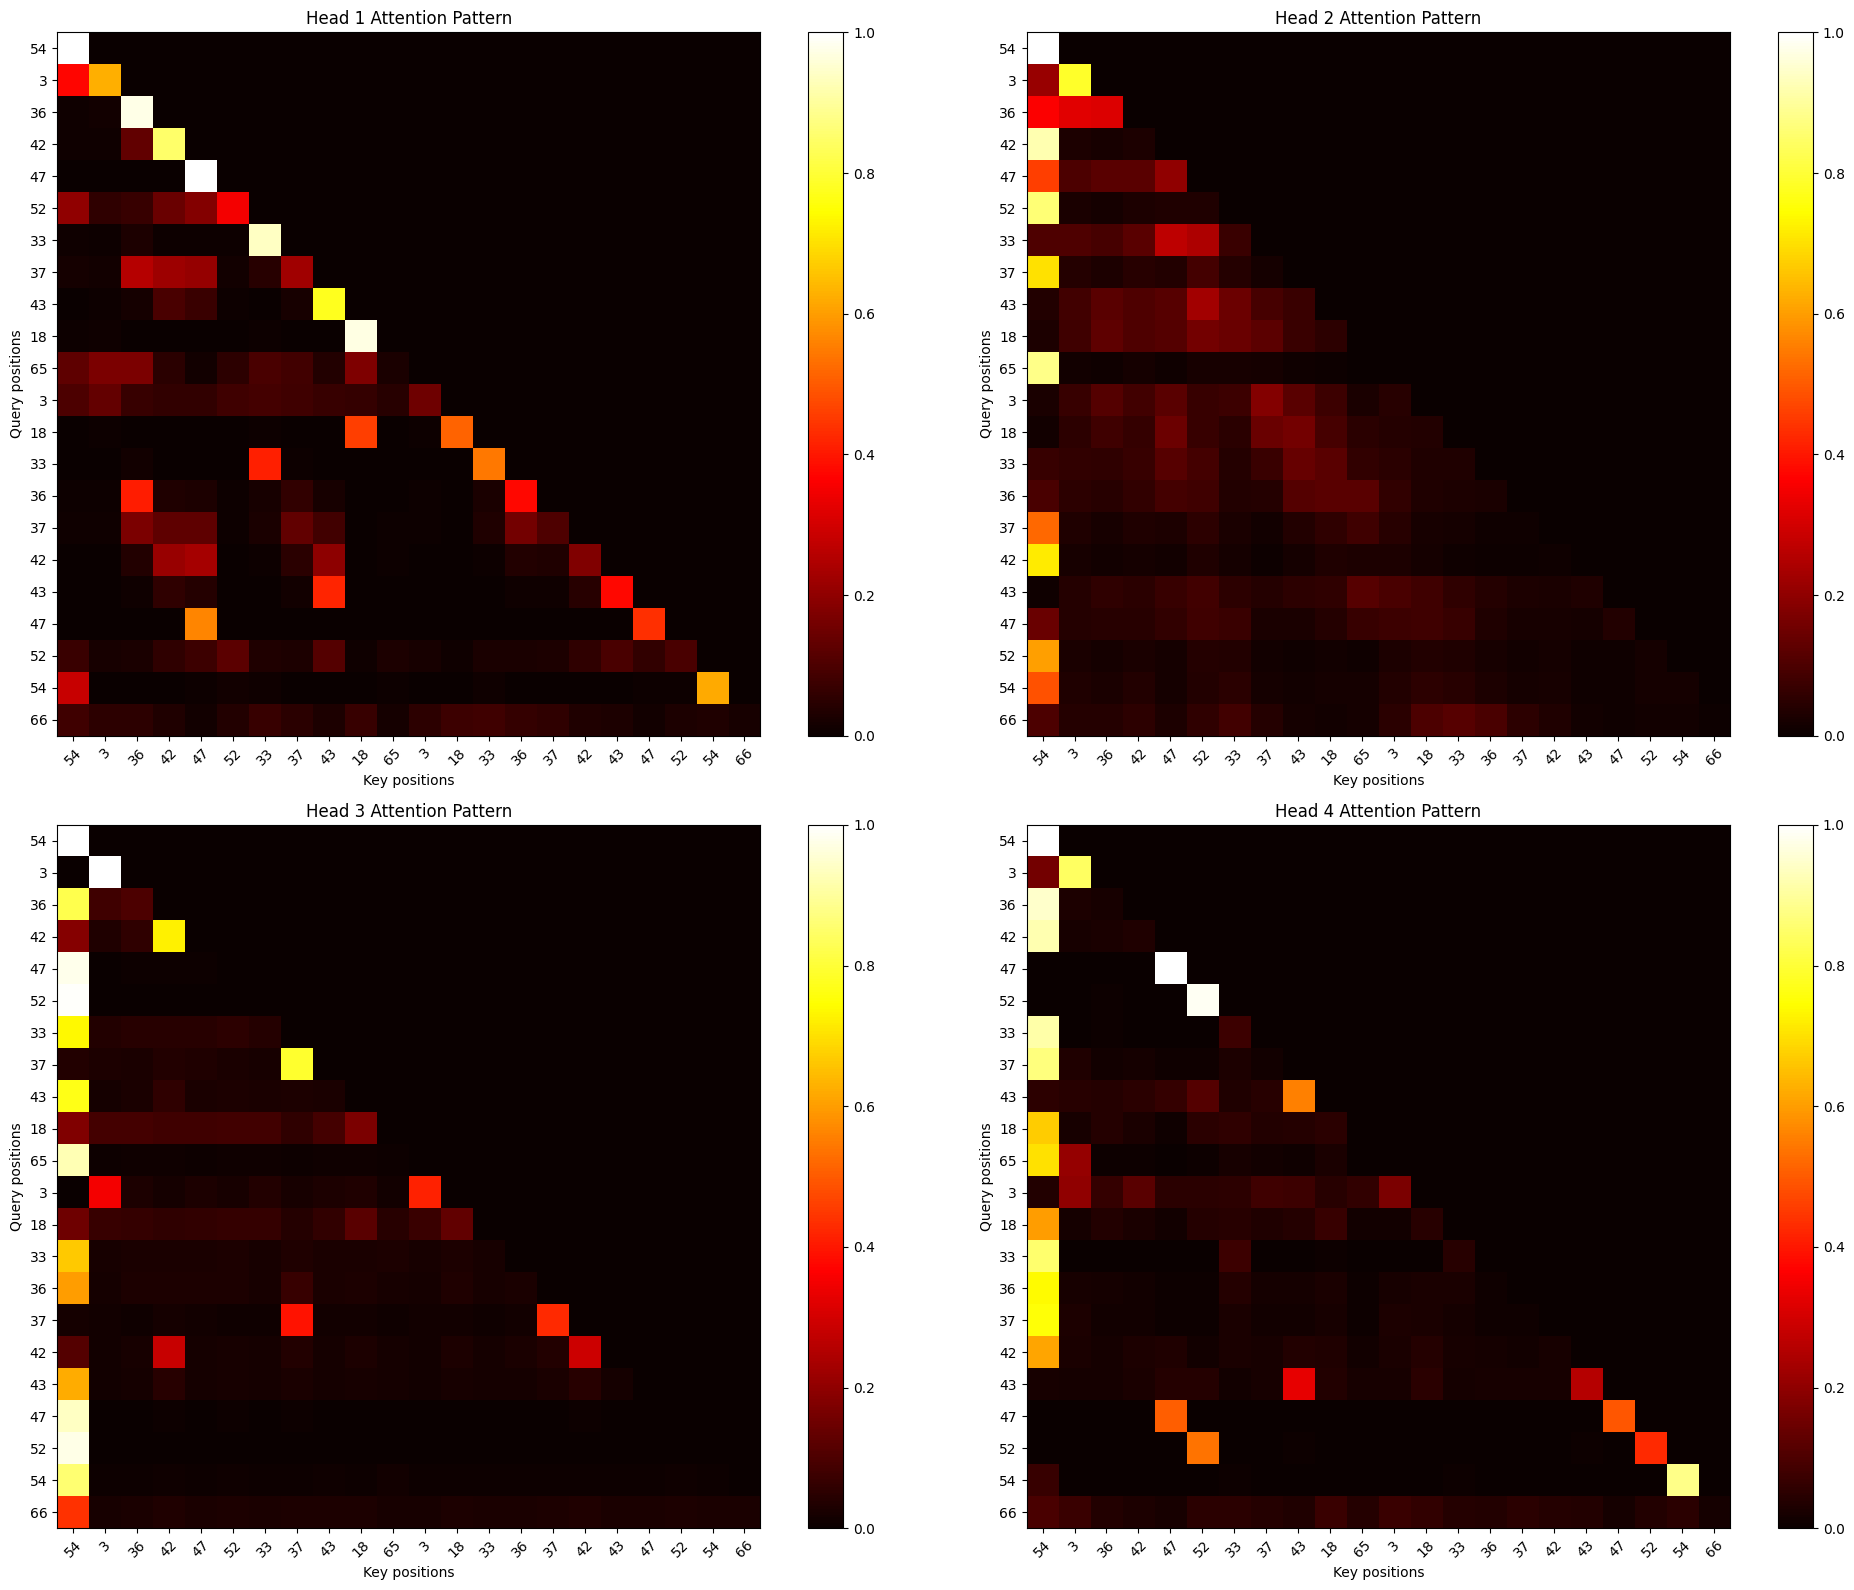


Test 2:
Original: [64 53 20 34 15 22 41 60 46 29 26 65 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Modified: [53 20 34 15 22 41 60 46 29 26 65 15 20 22 26 29 34 41 46 53 60 66 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 53 20 34 15 22 41 60 46 29 26 65 15 20 22 26 29 34 41 46 53 60 66 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 6

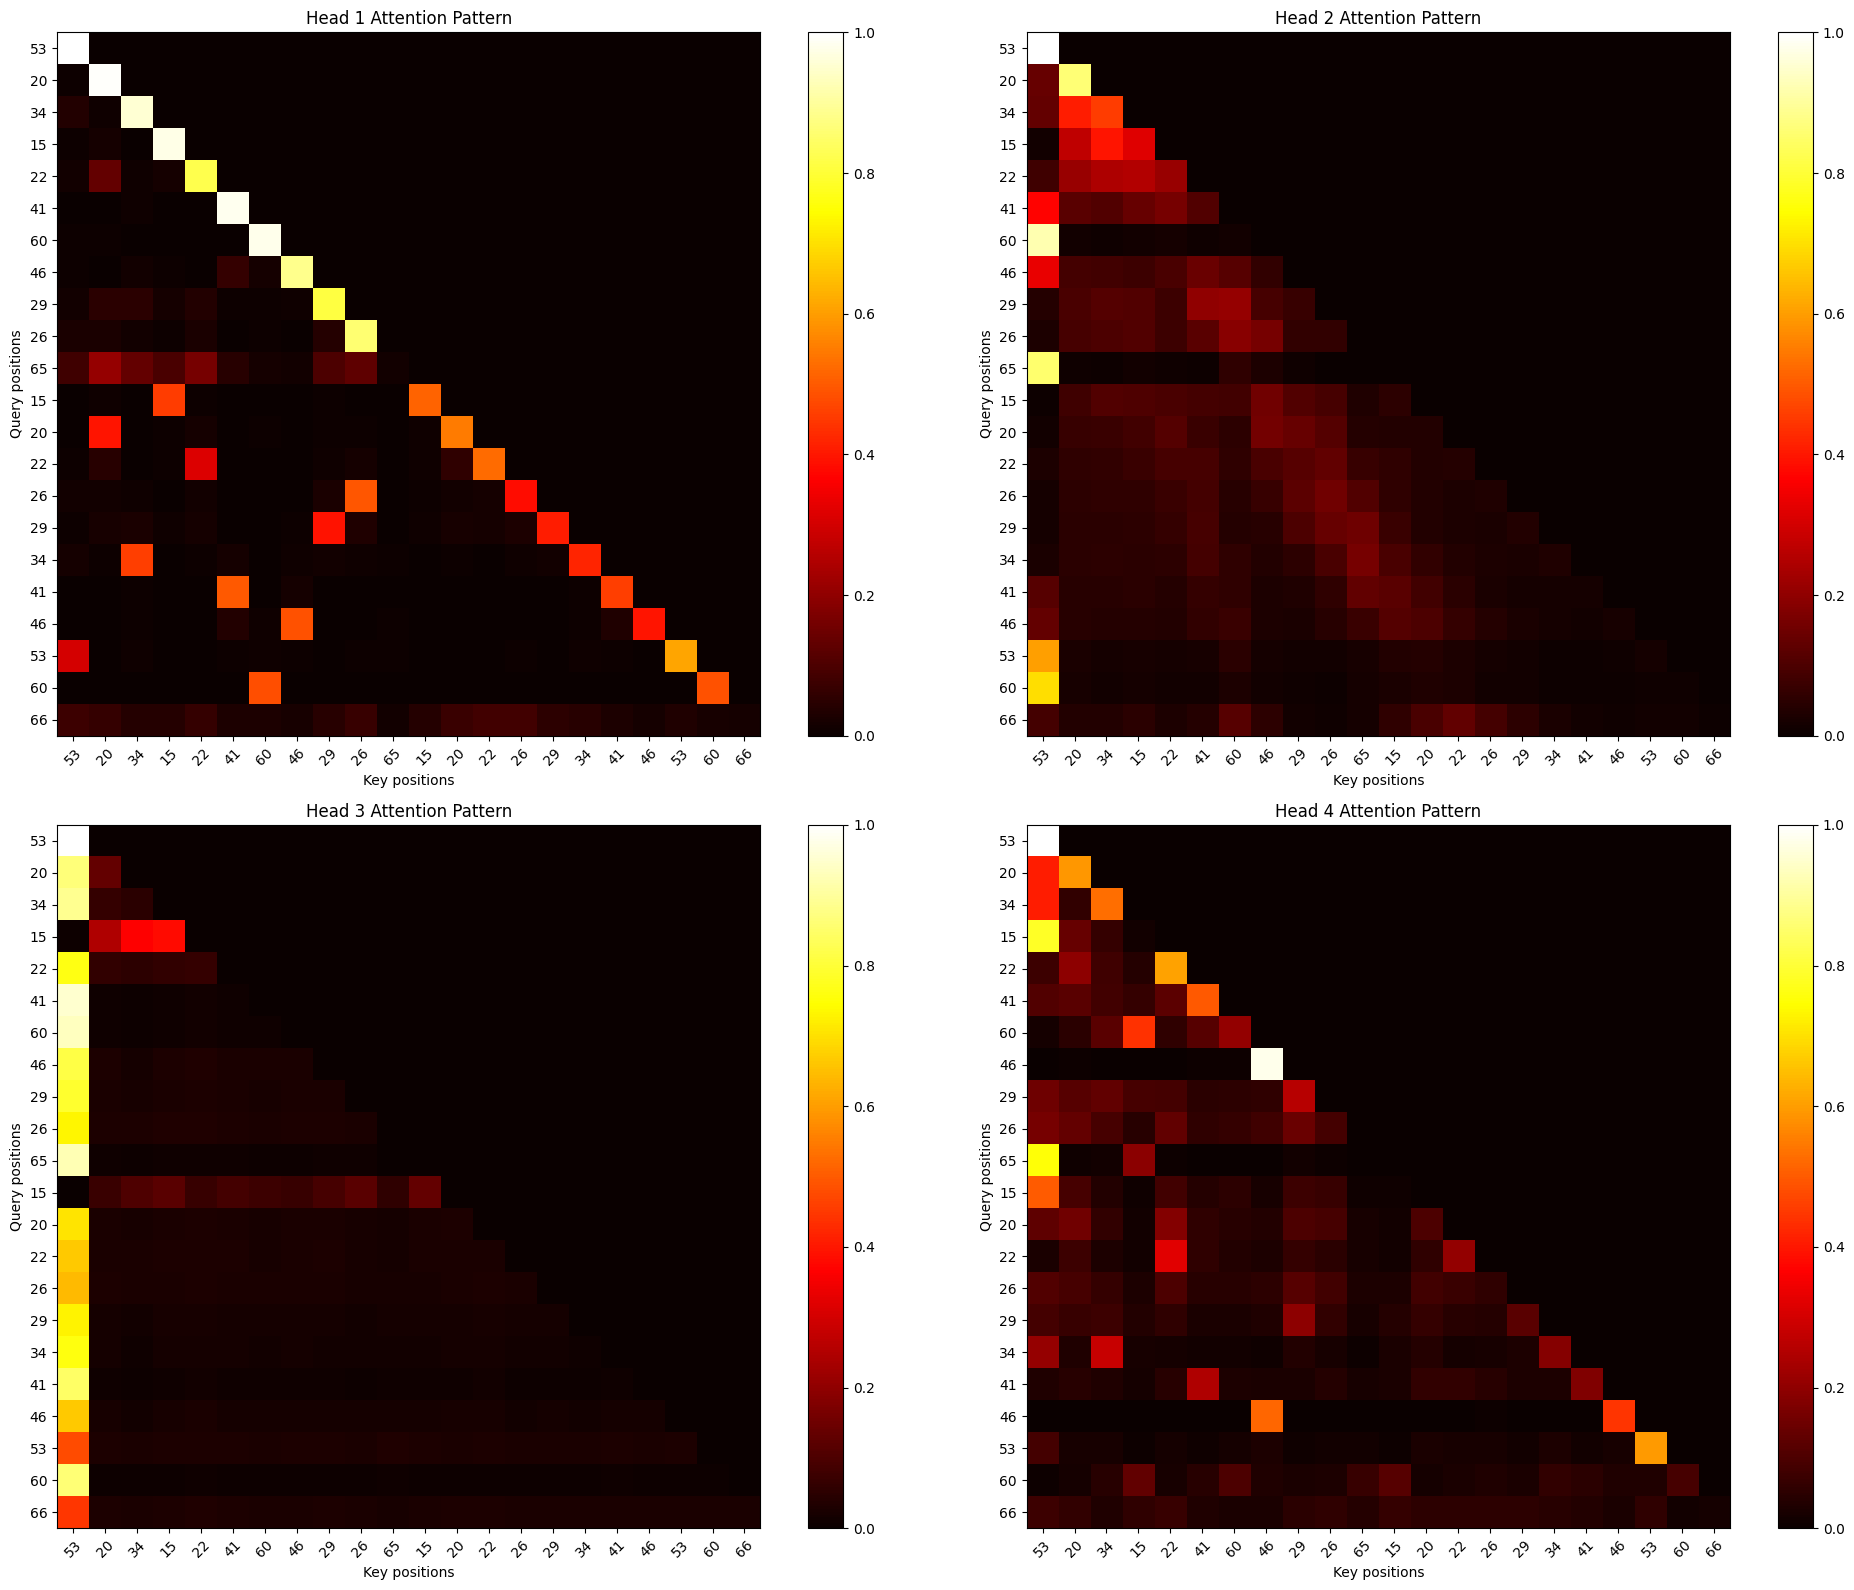


Test 3:
Original: [64 18  5 35 54 60 29 32 15  9  4 65 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Modified: [18  5 35 54 60 29 32 15  9  4 65  4  5  9 15 18 29 32 35 54 60 66 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 18  5 35 54 60 29 32 15  9  4 65  4  5  9 15 18 29 32 35 54 60 66 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 6

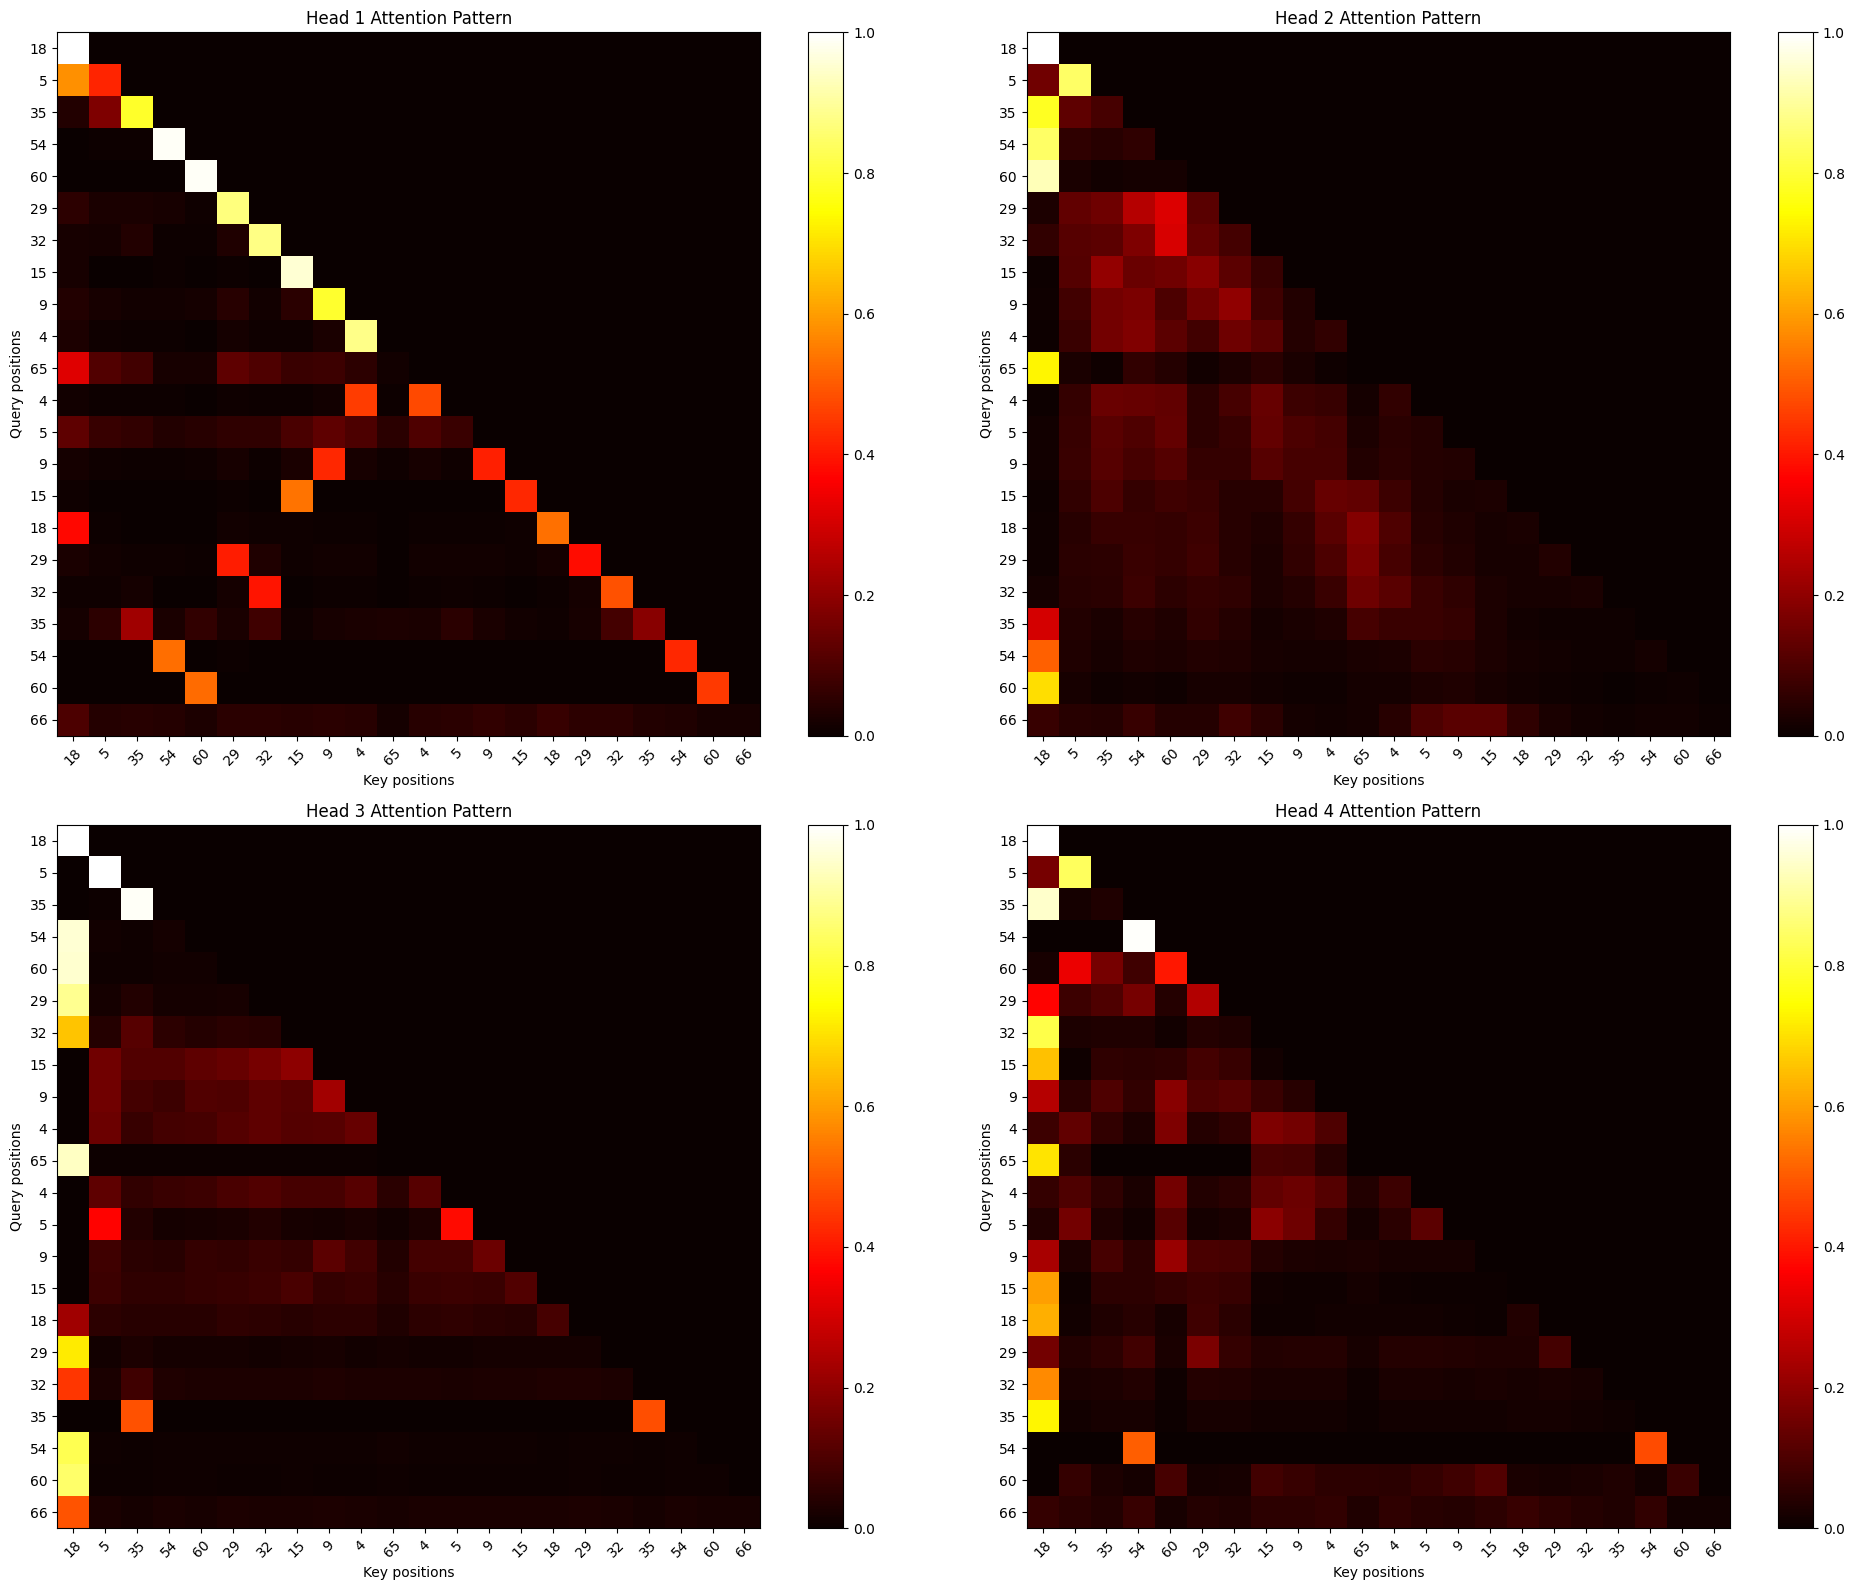


Test 4:
Original: [64  9 58 54  3 63  8 39  0  2 35 65 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Modified: [ 9 58 54  3 63  8 39  0  2 35 65  0  2  3  8  9 35 39 54 58 63 66 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64  9 58 54  3 63  8 39  0  2 35 65  0  2  3  8  9 35 39 54 58 63 66 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 6

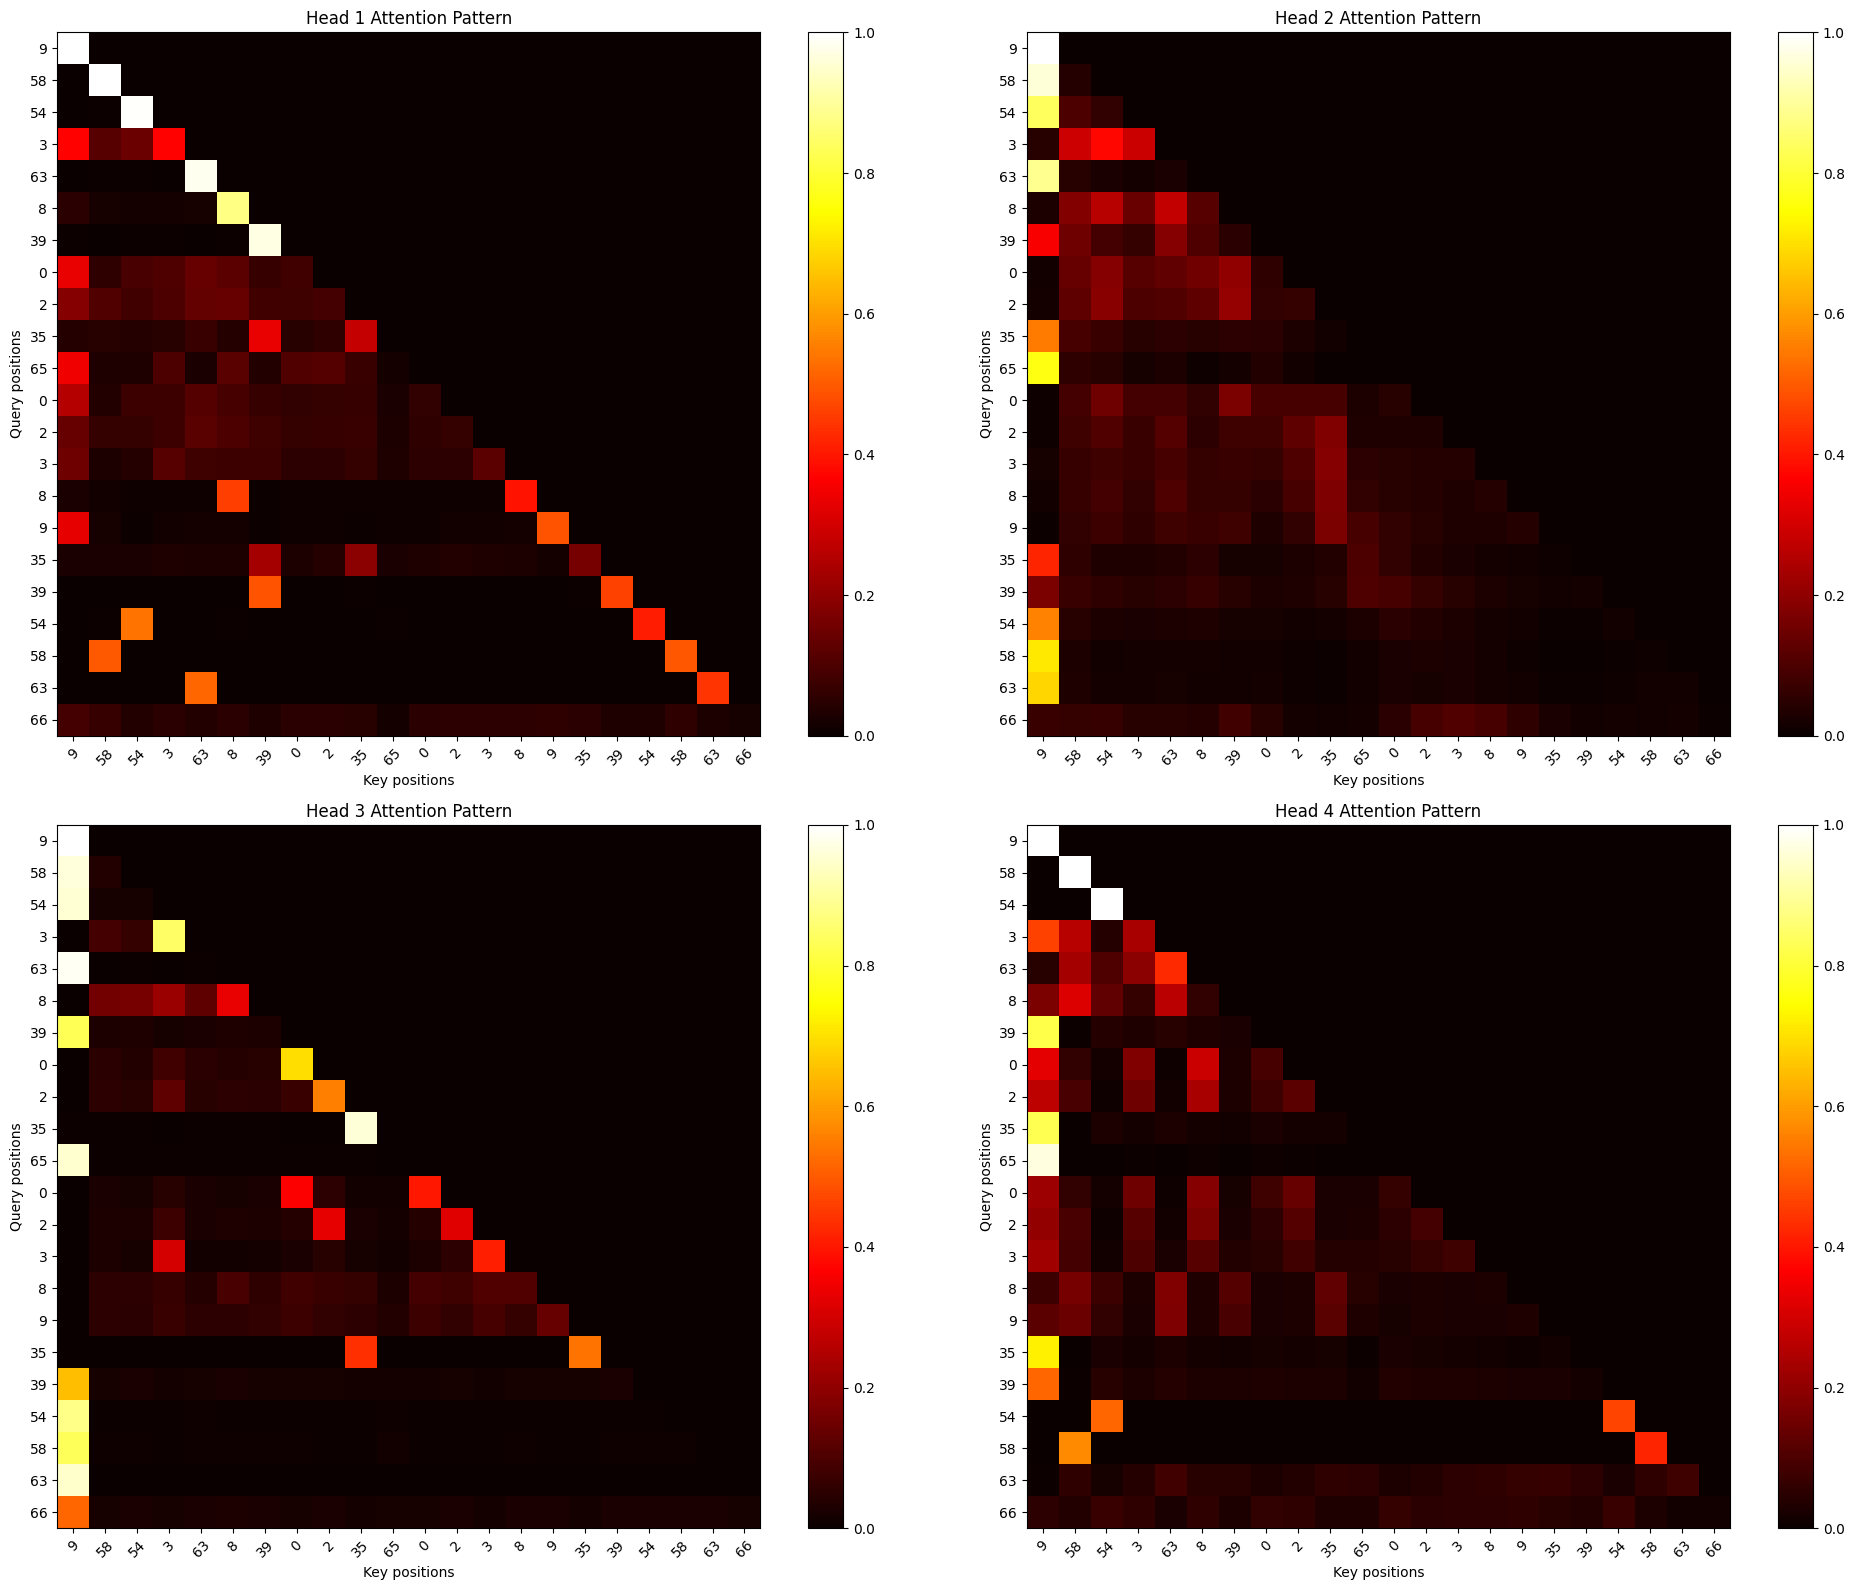


Test 5:
Original: [64 29 47 11 60 58 38  1 45 19 48 65 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Modified: [29 47 11 60 58 38  1 45 19 48 65  1 11 19 29 38 45 47 48 58 60 66 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 29 47 11 60 58 38  1 45 19 48 65  1 11 19 29 38 45 47 48 58 60 66 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 6

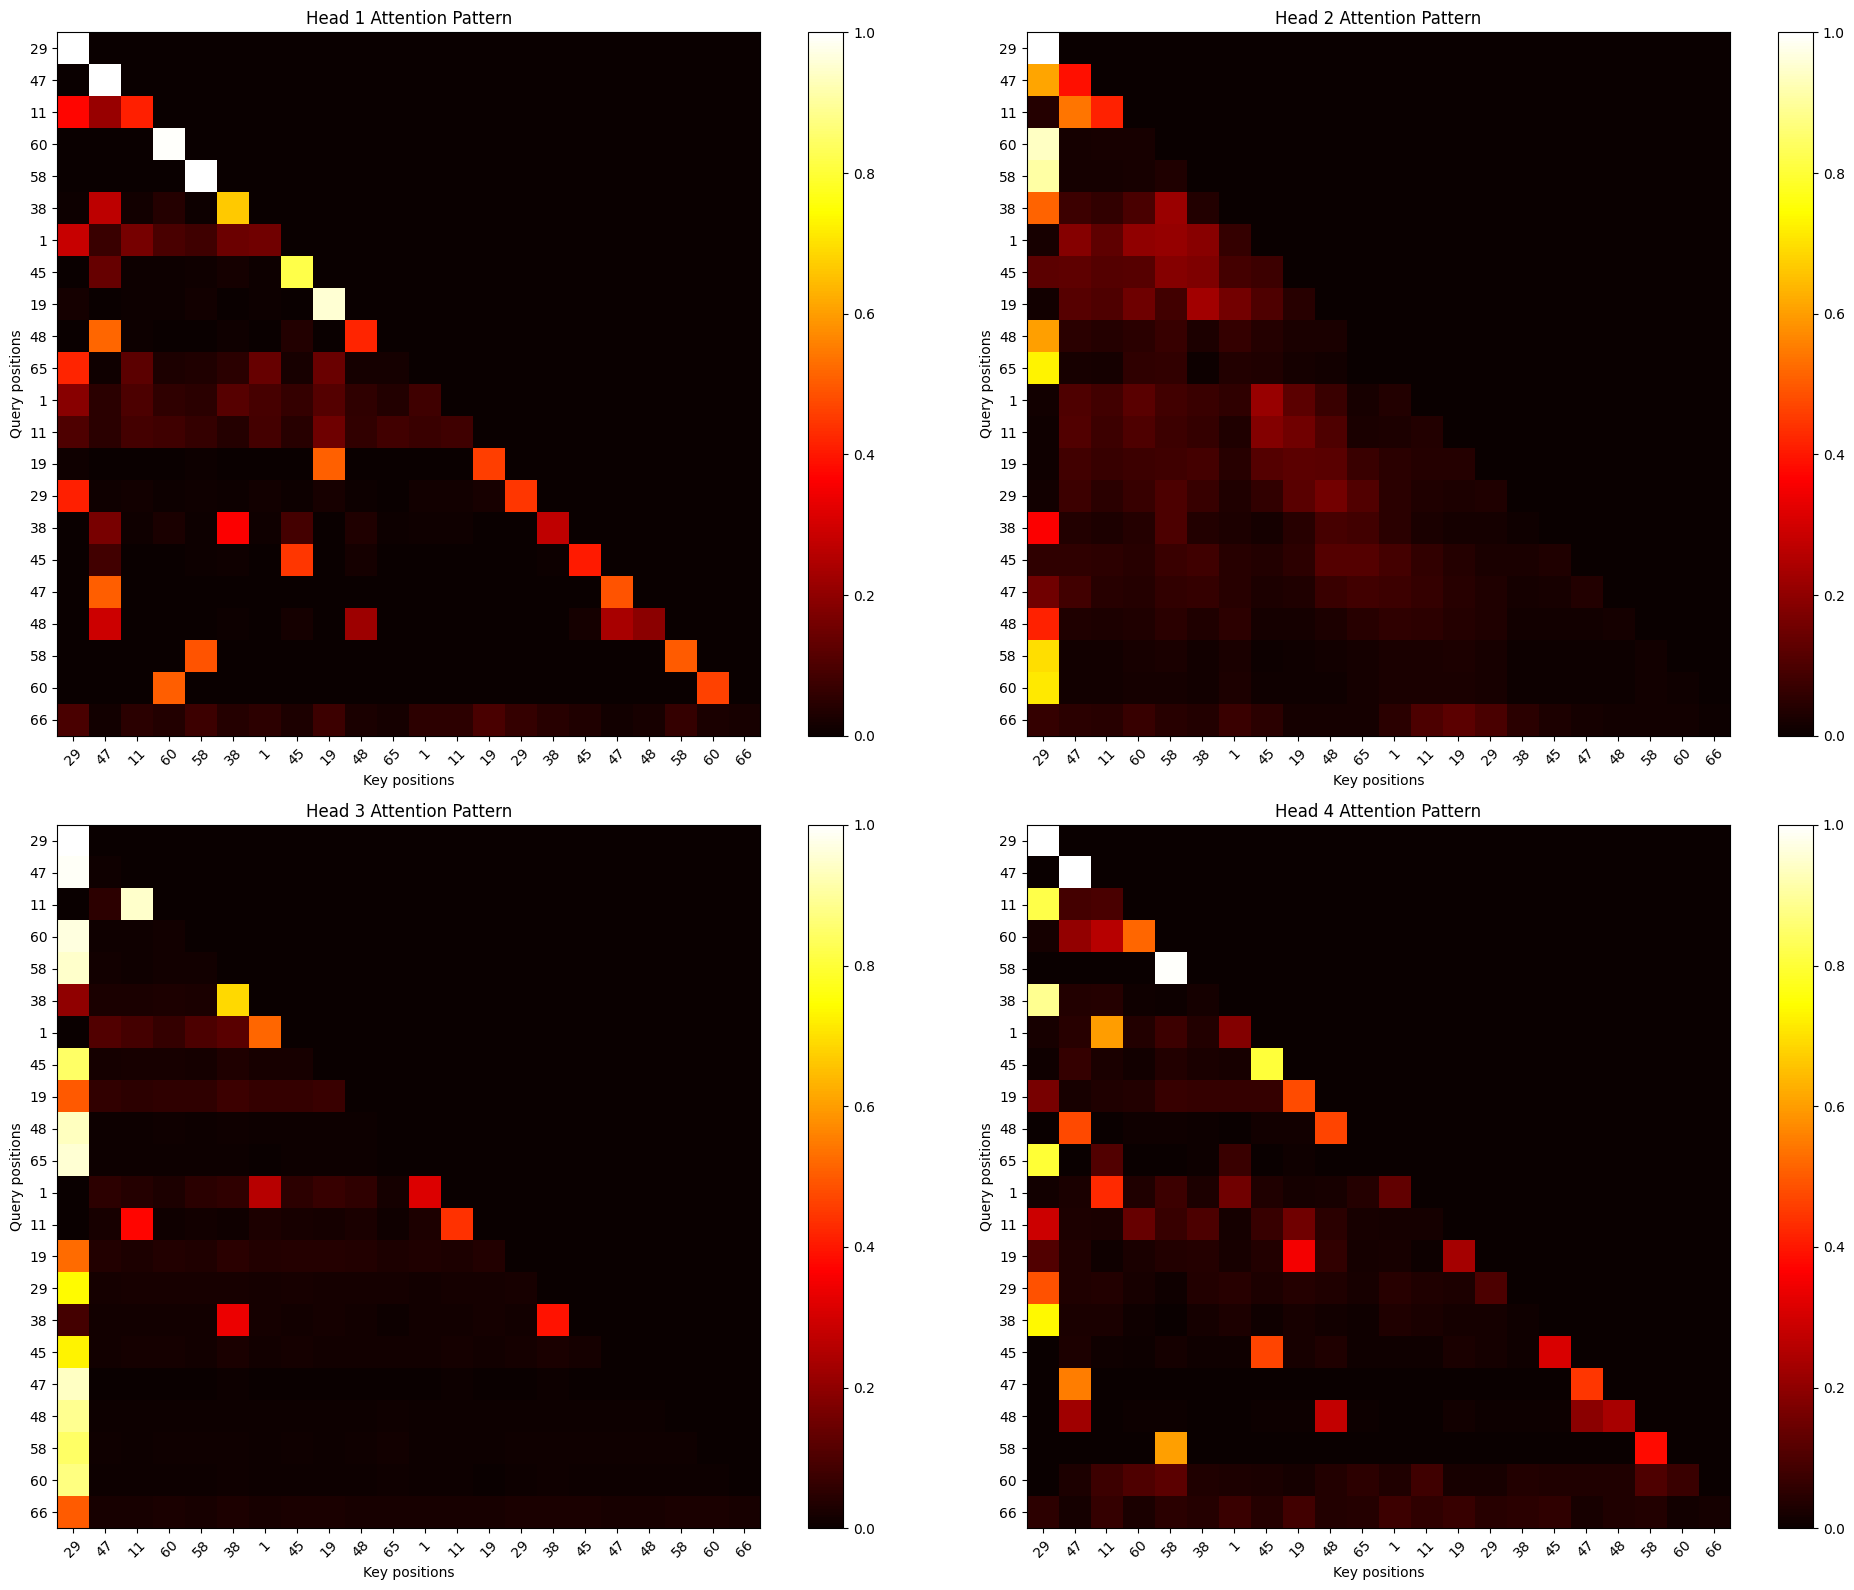


Testing modification: no_sort

Test 1:
Original: [64 23 22 16 38 36 61 47 48  7 20 65 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Modified: [64 23 22 16 38 36 61 47 48  7 20  7 16 20 22 23 36 38 47 48 61 66 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 23 22 16 38 36 61 47 48  7 20 65  7 16 20 22 23 36 38 47 48 61 66 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 6

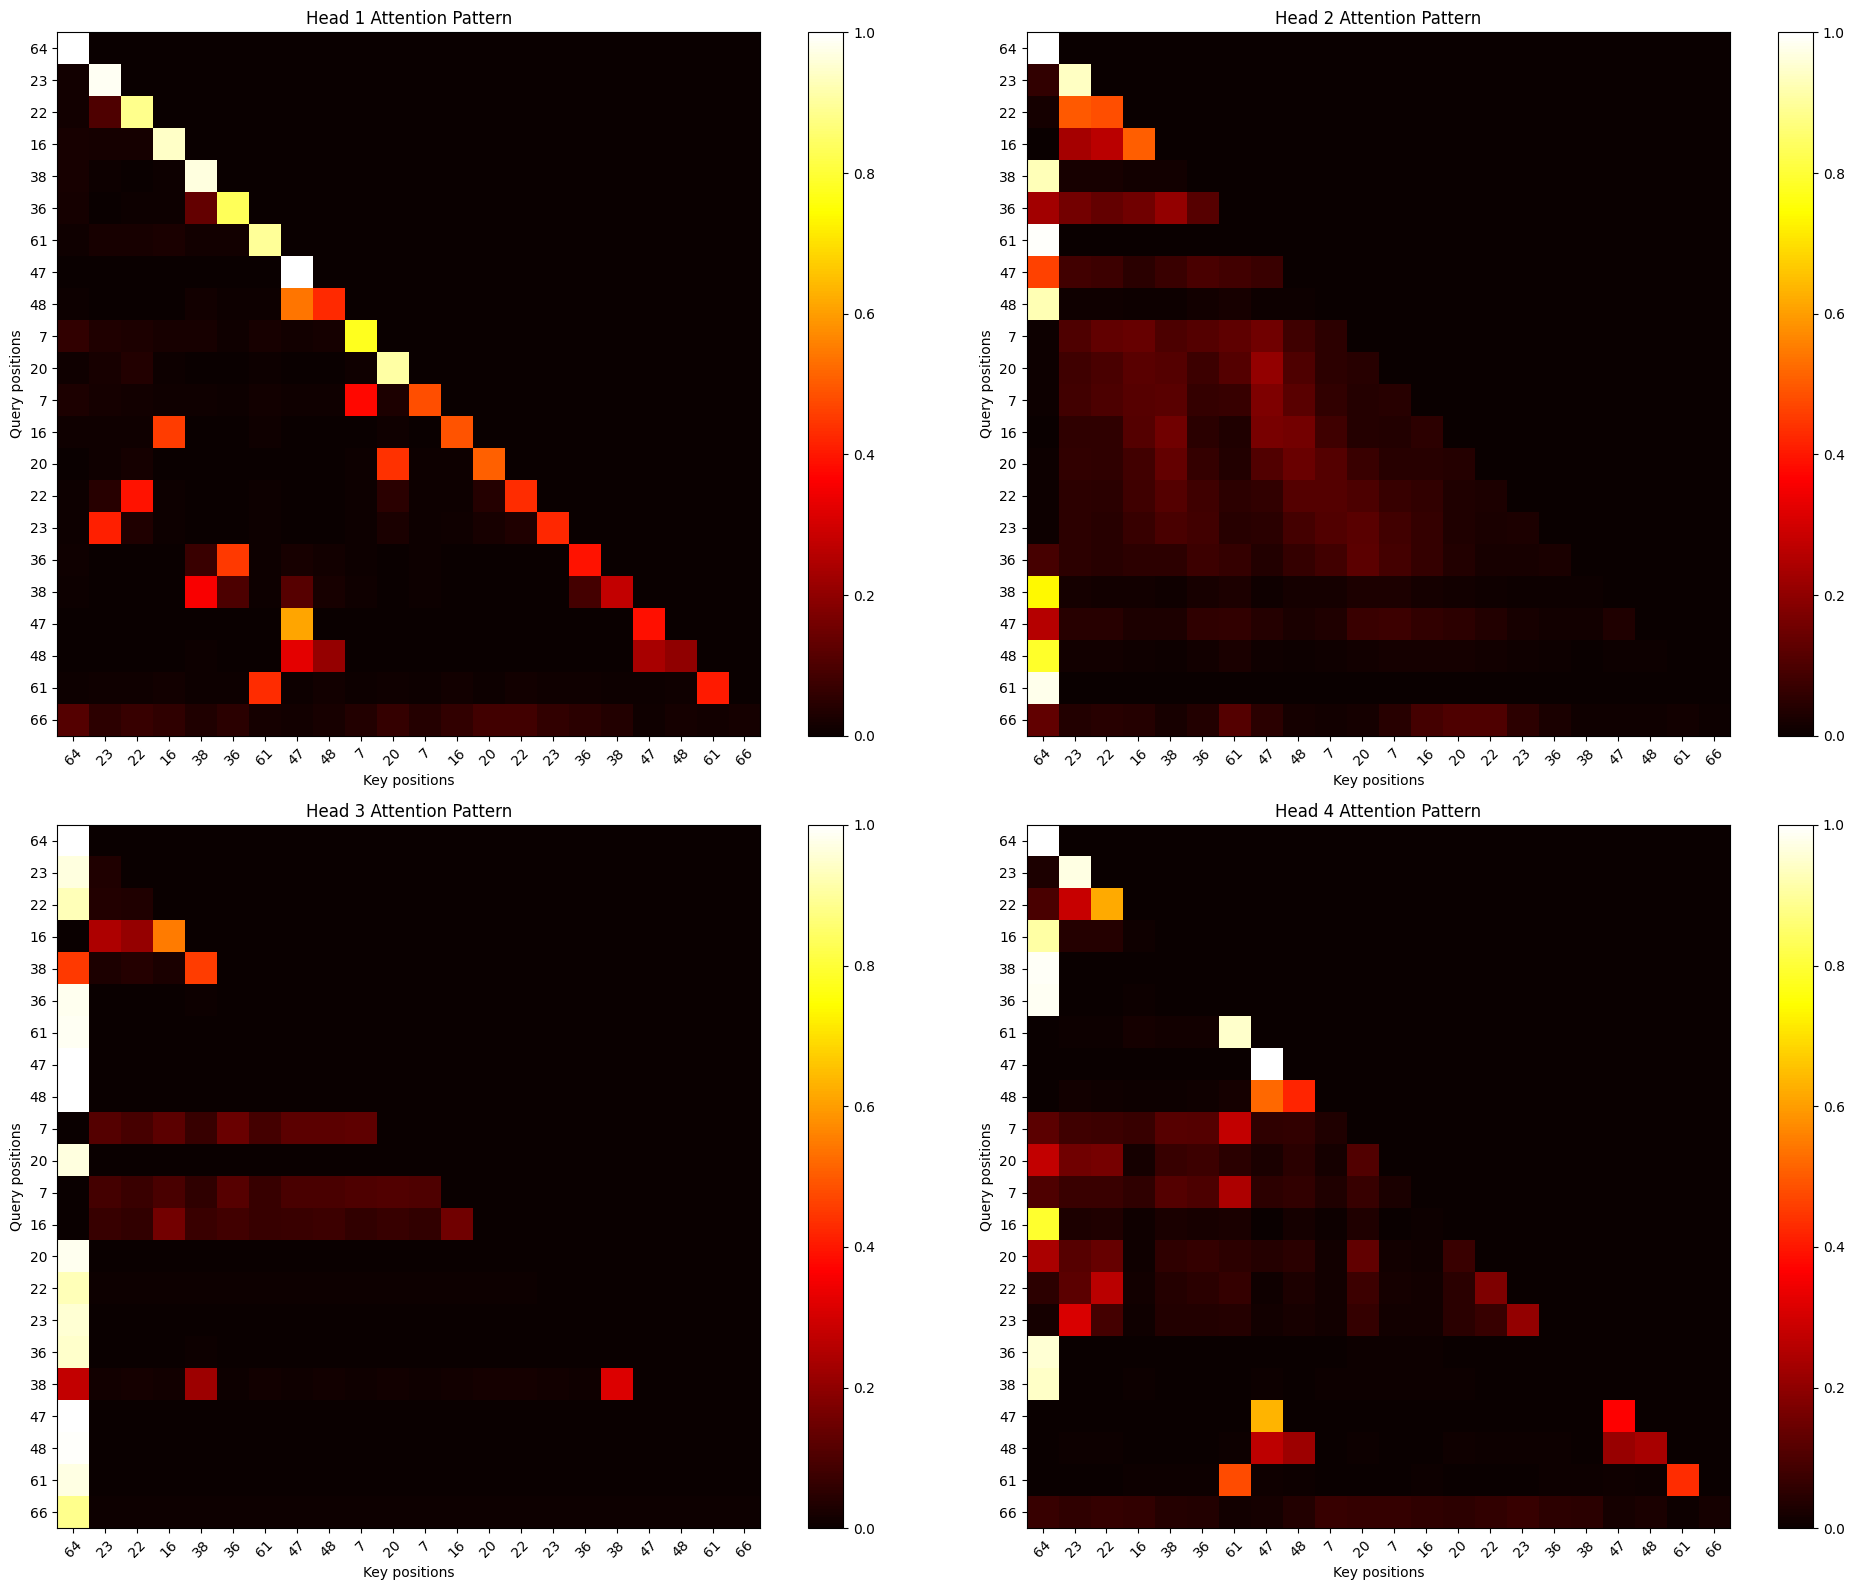


Test 2:
Original: [64 12 31 13 61 23 27  1 63 43 55 65 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Modified: [64 12 31 13 61 23 27  1 63 43 55  1 12 13 23 27 31 43 55 61 63 66 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 12 31 13 61 23 27  1 63 43 55 65  1 12 13 23 27 31 43 55 61 63 66 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 6

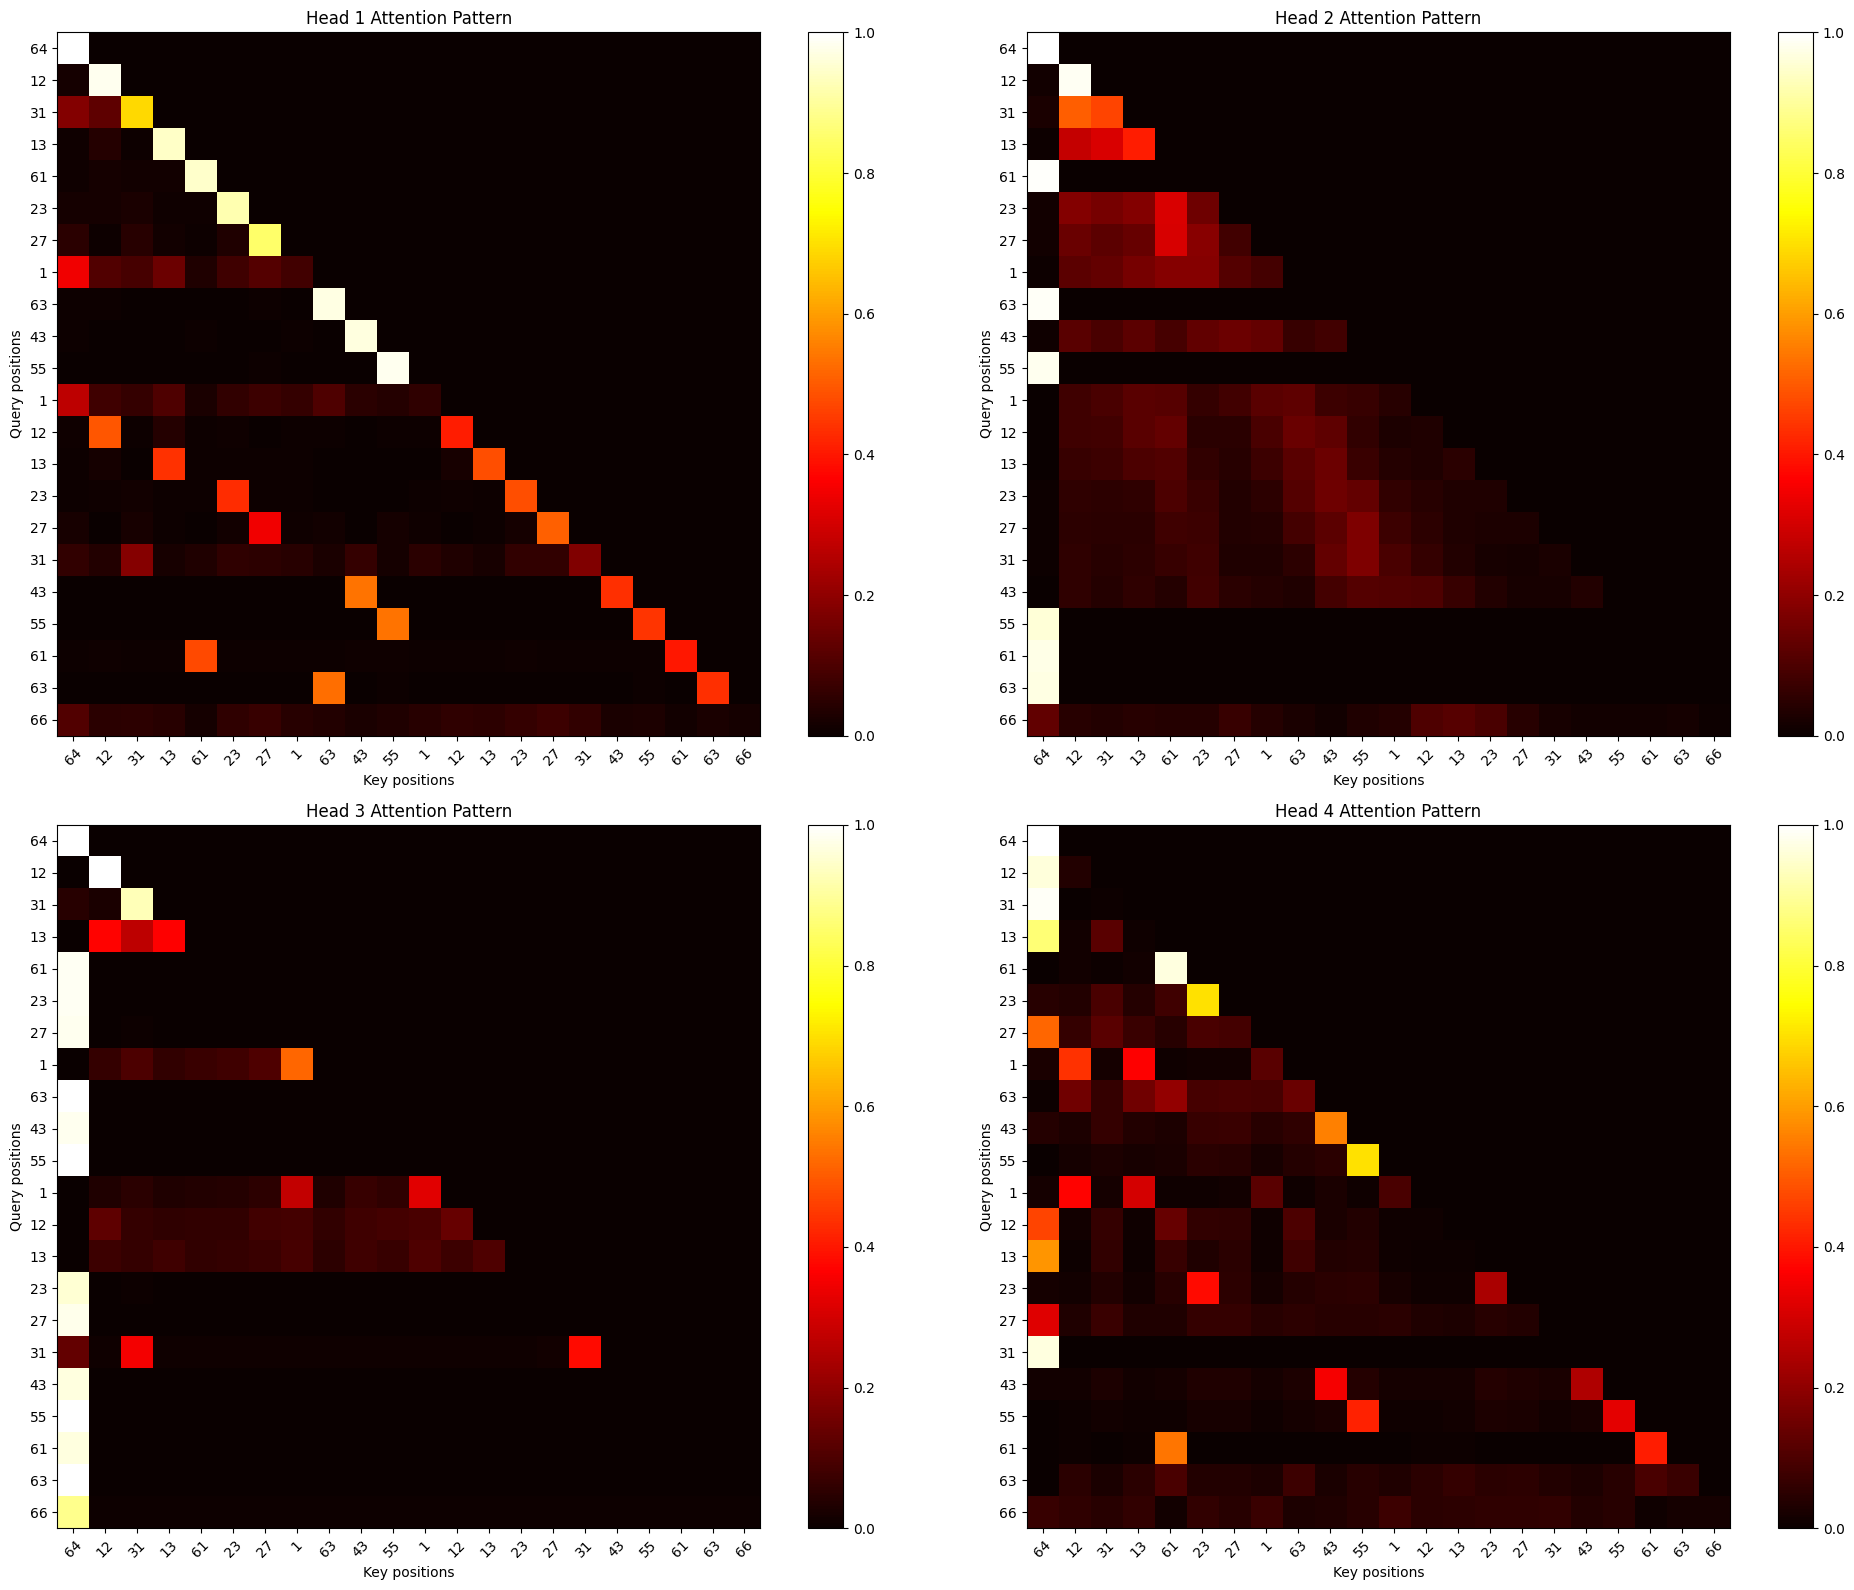


Test 3:
Original: [64  3 55 23 22 15 58 43 34 18 41 65 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Modified: [64  3 55 23 22 15 58 43 34 18 41  3 15 18 22 23 34 41 43 55 58 66 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64  3 55 23 22 15 58 43 34 18 41 65  3 15 18 22 23 34 41 43 55 58 66 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 6

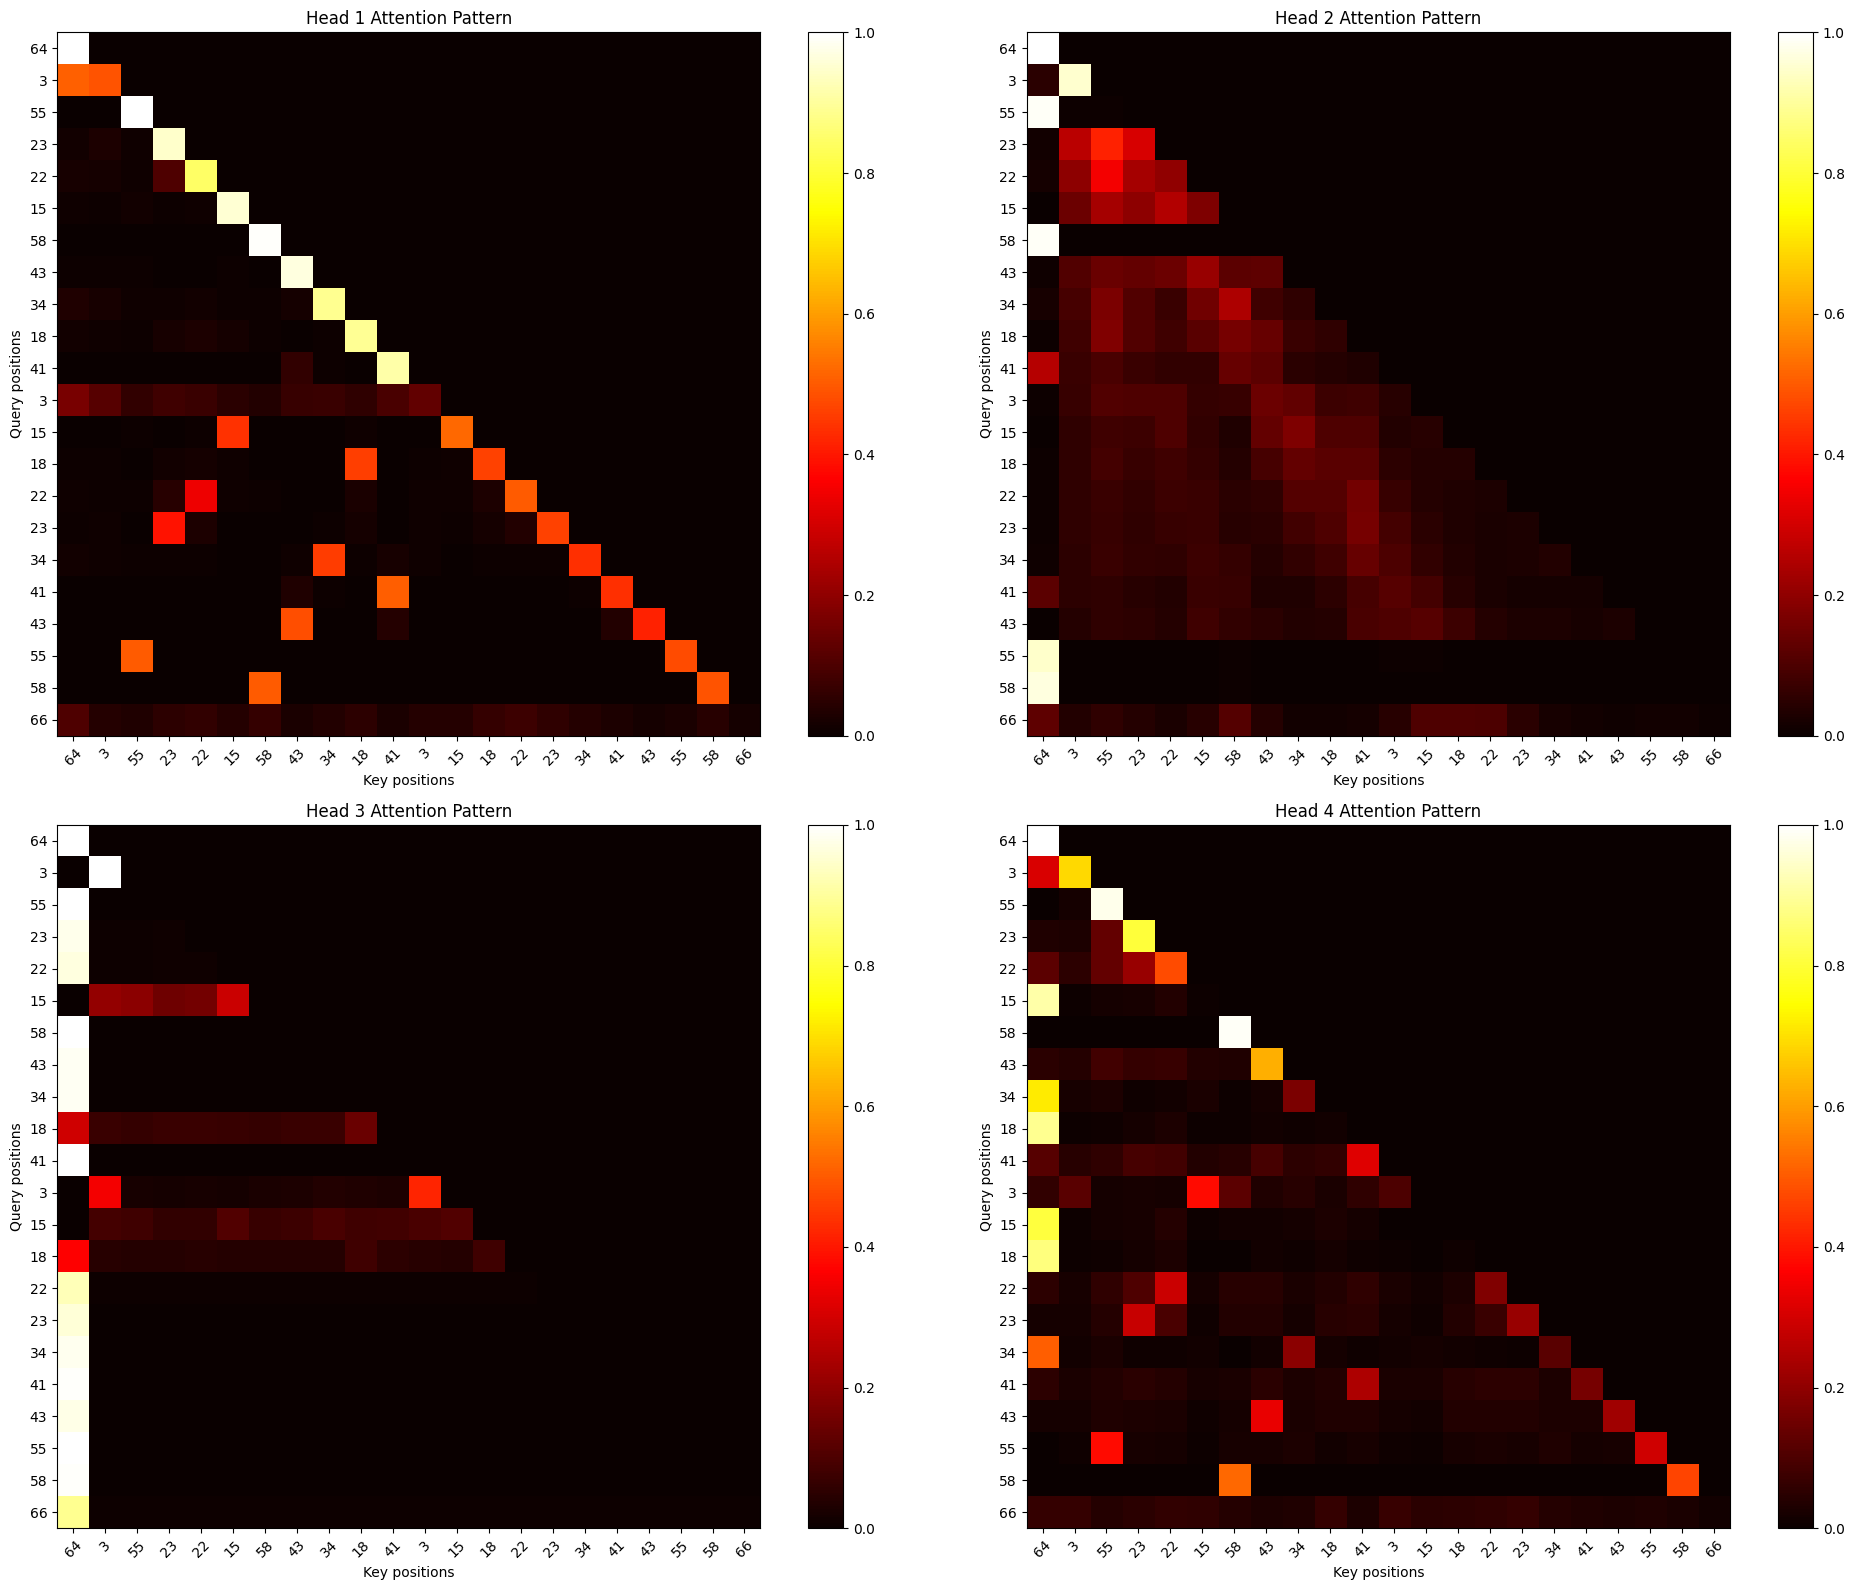


Test 4:
Original: [64 45  6 20  9 48  7 18 41 16 38 65 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Modified: [64 45  6 20  9 48  7 18 41 16 38  6  7  9 16 18 20 38 41 45 48 66 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 45  6 20  9 48  7 18 41 16 38 65  6  7  9 16 18 20 38 41 45 48 66 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 6

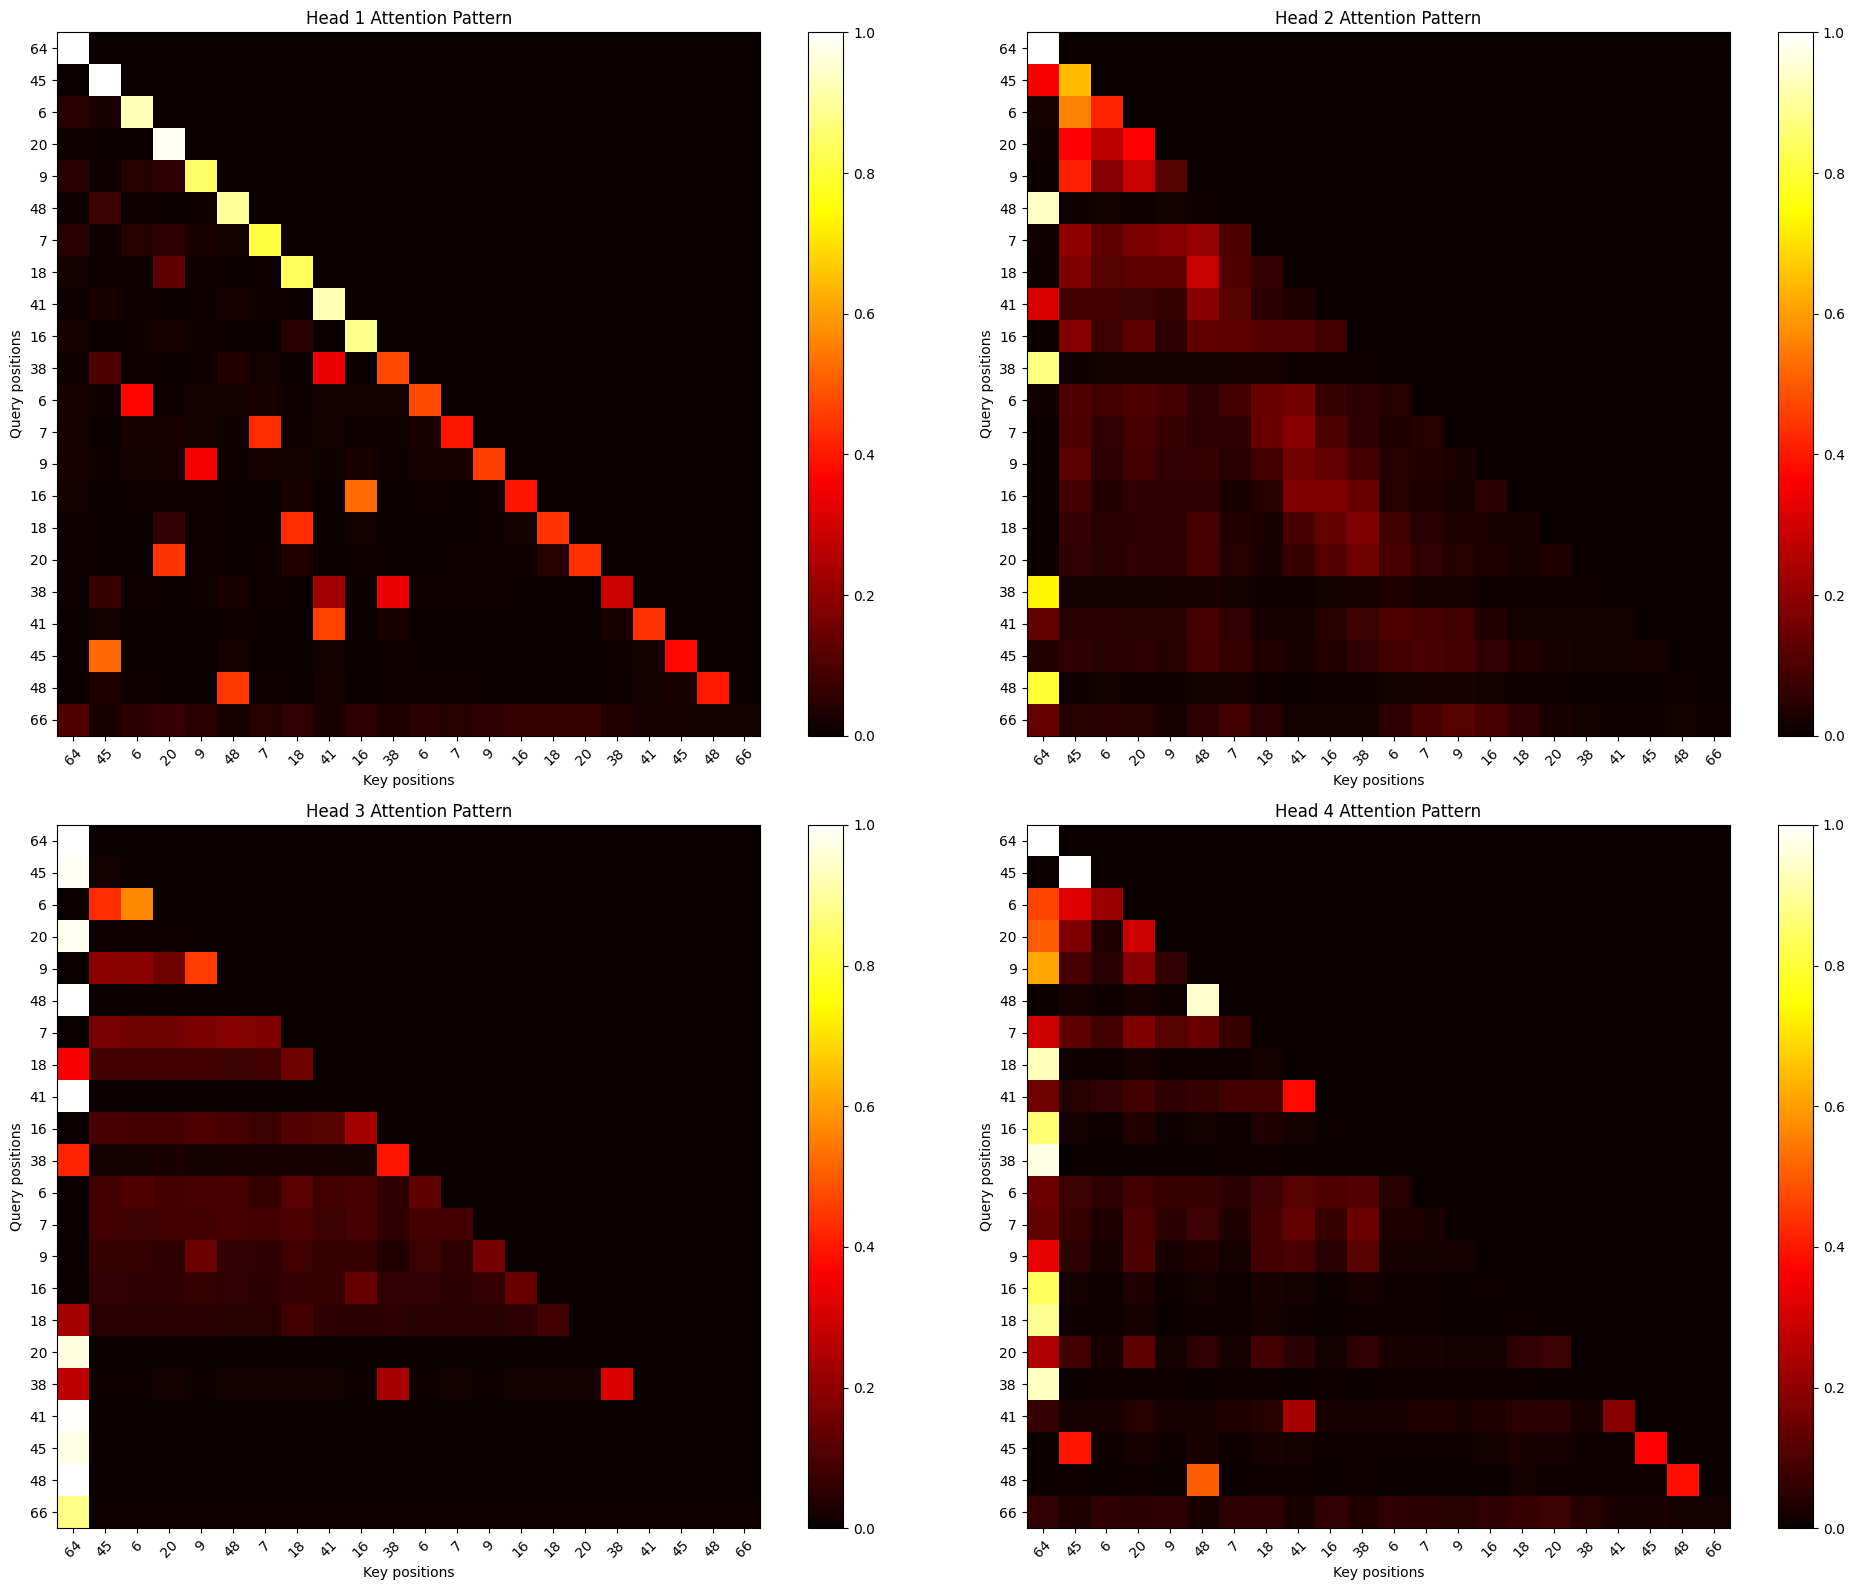


Test 5:
Original: [64  8 52  1 32  6 23 57 58 45 28 65 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Modified: [64  8 52  1 32  6 23 57 58 45 28  1  6  8 23 28 32 45 52 57 58 66 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64  8 52  1 32  6 23 57 58 45 28 65  1  6  8 23 28 32 45 52 57 58 66 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 6

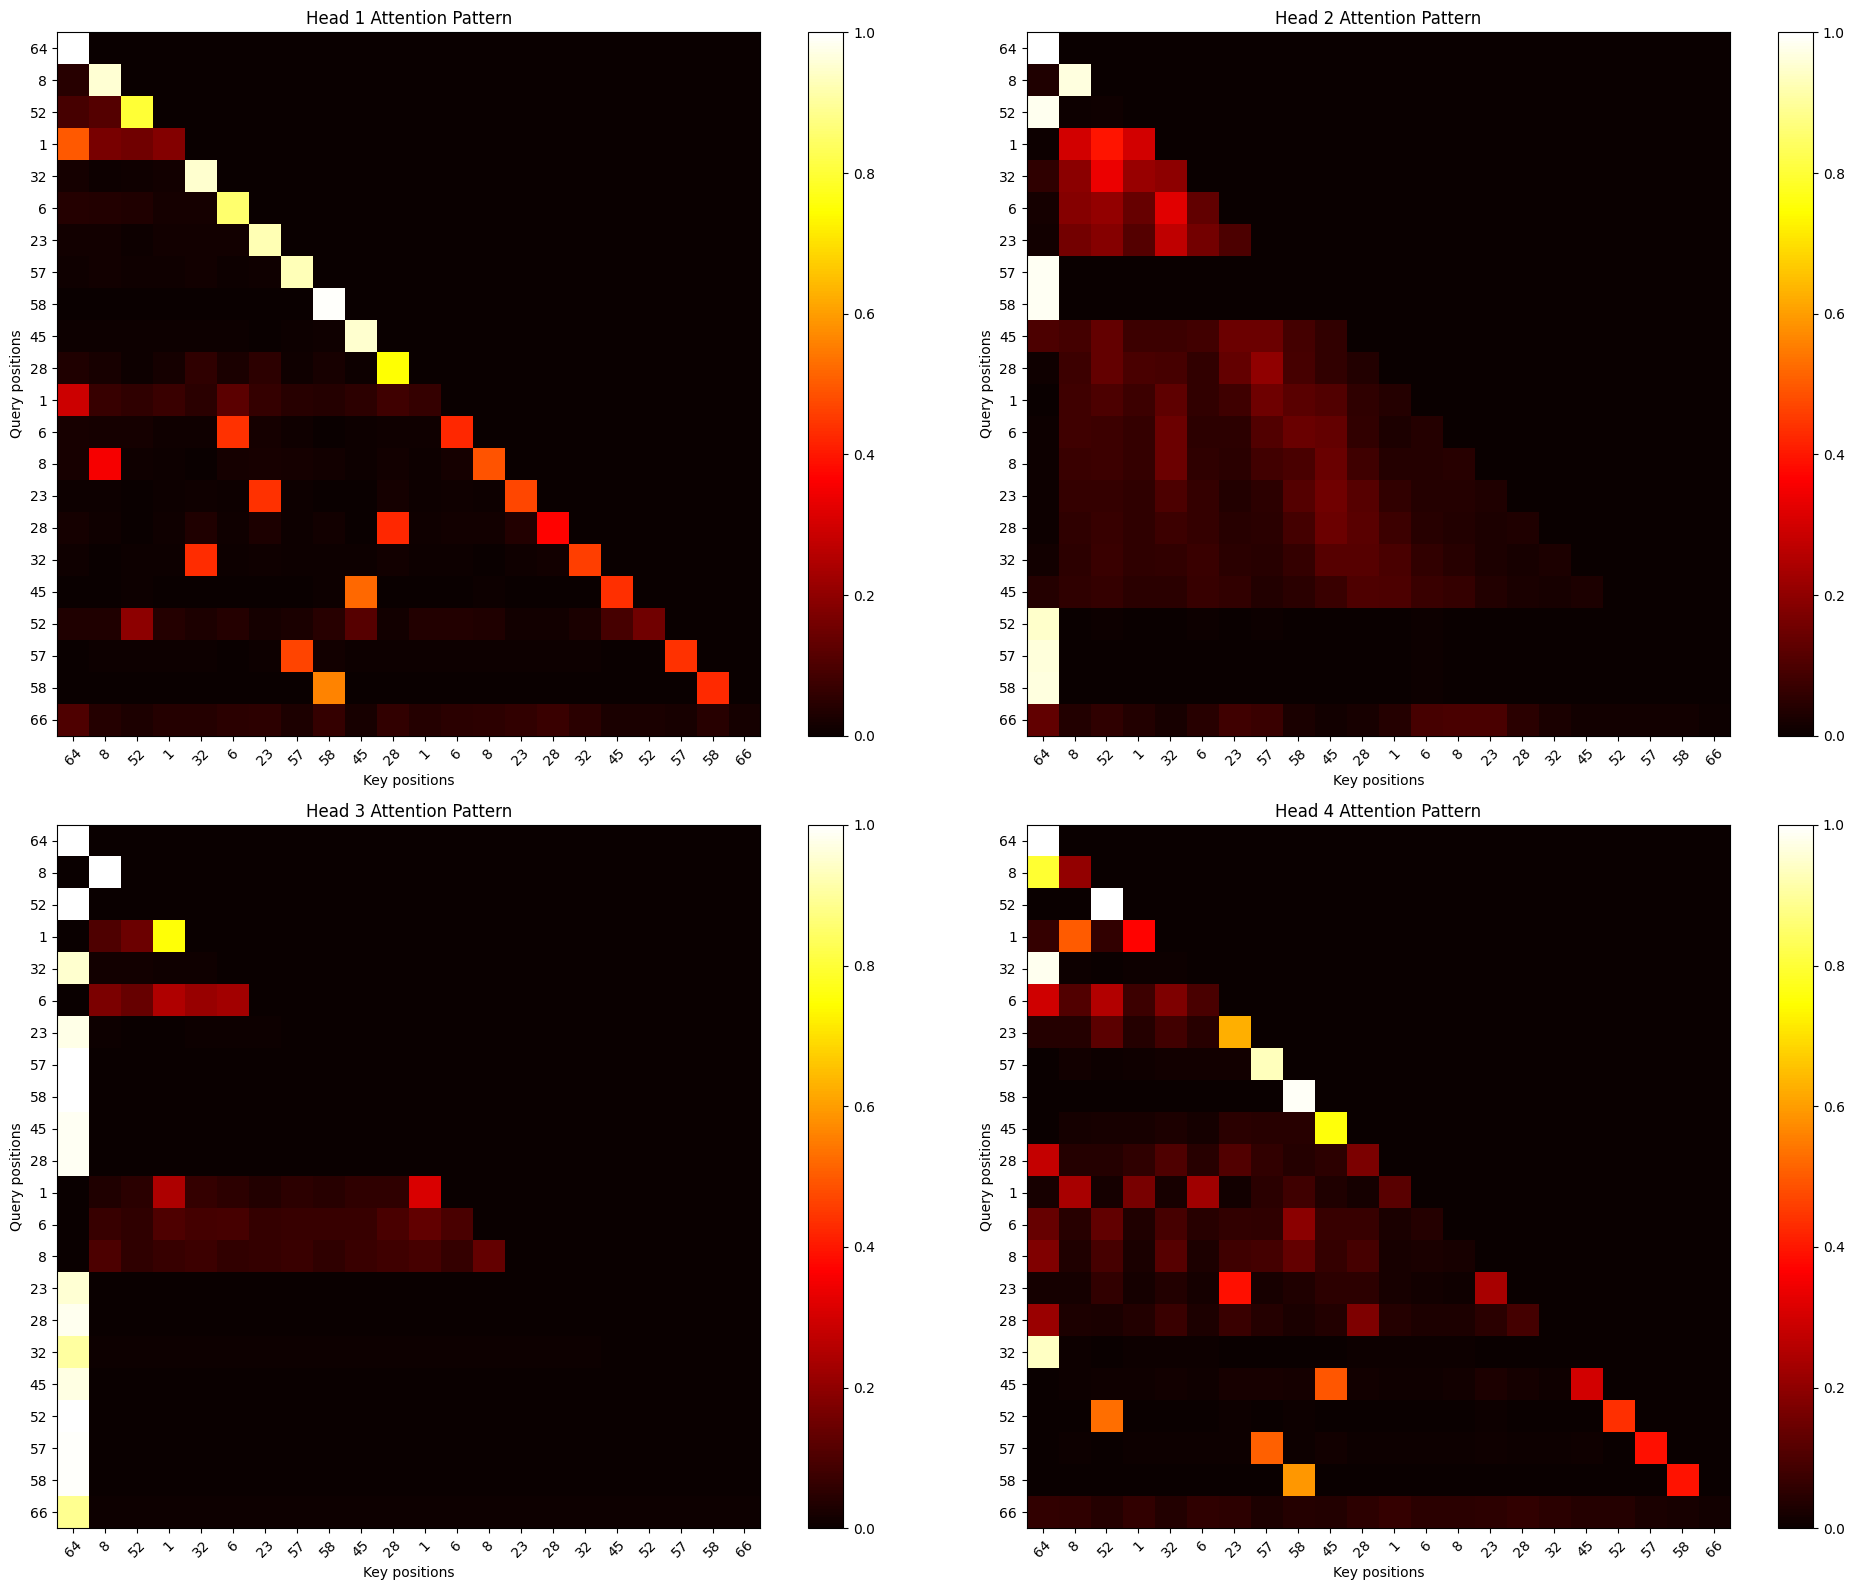


Testing modification: no_both

Test 1:
Original: [64 41  5 57 42 20 36 13 26 33 10 65 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Modified: [41  5 57 42 20 36 13 26 33 10  5 10 13 20 26 33 36 41 42 57 66 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 41  5 57 42 20 36 13 26 33 10 65  5 10 13 20 26 33 36 41 42 57 66 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 6

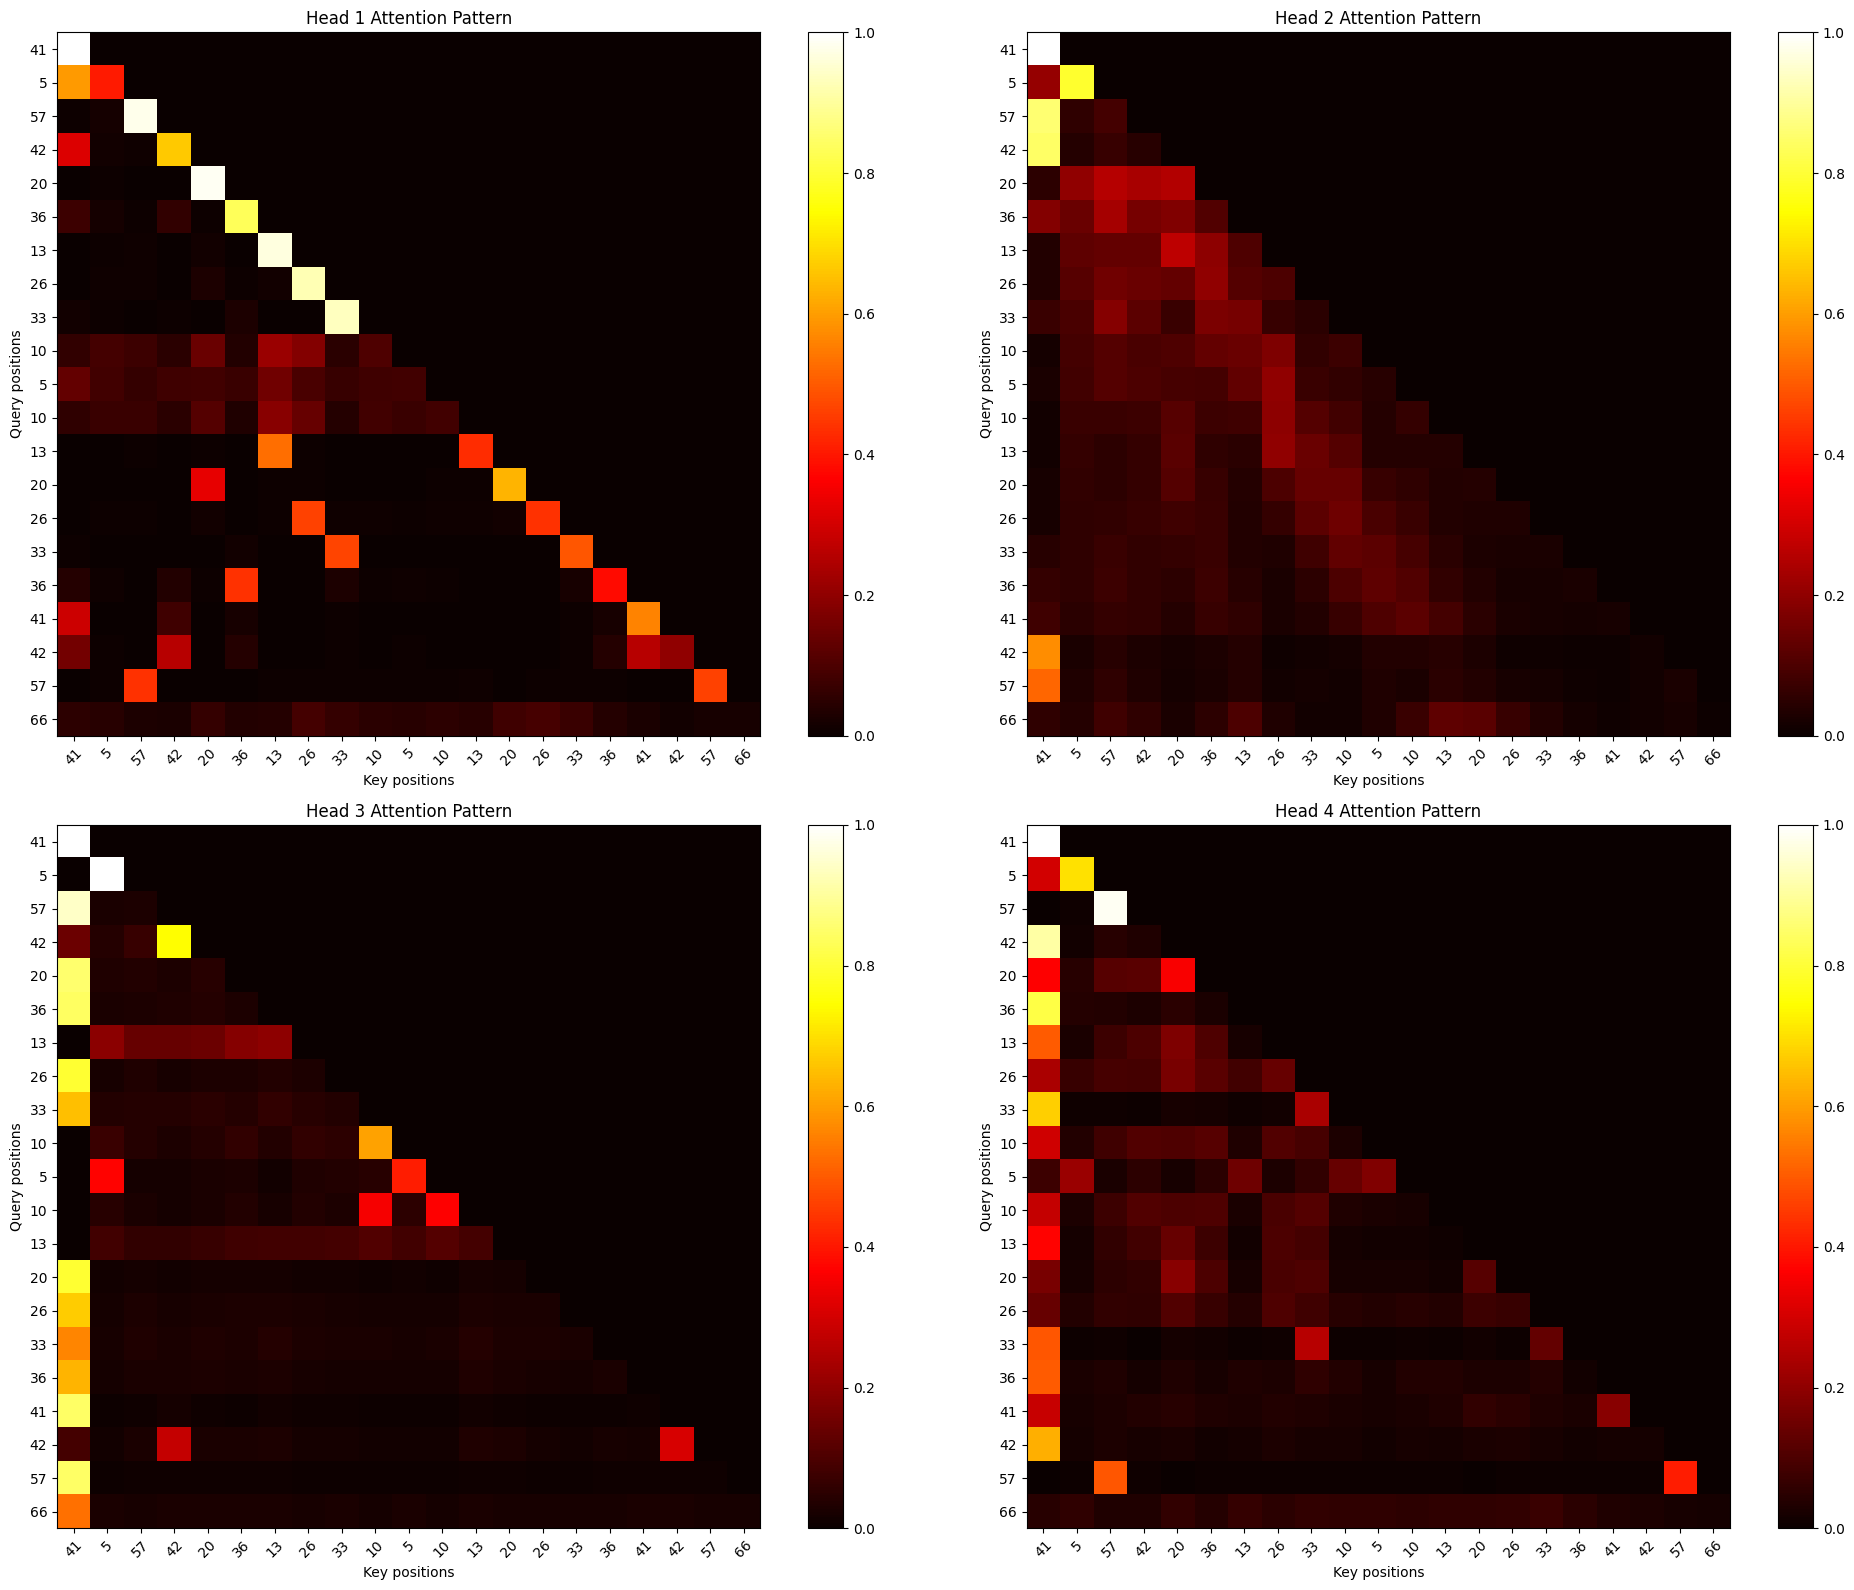


Test 2:
Original: [64 14 33  1 39 51 26 36 54 59  4 65 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Modified: [14 33  1 39 51 26 36 54 59  4  1  4 14 26 33 36 39 51 54 59 66 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 14 33  1 39 51 26 36 54 59  4 65  1  4 14 26 33 36 39 51 54 59 66 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 6

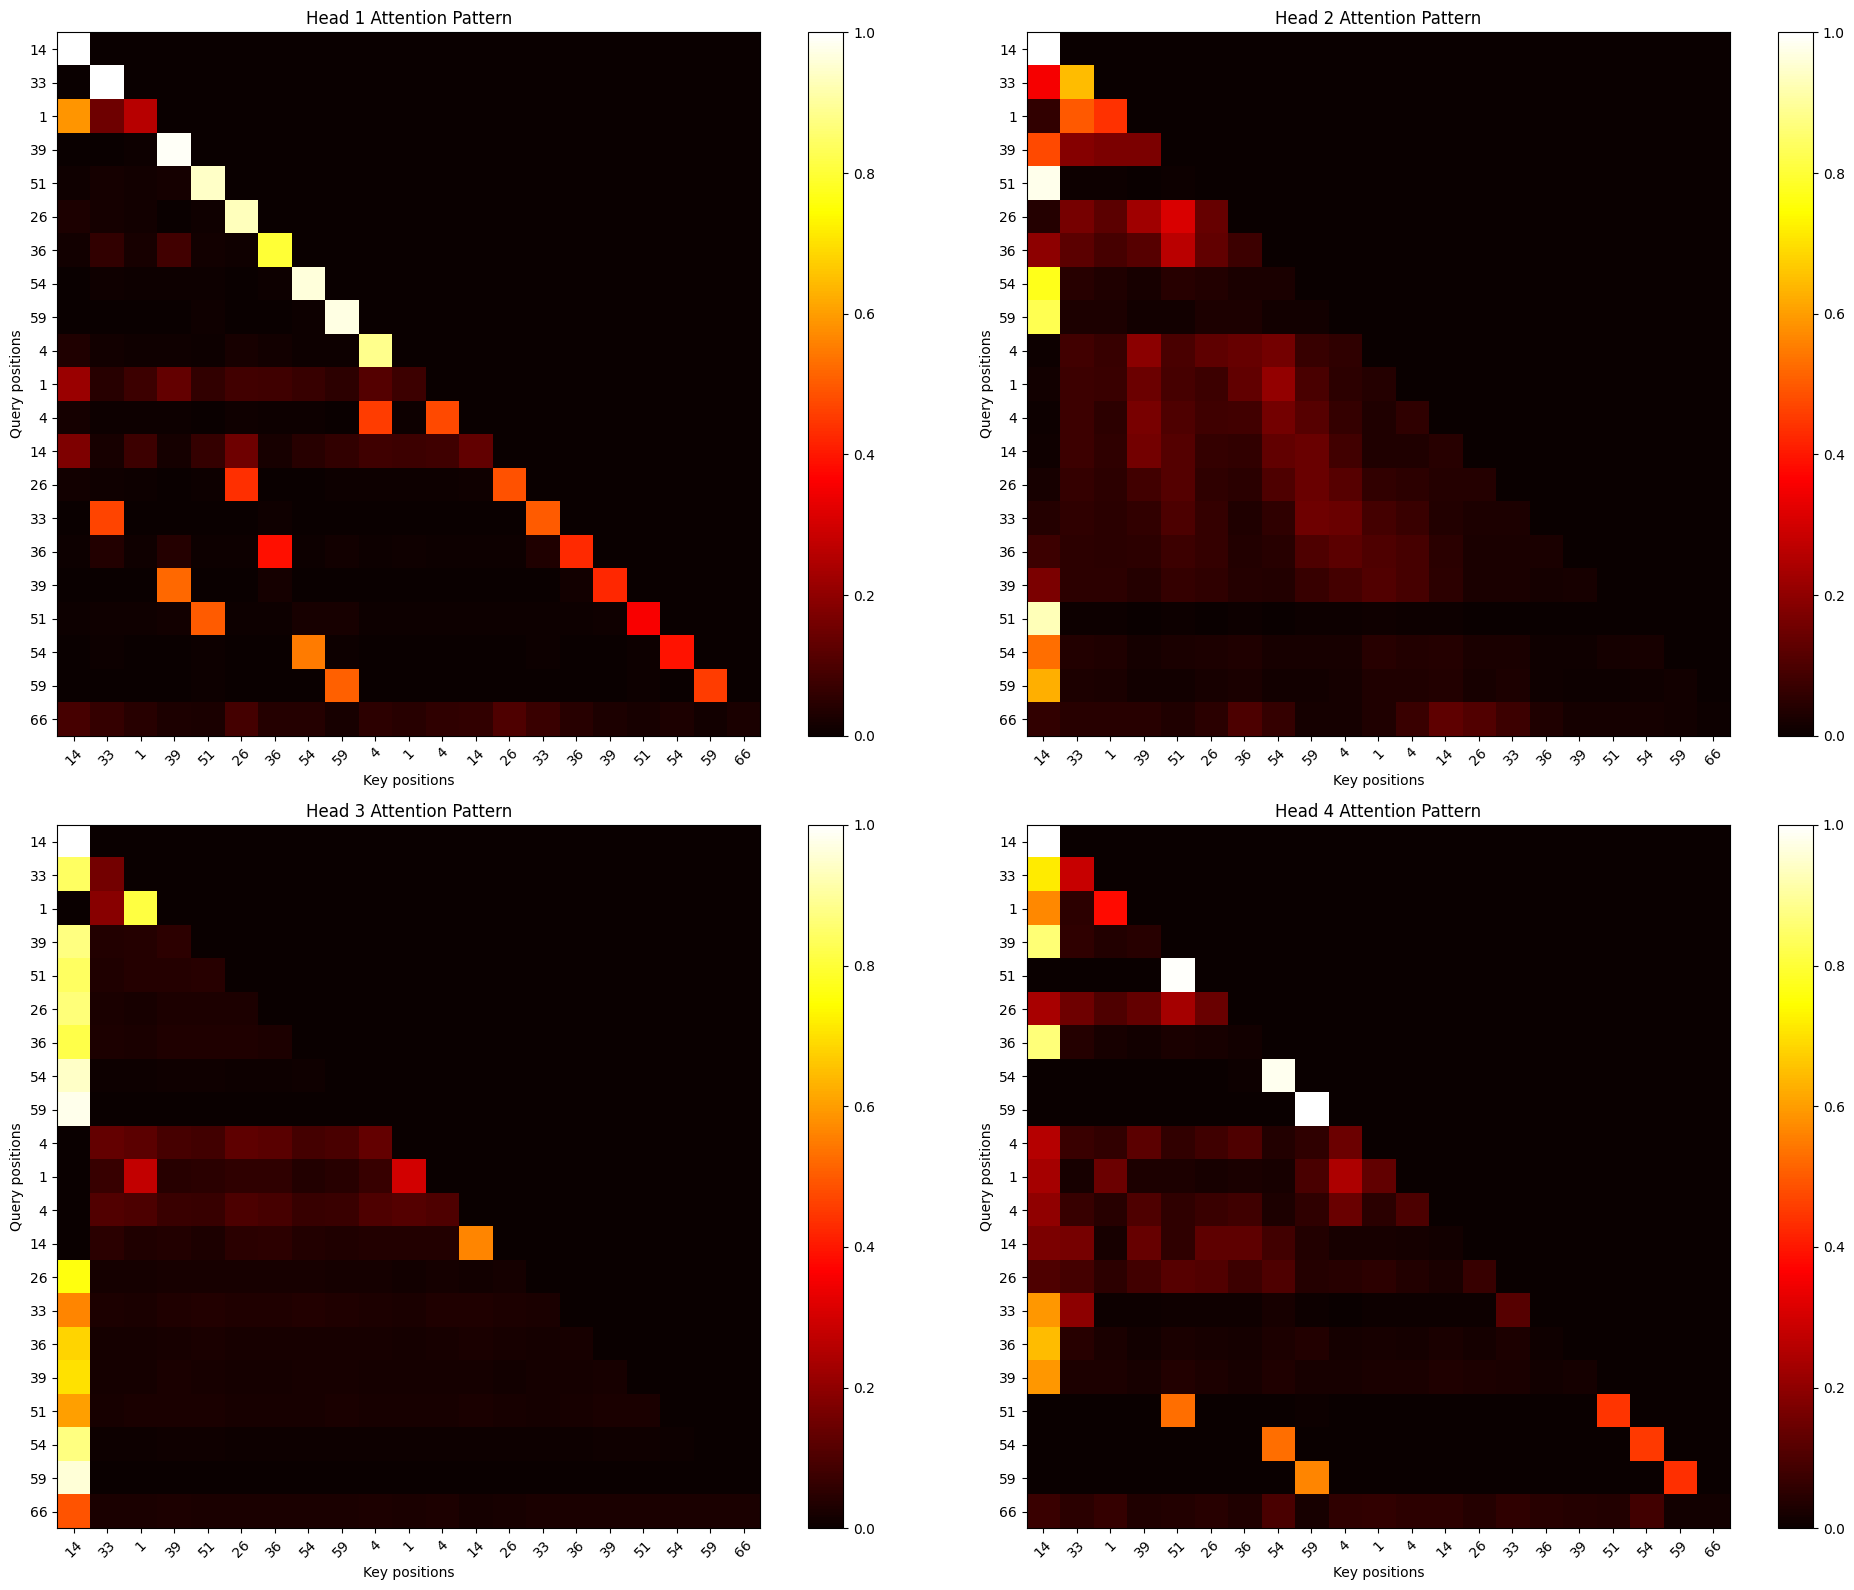


Test 3:
Original: [64 10 23 39 21 61 15 25  3  7 12 65 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Modified: [10 23 39 21 61 15 25  3  7 12  3  7 10 12 15 21 23 25 39 61 66 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 10 23 39 21 61 15 25  3  7 12 65  3  7 10 12 15 21 23 25 39 61 66 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 6

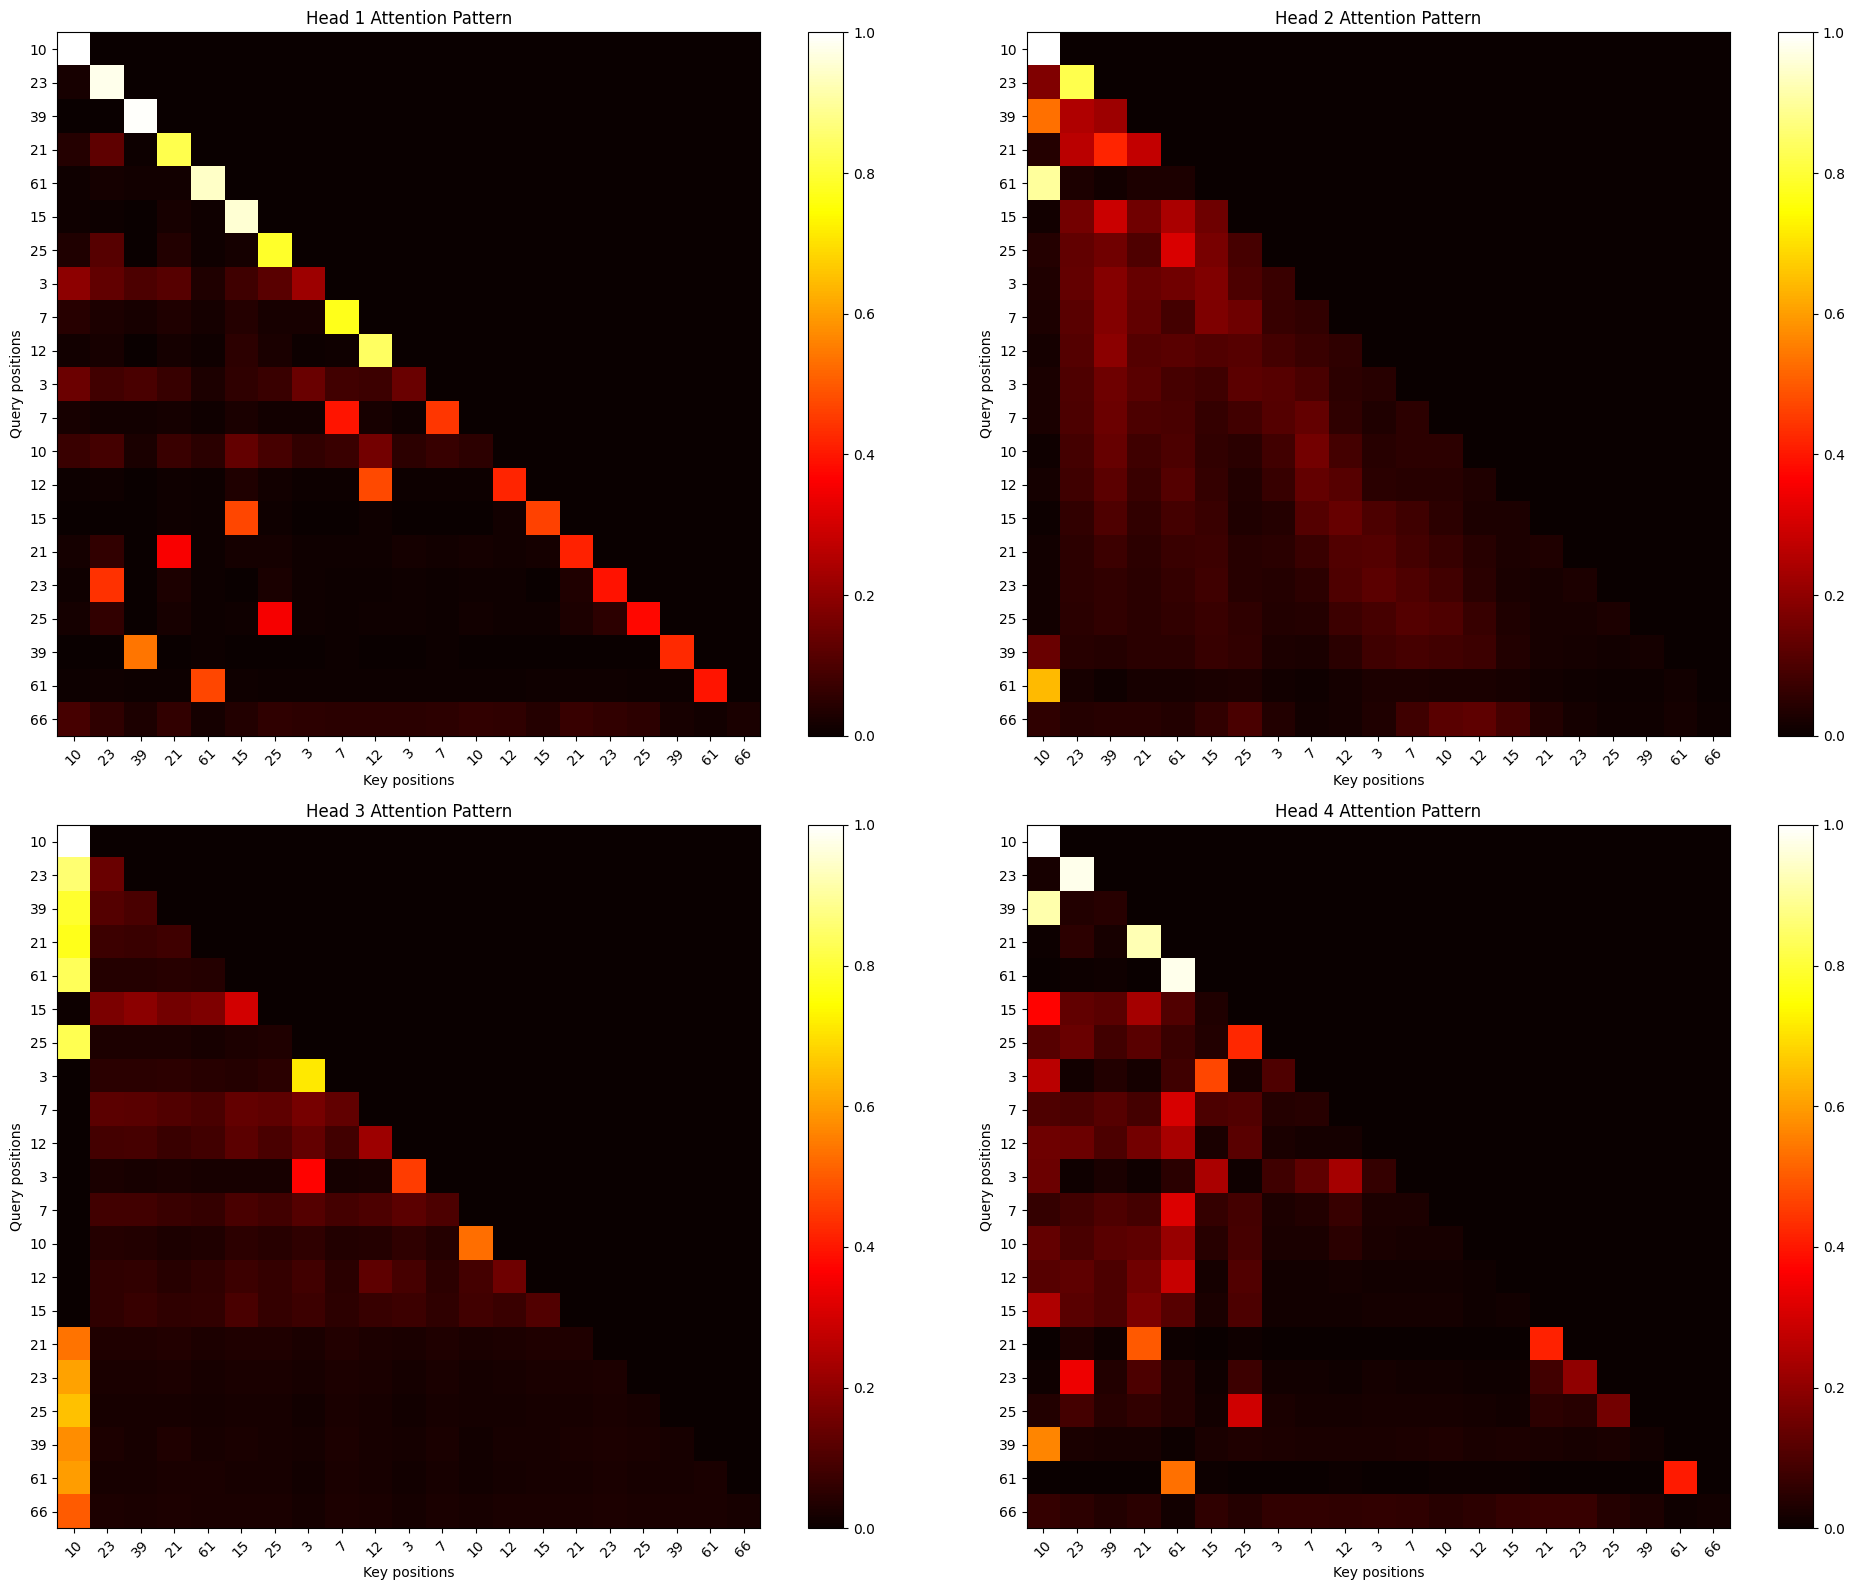


Test 4:
Original: [64 36  3  0 19 43 33 37 52 55 35 65 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Modified: [36  3  0 19 43 33 37 52 55 35  0  3 19 33 35 36 37 43 52 55 66 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 36  3  0 19 43 33 37 52 55 35 65  0  3 19 33 35 36 37 43 52 55 66 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 6

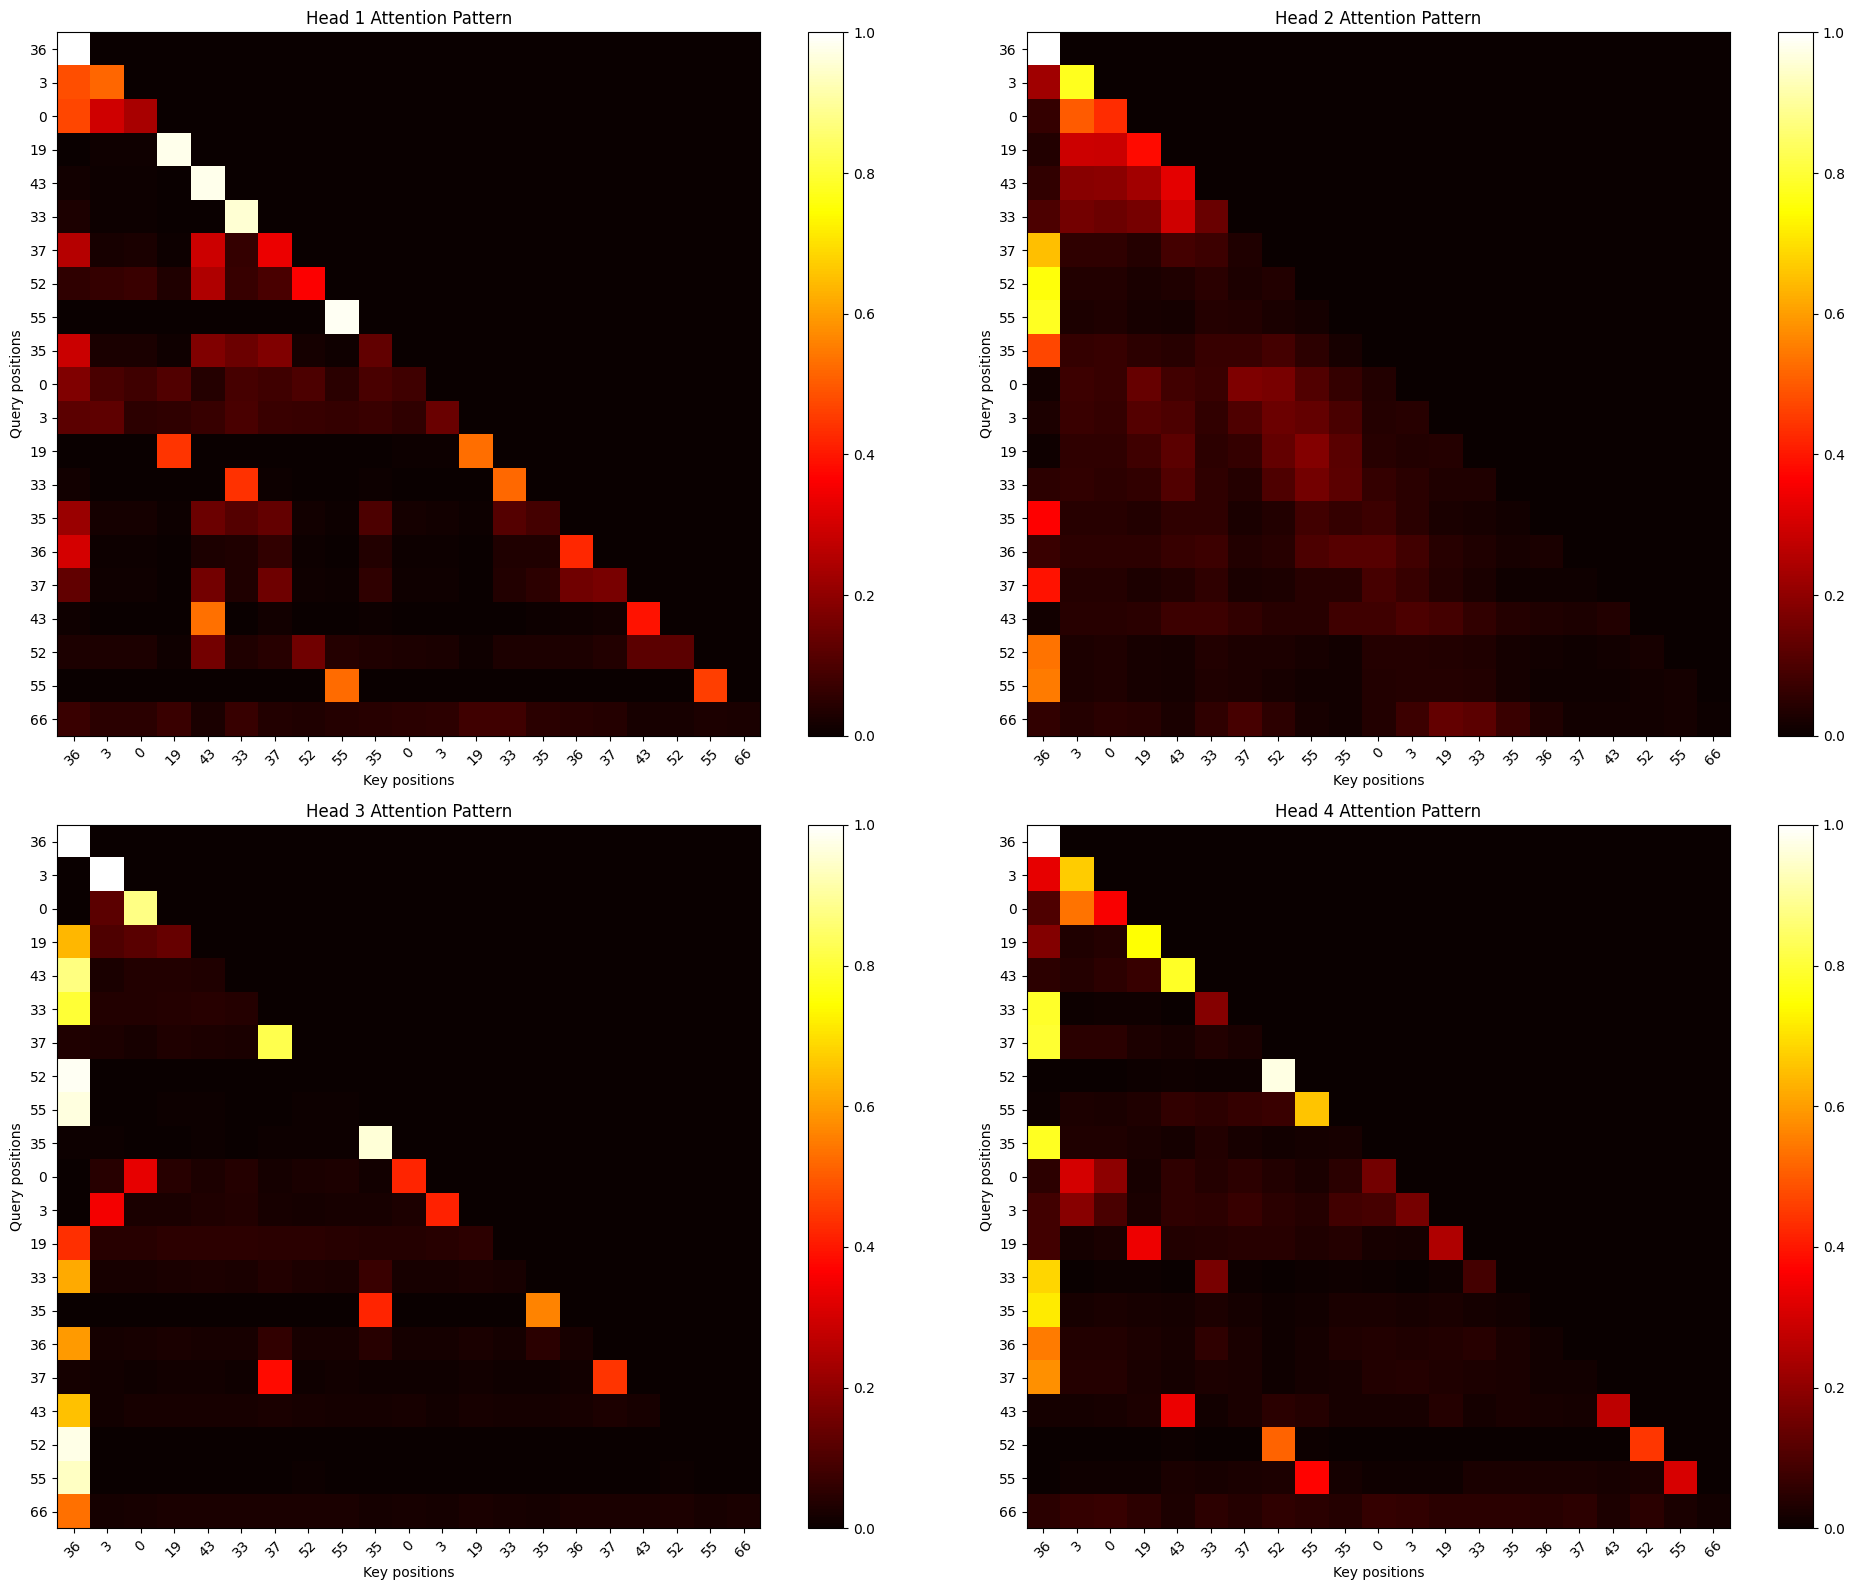


Test 5:
Original: [64 15 52 28 29 19 60 33 48 43  7 65 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Modified: [15 52 28 29 19 60 33 48 43  7  7 15 19 28 29 33 43 48 52 60 66 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 15 52 28 29 19 60 33 48 43  7 65  7 15 19 28 29 33 43 48 52 60 66 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 6

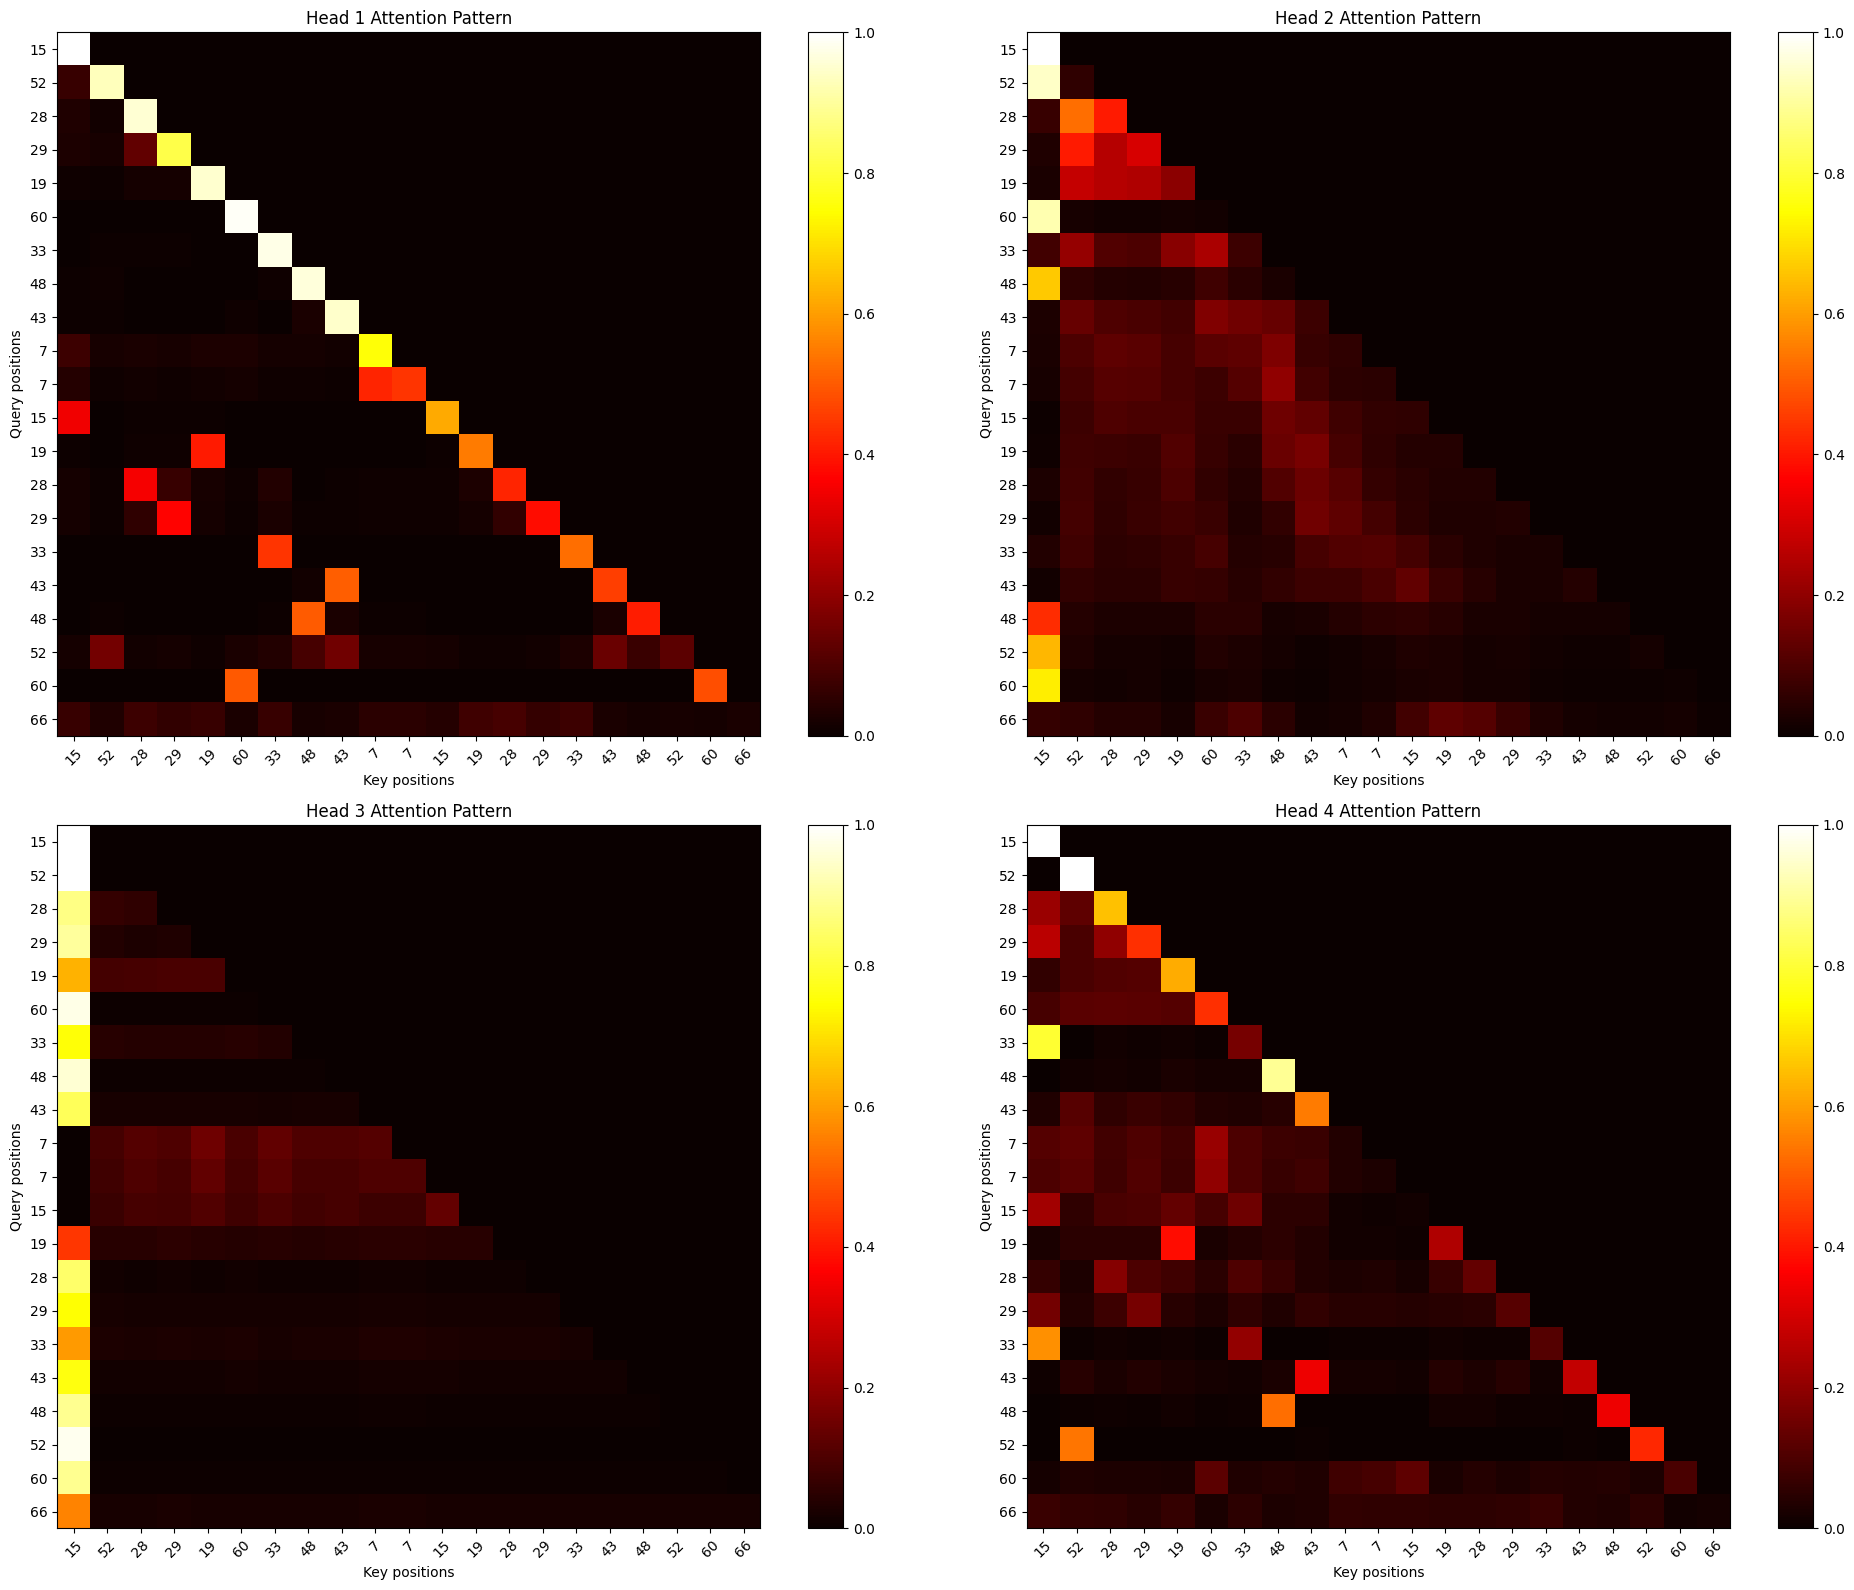


Testing modification: swap

Test 1:
Original: [64 54 15 35  1  8  2 24 12 28  7 65 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Modified: [65 54 15 35  1  8  2 24 12 28  7 64  1  2  7  8 12 15 24 28 35 54 66 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 54 15 35  1  8  2 24 12 28  7 65  1  2  7  8 12 15 24 28 35 54 66 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 6

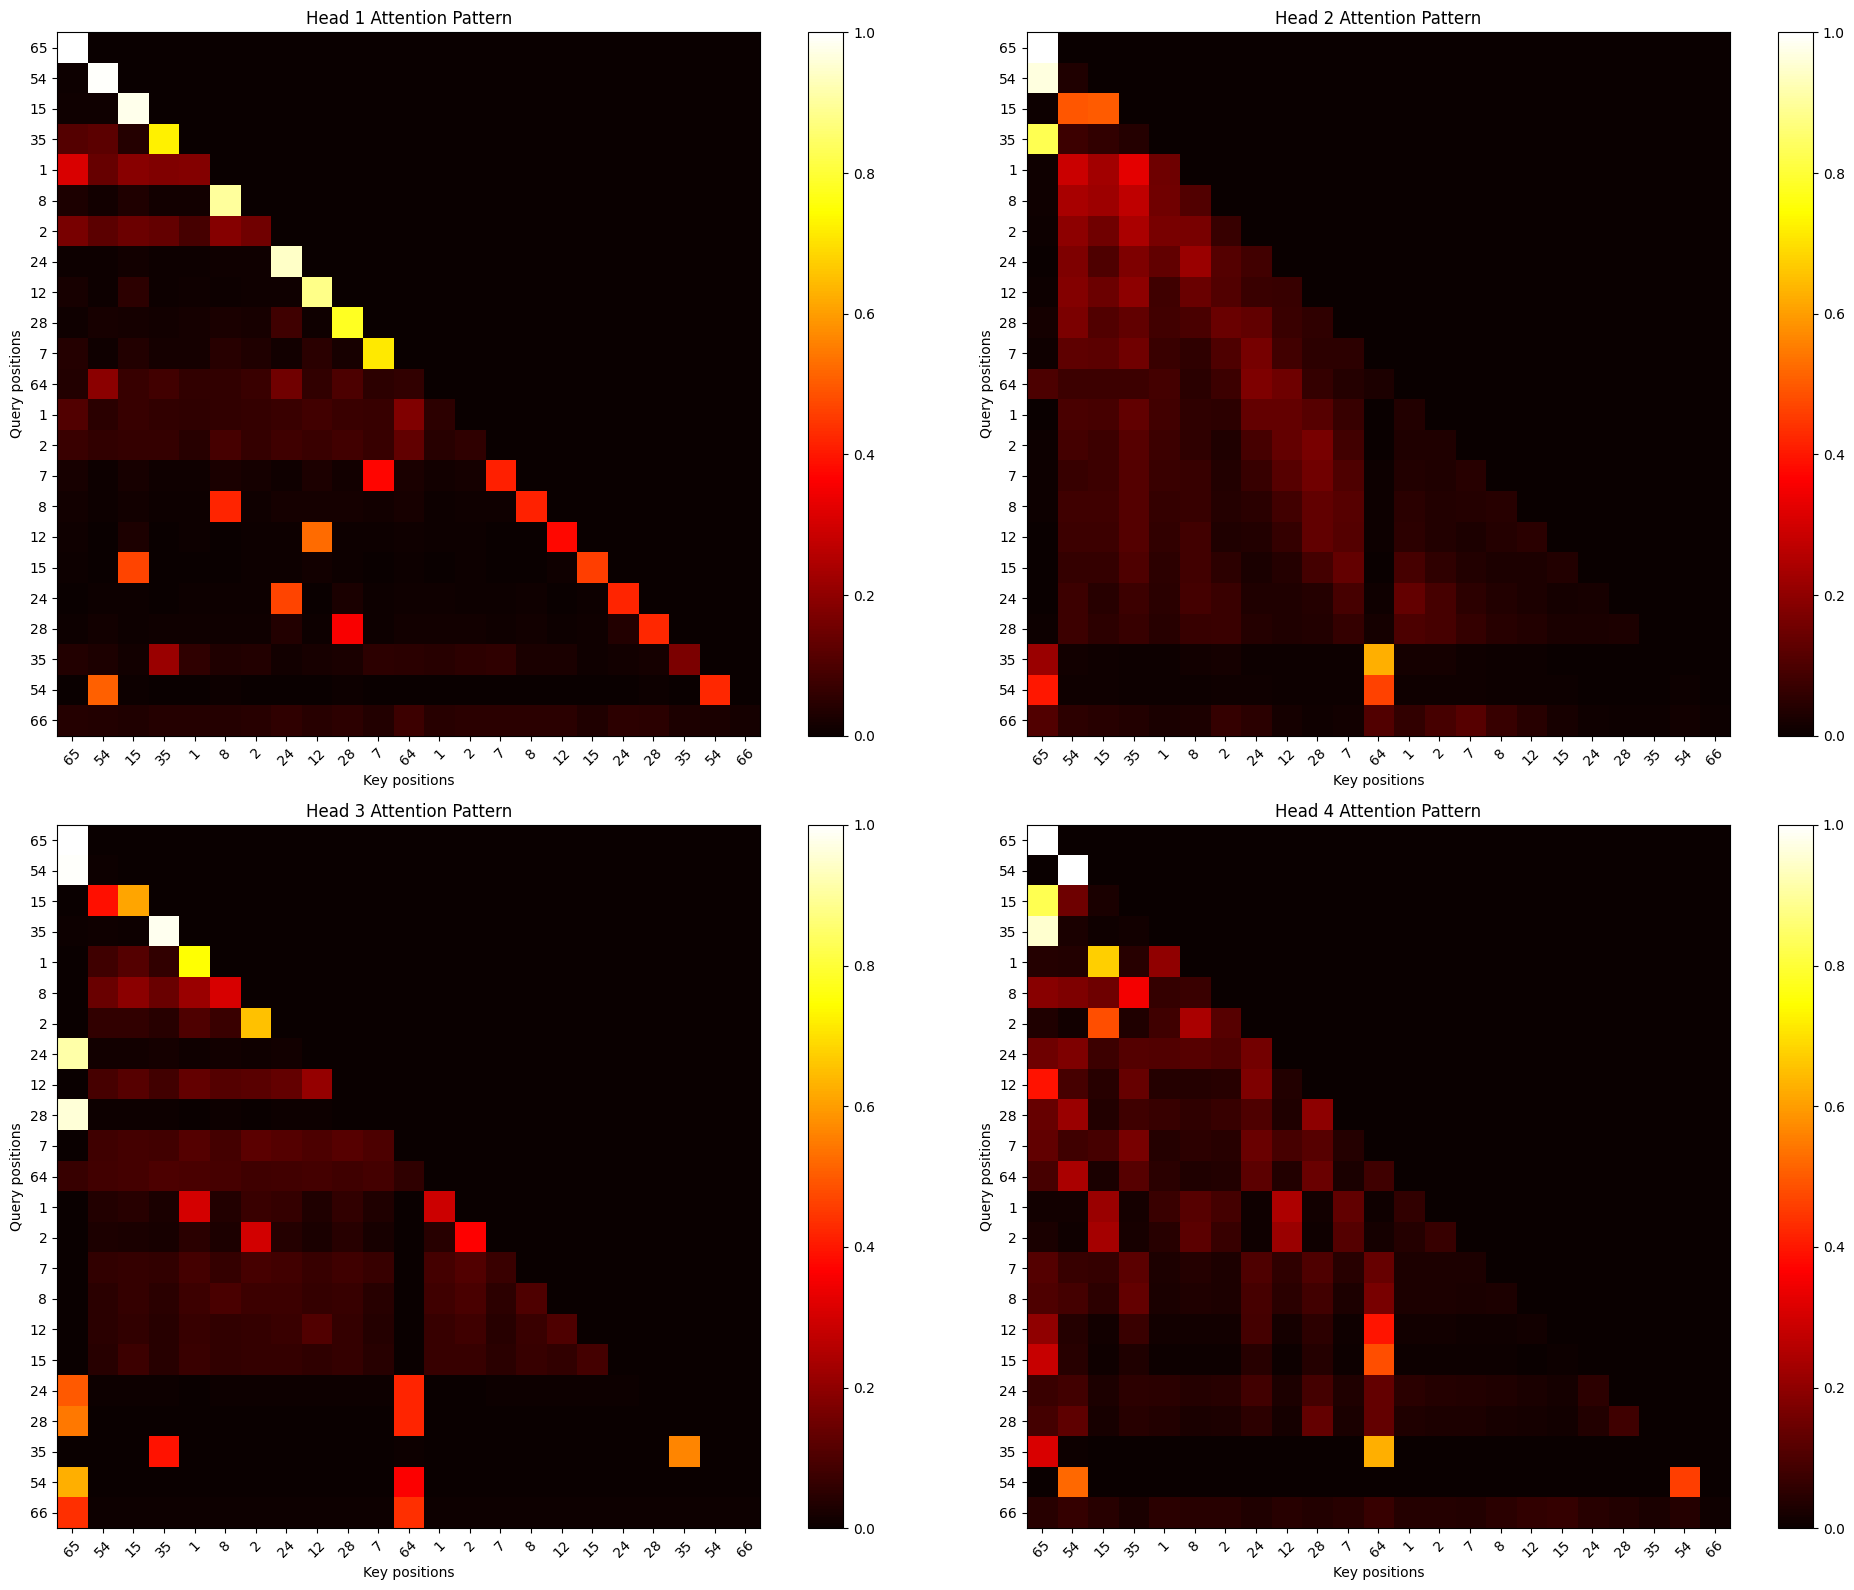


Test 2:
Original: [64  2 22 52  1 16 46 39 57 45 29 65 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Modified: [65  2 22 52  1 16 46 39 57 45 29 64  1  2 16 22 29 39 45 46 52 57 66 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64  2 22 52  1 16 46 39 57 45 29 65  1  2 16 22 29 39 45 46 52 57 66 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 6

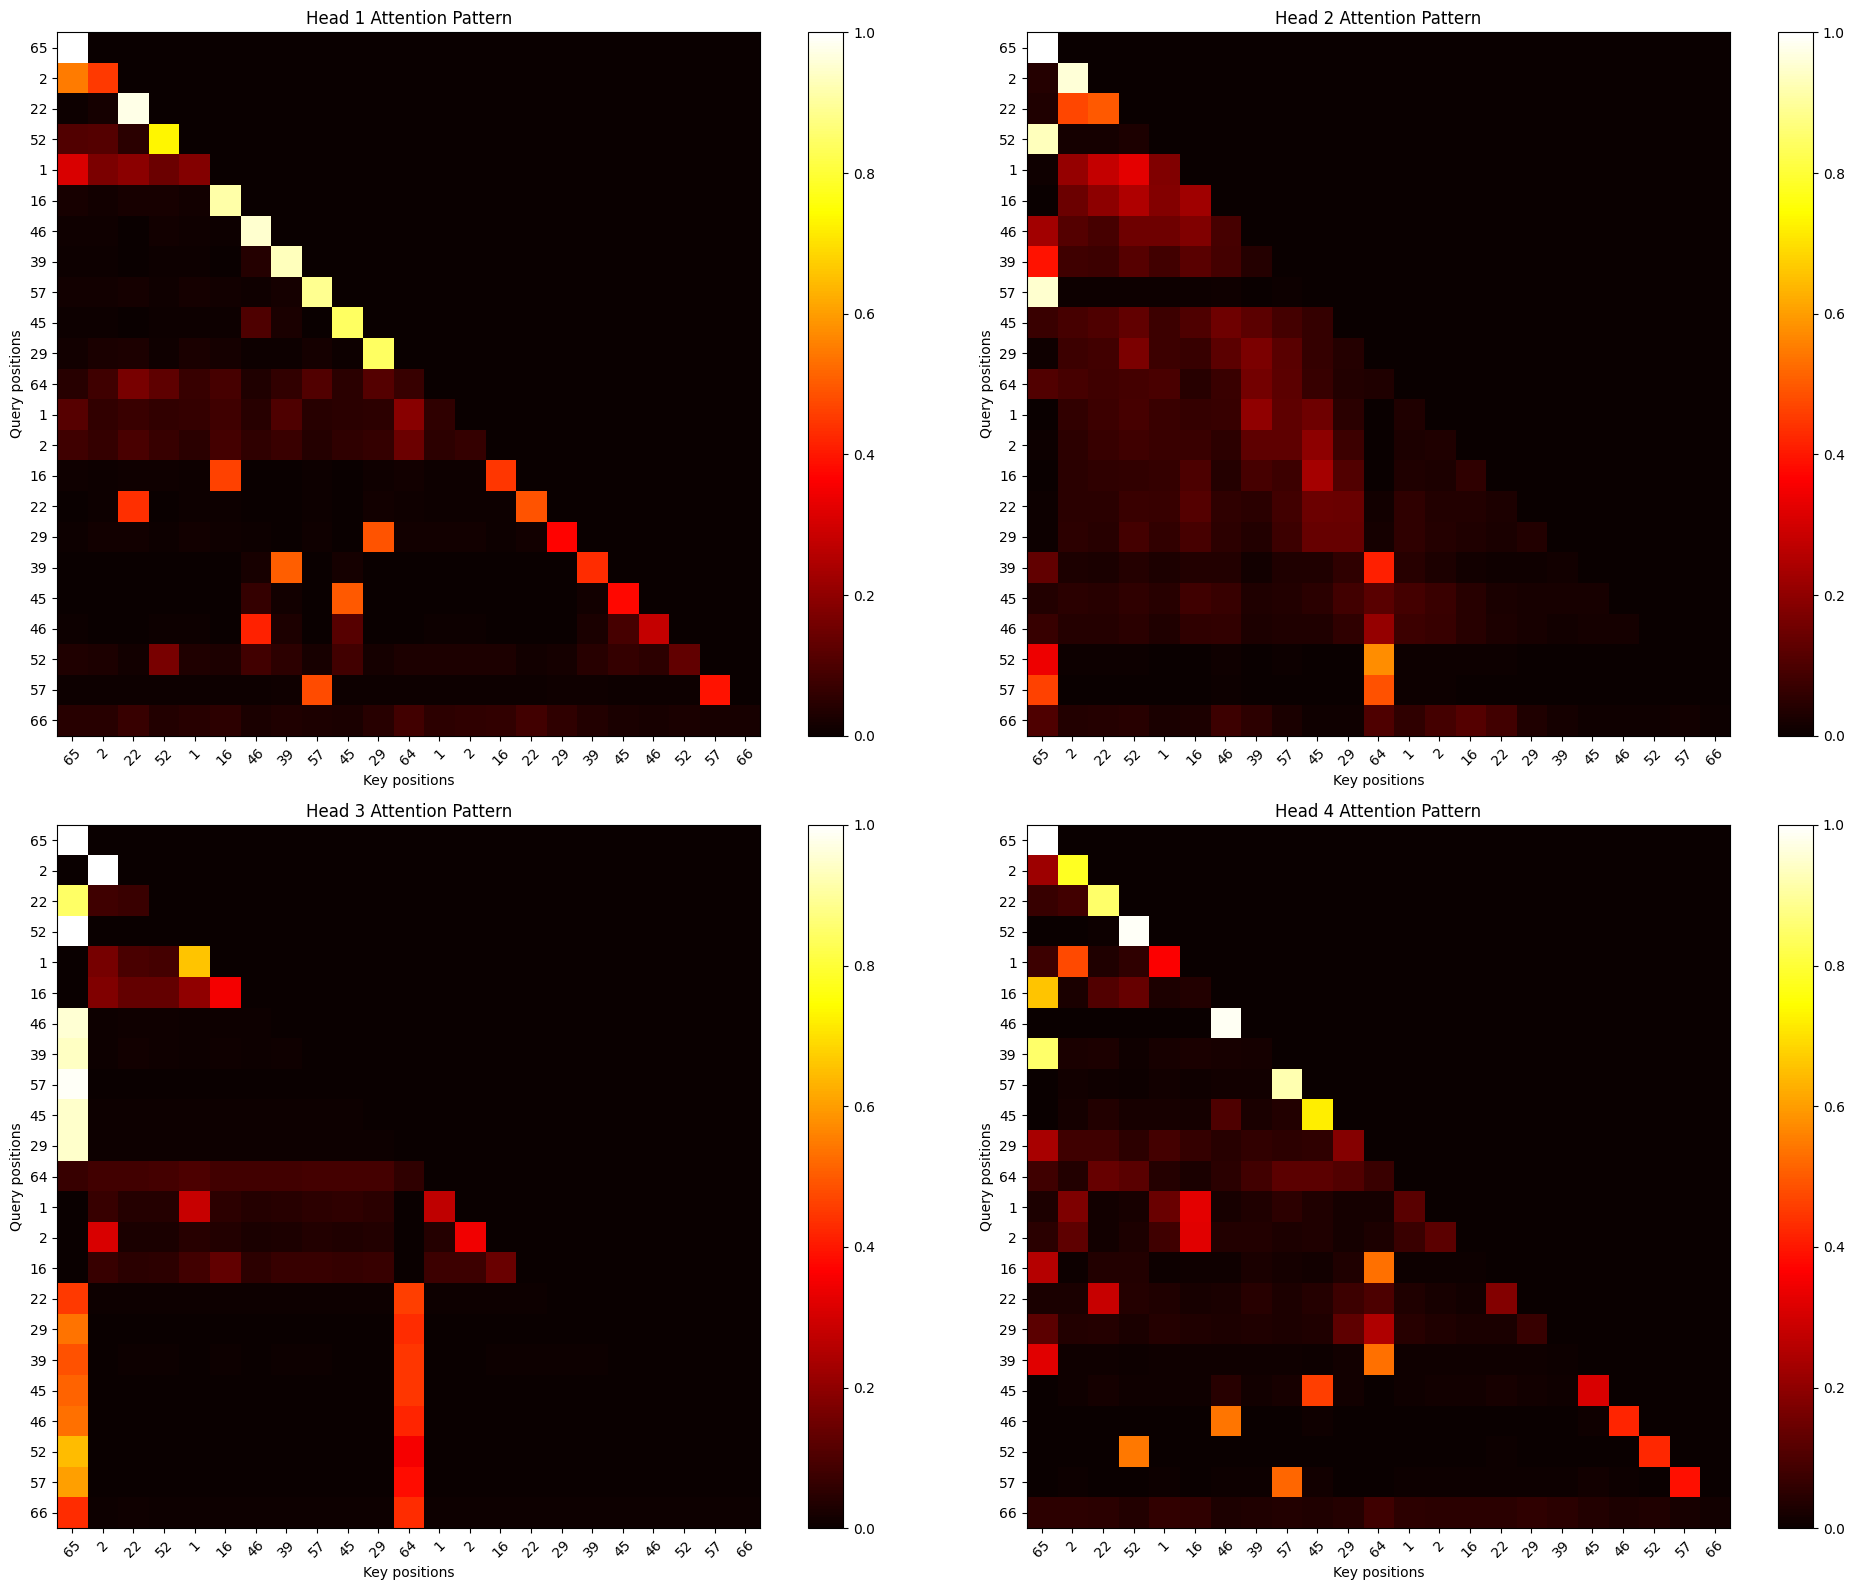


Test 3:
Original: [64 37 27 19 47  0 29 35 59 44 60 65 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Modified: [65 37 27 19 47  0 29 35 59 44 60 64  0 19 27 29 35 37 44 47 59 60 66 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 37 27 19 47  0 29 35 59 44 60 65  0 19 27 29 35 37 44 47 59 60 66 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 6

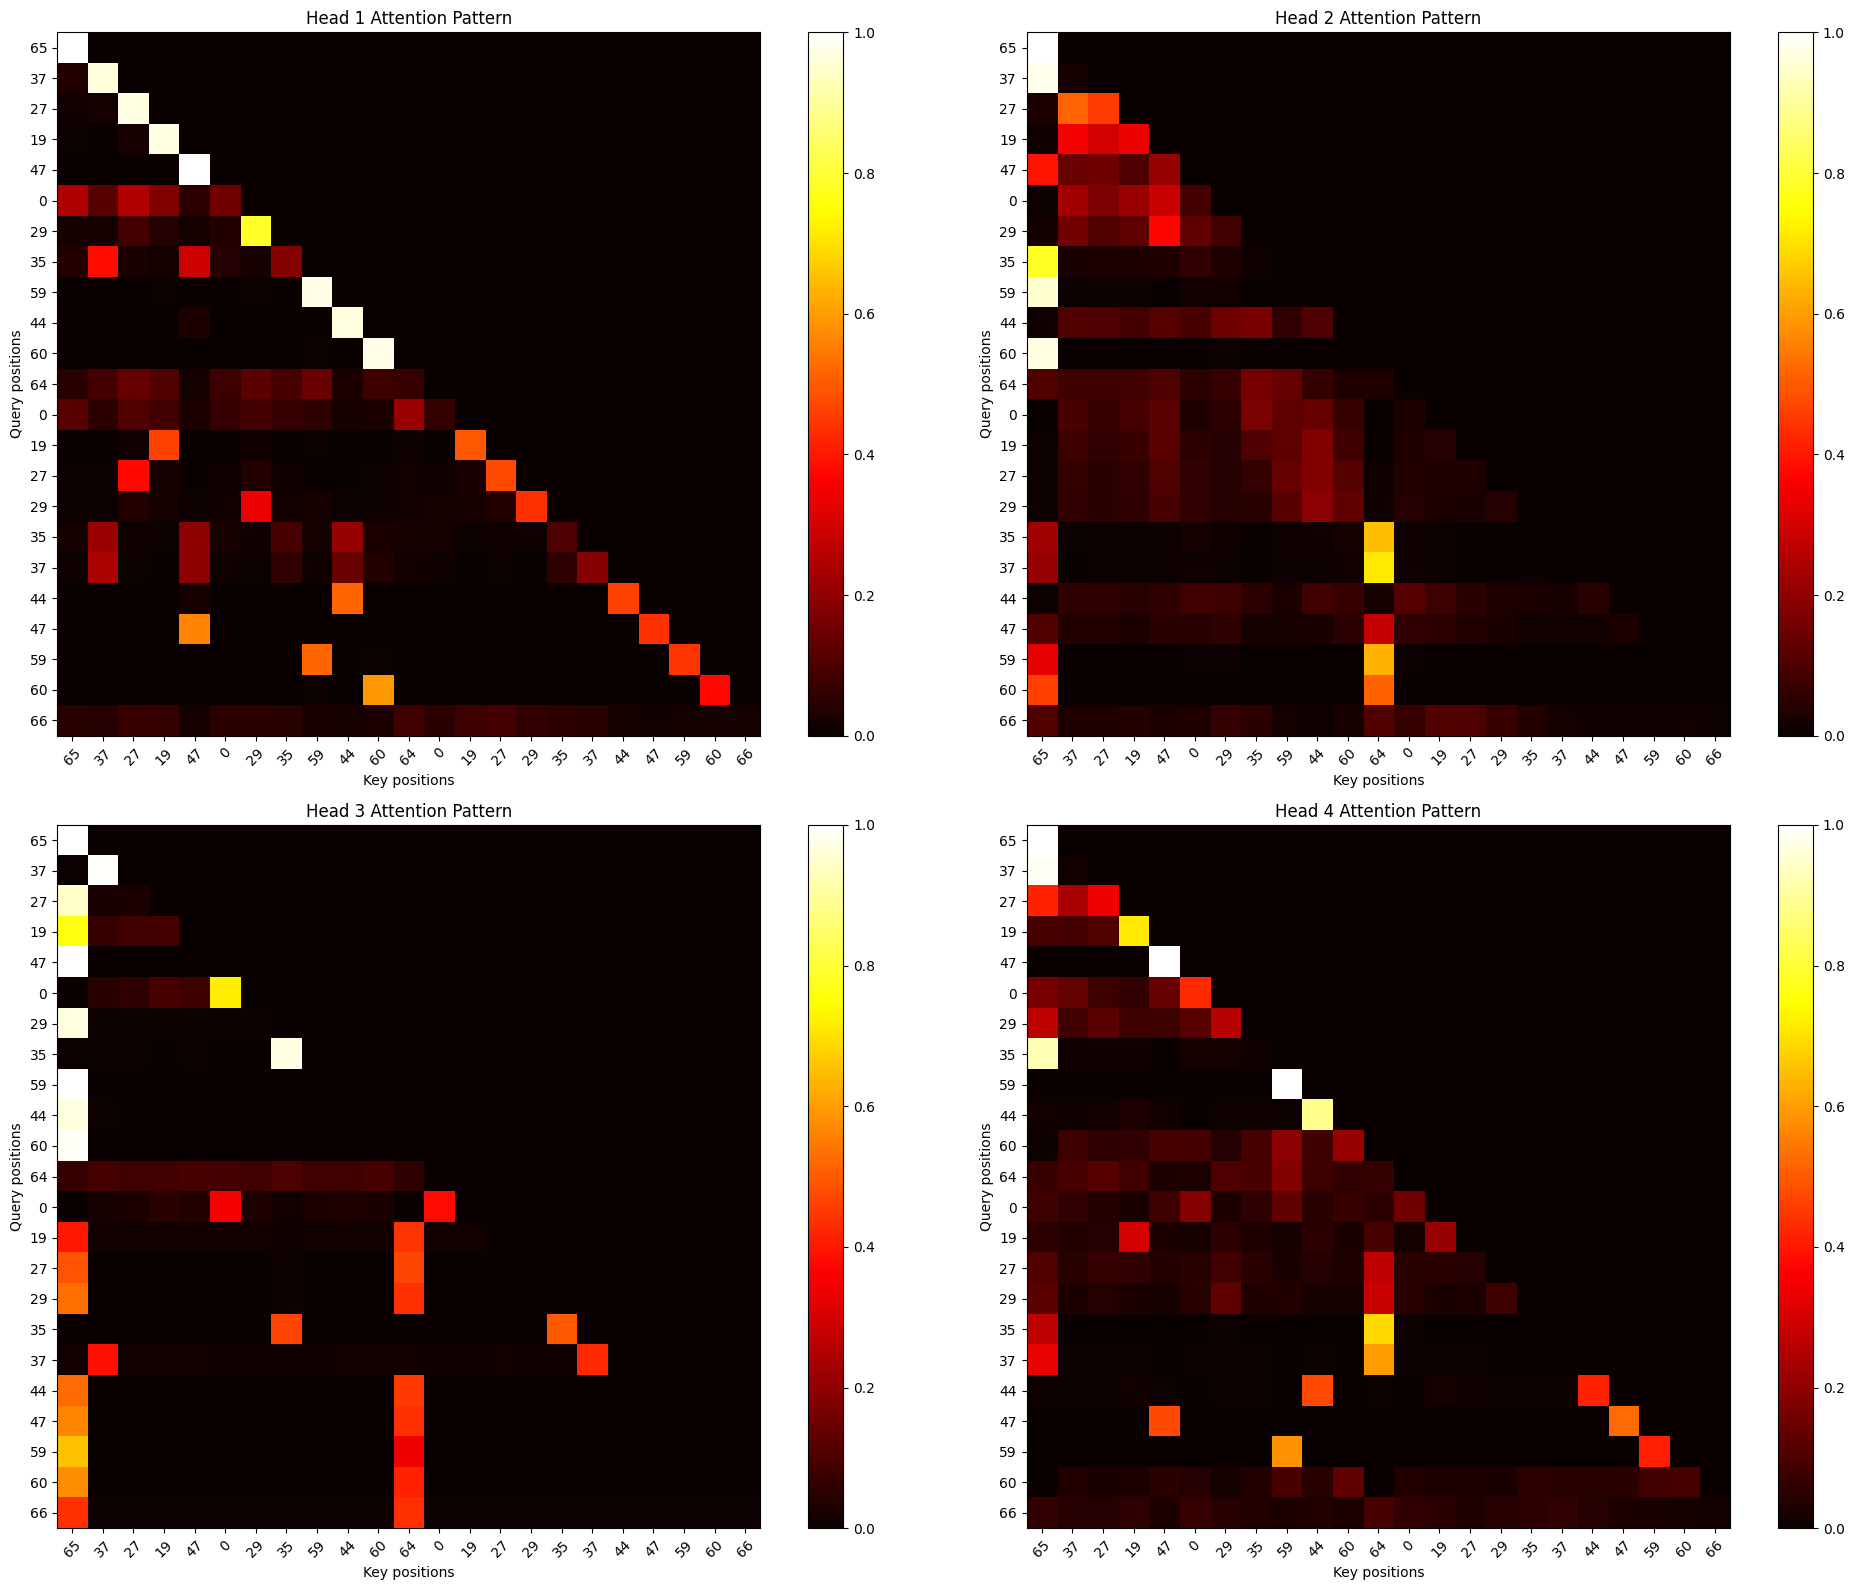


Test 4:
Original: [64 47  0 41 50 26 23 52 27 22 49 65 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Modified: [65 47  0 41 50 26 23 52 27 22 49 64  0 22 23 26 27 41 47 49 50 52 66 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64 47  0 41 50 26 23 52 27 22 49 65  0 22 23 26 27 41 47 49 50 52 66 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 6

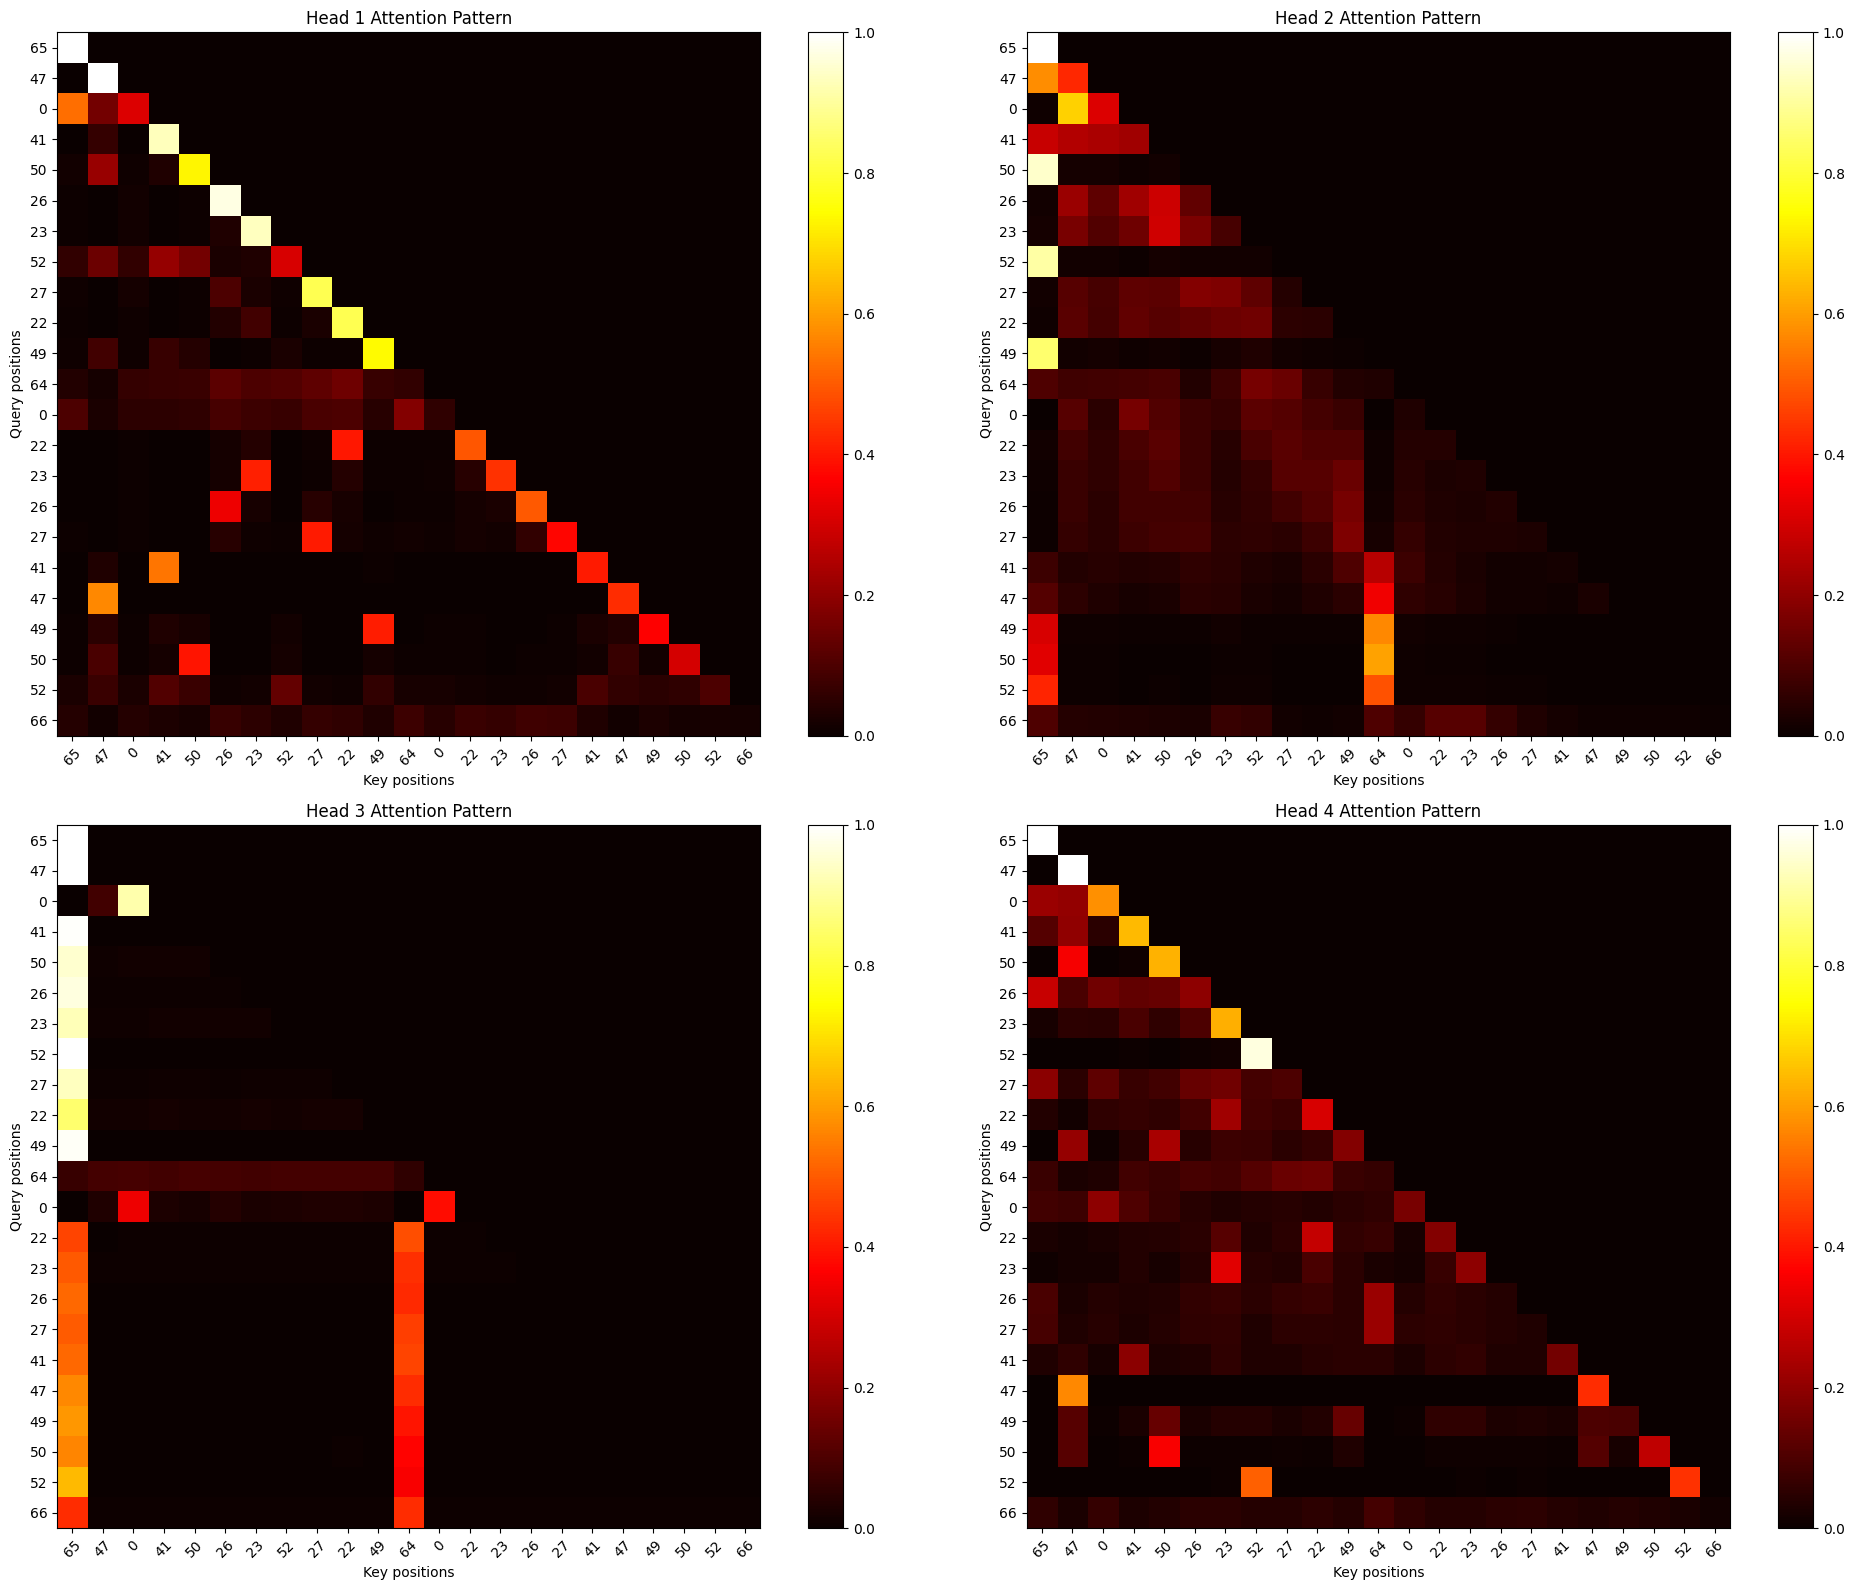


Test 5:
Original: [64  0 38 44  6  8 41 59  5 52 14 65 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Modified: [65  0 38 44  6  8 41 59  5 52 14 64  0  5  6  8 14 38 41 44 52 59 66 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 67 67 67 67 67 67]
Target: [64  0 38 44  6  8 41 59  5 52 14 65  0  5  6  8 14 38 41 44 52 59 66 67
 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67 67
 67 67 67 67 67 6

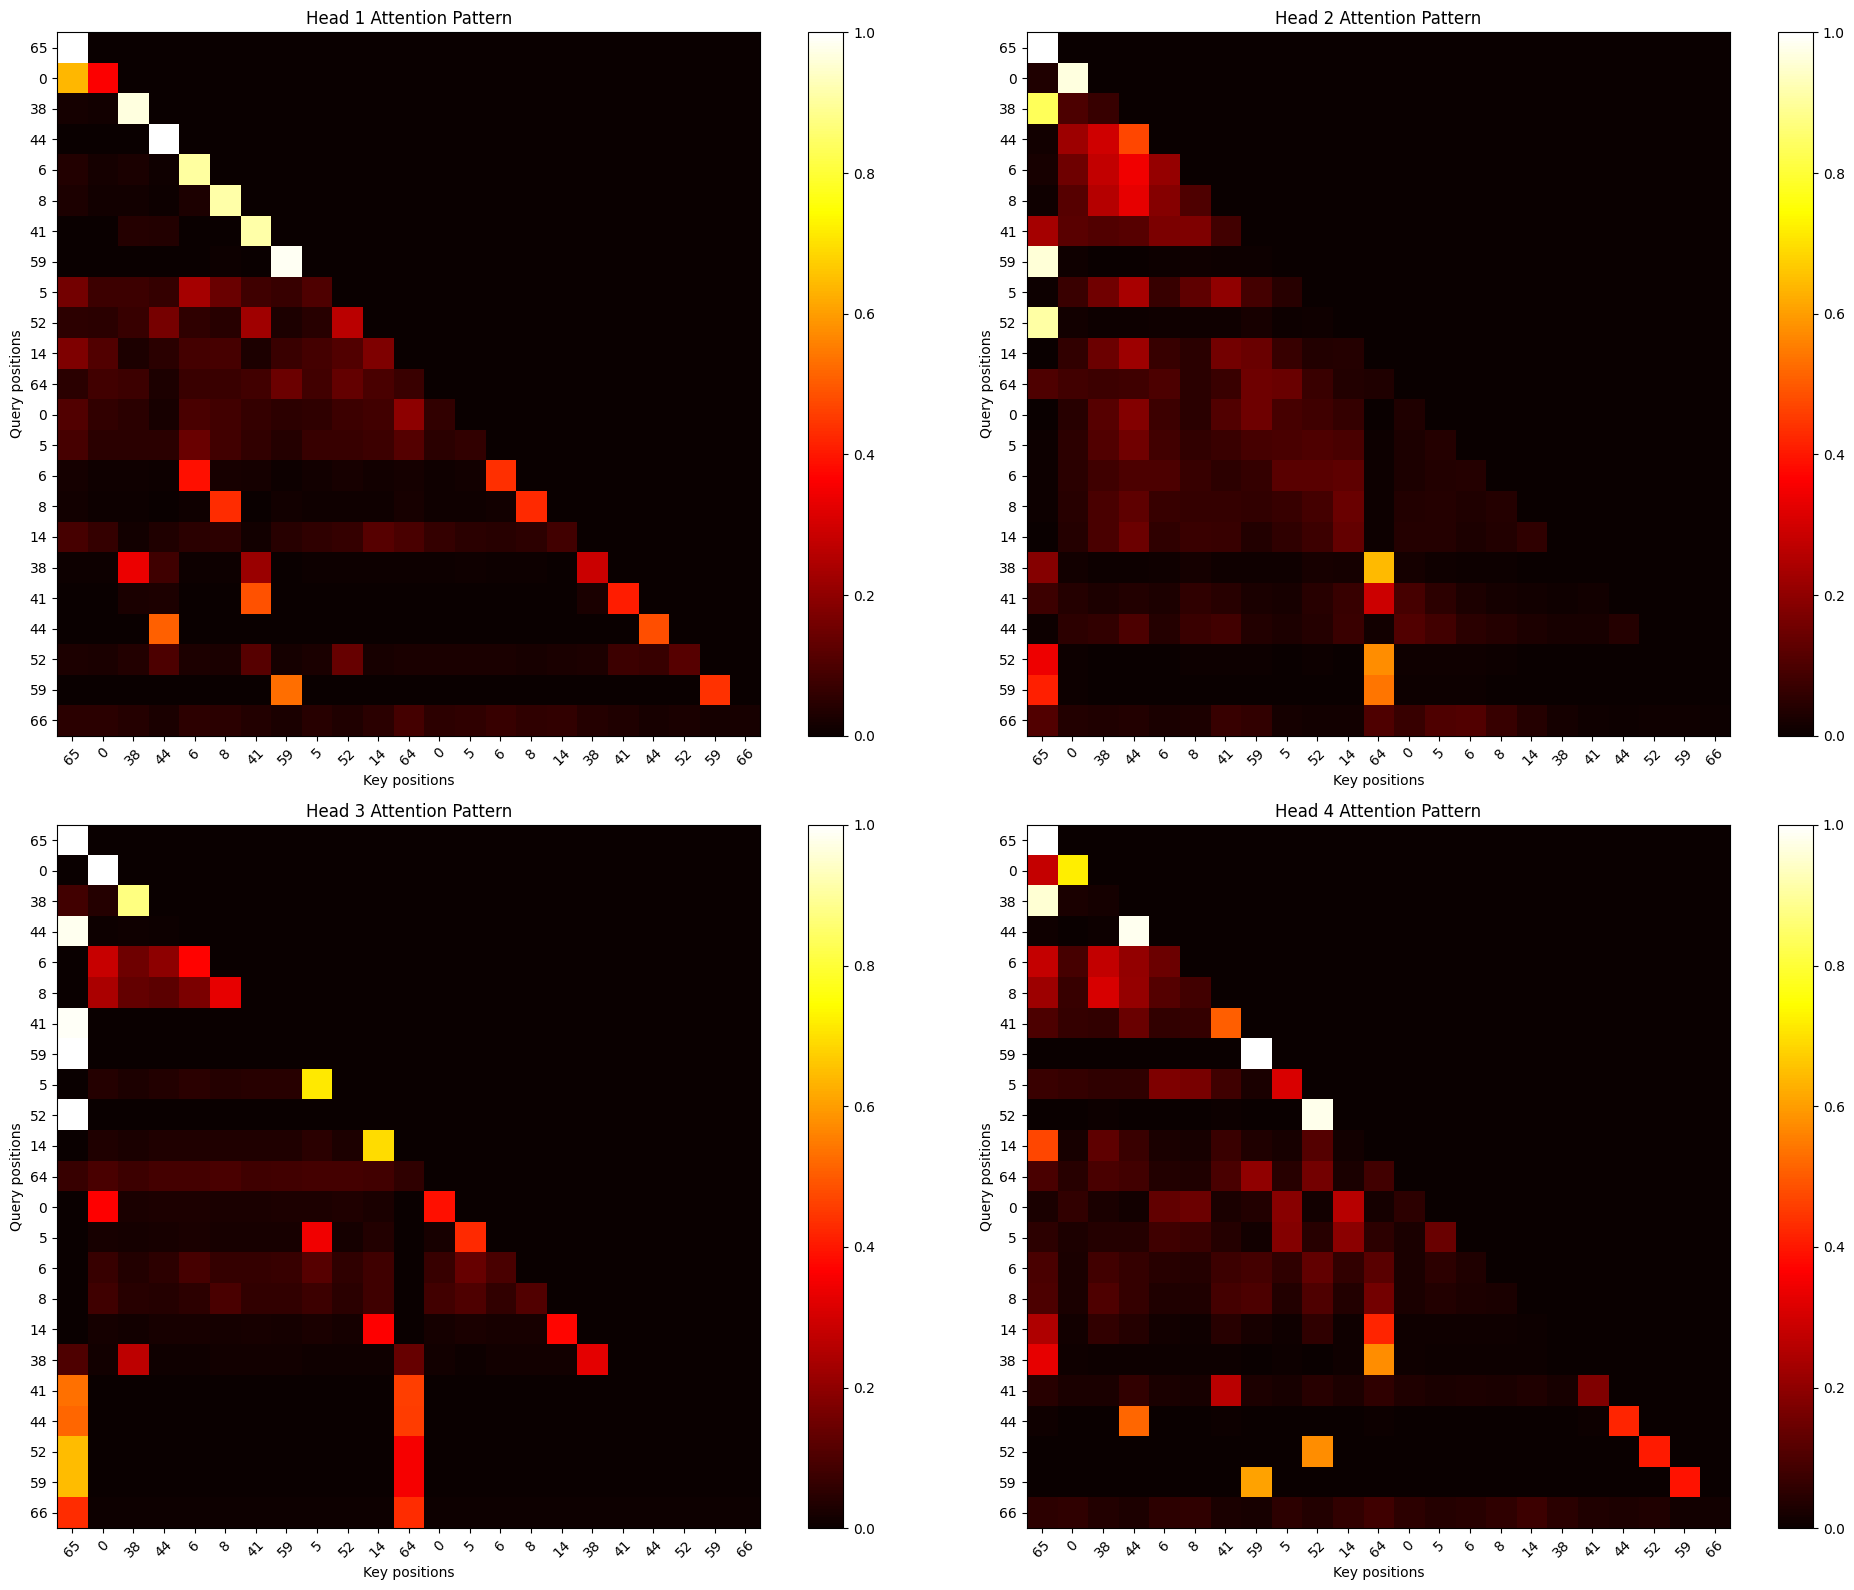

In [ ]:
#@title messing with special tokens
def modify_sequence(seq, modification_type):
    """
    Modifies sequence based on specified type:
    - 'no_start': Remove STARTSEQ
    - 'no_sort': Remove STARTSORT
    - 'no_both': Remove both special tokens
    - 'swap': Swap STARTSEQ and STARTSORT
    """
    seq = seq.clone()
    if modification_type == 'no_start':
        # Remove STARTSEQ and shift everything left
        seq = torch.cat([seq[1:], torch.tensor([PAD], device=device)])
    elif modification_type == 'no_sort':
        # Find and remove STARTSORT
        sort_idx = (seq == STARTSORT).nonzero()[0]
        seq = torch.cat([seq[:sort_idx], seq[sort_idx+1:], torch.tensor([PAD], device=device)])
    elif modification_type == 'no_both':
        # Remove both special tokens
        seq = torch.cat([seq[1:], torch.tensor([PAD], device=device)])
        sort_idx = (seq == STARTSORT).nonzero()[0]
        seq = torch.cat([seq[:sort_idx], seq[sort_idx+1:], torch.tensor([PAD], device=device)])
    elif modification_type == 'swap':
        # Swap STARTSEQ and STARTSORT
        start_idx = (seq == STARTSEQ).nonzero()[0]
        sort_idx = (seq == STARTSORT).nonzero()[0]
        seq[start_idx], seq[sort_idx] = seq[sort_idx], seq[start_idx]
    return seq

def test_modified_sequences():
    modifications = ['no_start', 'no_sort', 'no_both', 'swap']

    for mod in modifications:
        print(f"\nTesting modification: {mod}")
        for i in range(5):
            x, y, lengths = generate_data(1, fixed_length=10)

            # Modify input sequence
            modified_x = modify_sequence(x[0], mod)
            modified_x = modified_x.unsqueeze(0)

            # Get predictions
            with torch.no_grad():
                logits = model(modified_x)
                pred = logits.argmax(dim=-1)

            print(f"\nTest {i+1}:")
            print("Original:", x[0].cpu().numpy())
            print("Modified:", modified_x[0].cpu().numpy())
            print("Target:", y[0].cpu().numpy())
            print("Predicted:", pred[0].cpu().numpy())

            # Plot attention patterns
            plot_attention_patterns(modified_x, model)

# Run the experiments
test_modified_sequences()